In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
from pyproj import Proj
#Variables from configuration files
import config

ProcessedPath = config.SavePath
GROUPS = config.GROUPS


In [2]:
max_days = {}
for j in GROUPS:
    
    SavePath = ProcessedPath + str(j) + '/GPS_Days/'
    paths = os.listdir(SavePath)
    date,ind= [],[]
    for i in paths:
        data =  pd.read_csv(SavePath + '/'+ i ,index_col=0)
        
        date.append(i)
        ind.append(len(data['Individual'].unique()))
    max_item = max(ind)
    if max_item>=4:
        index_list = [date[index] for index in range(len(ind)) if ind[index] == max_item]
        max_days[j] = [index_list,max_item]
    

In [3]:
k = 'ZU_2021_1'
j = '2021-05-16'
def sync_gps_simultaneous(data,k,j):
    print('Duration of data',data.shape[0])
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    df =  data.groupby('Timestamp')
    dfnew = df.filter(lambda x: len(x['Individual'].unique())>=5)
    
    pp = Proj(proj='utm',zone=34,ellps='WGS84',south=True)

    xx, yy = pp(dfnew["lon"].values,dfnew["lat"].values)
    dfnew["X"] = xx
    dfnew["Y"] = yy 

    
    dfnew = dfnew.reset_index(drop=True)
    
    times = sorted(dfnew['Timestamp'].unique())
    time_start = times[0]
    time_end = times[-1]

    time_start = time_start + pd.Timedelta(seconds=30)
    time_end = time_end - pd.Timedelta(seconds=30)

    dfnew = dfnew.loc[(dfnew['Timestamp']>=time_start) & (dfnew['Timestamp']<=time_end)] 
    if j == '2021-05-18':  
        print('Seconds removed: ',len(dfnew.loc[((dfnew['X']<581950) & (dfnew['Y']>(7.02035e6)))]))
        dfnew = dfnew.loc[~((dfnew['X']<581950) & (dfnew['Y']>(7.02035e6)))] #for 3 erroneous points on '2021-05-18', remove for others
    
    else:
        pass
    dfnew=dfnew.reset_index(drop=True)
    
    print('Duration of Simultaneous data',dfnew.shape[0])
    return dfnew

Duration of data 52604
Duration of Simultaneous data 51345


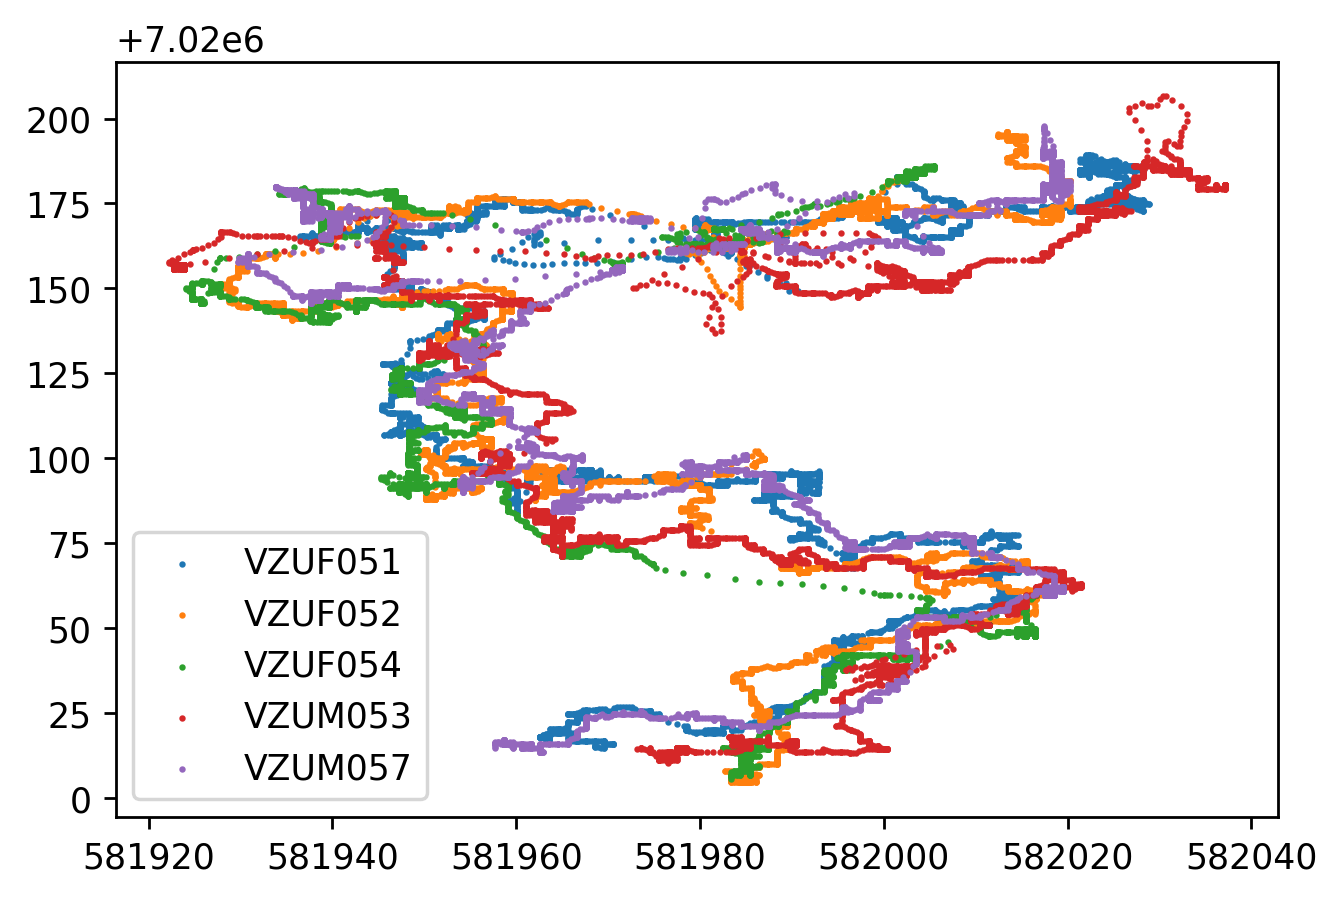

In [4]:
k = 'ZU_2021_1' #ZGroups
j = '2021-05-23' #Day
fig,ax= plt.subplots(dpi=250)
data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
data = sync_gps_simultaneous(data,k,j)

for ind in data['Individual'].unique():
    x = data.loc[data['Individual']==ind,'X']#.rolling(center=True,window=3).mean()
    y = data.loc[data['Individual']==ind,'Y']#.rolling(center=True,window=3).mean()
    plt.scatter(x,y,label=ind,s=0.7)
plt.legend()
plt.show()

# Space Discrete

In [5]:
times = sorted(data['Timestamp'].unique())
discrete_space_times,centroid_pos = [times[0]],[]
space_step = 10
prev_pos = data.loc[data['Timestamp'] == times[0]].dropna()
for time in times[1:]:
    prev_centroid = np.sum(prev_pos[['X','Y']],axis=0)/prev_pos.shape[0]
    new_pos = data.loc[data['Timestamp'] == time].dropna()
    new_centroid = np.sum(new_pos[['X','Y']],axis=0)/new_pos.shape[0]
    
    if np.sqrt(np.sum((new_centroid - prev_centroid)**2)) >= space_step:
        prev_pos = new_pos.dropna()
        discrete_space_times.append(time)
        centroid_pos.append(new_centroid)
    else:
        pass
discrete_space_times = [pd.to_datetime(i) for i in discrete_space_times]

In [295]:
len(centroid_pos),len(discrete_space_times)

(33, 34)

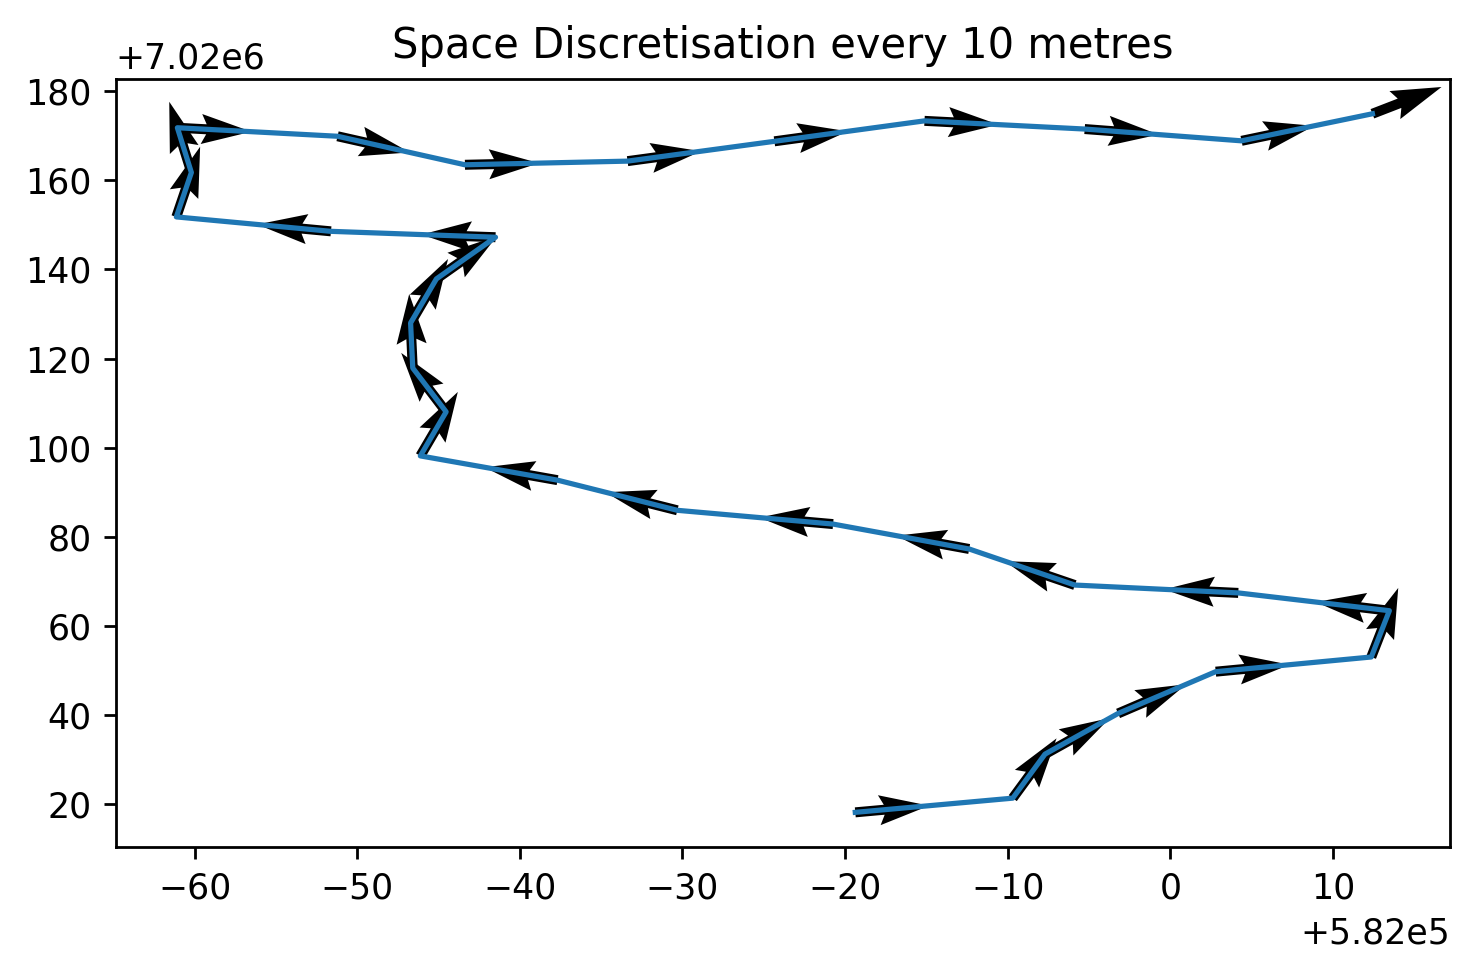

In [7]:
centroid_mov =pd.DataFrame()
centroid_mov['Timestamp'] = discrete_space_times[:-1]
centroid_mov['Centroid_X'] = [i[0] for i in centroid_pos]
centroid_mov['Centroid_Y'] = [i[1] for i in centroid_pos]
dirs = [(centroid_mov.iloc[i+1,1:3] - centroid_mov.iloc[i,1:3]) / np.sqrt(np.sum((centroid_mov.iloc[i+1,1:3] - centroid_mov.iloc[i,1:3])**2))  for i in range(centroid_mov.shape[0]-1) ]
centroid_mov = centroid_mov.iloc[0:-1,:]
centroid_mov['Dir_X'] = [i[0] for i in dirs]
centroid_mov['Dir_Y'] = [i[1] for i in dirs]

fig,ax= plt.subplots(dpi=250)
#ax.set_aspect('equal')
plt.title('Space Discretisation every ' + str(space_step) + ' metres')
ax.plot(centroid_mov.iloc[:,1],centroid_mov.iloc[:,2])
ax.quiver(centroid_mov.iloc[:,1],centroid_mov.iloc[:,2],centroid_mov.iloc[:,3],centroid_mov.iloc[:,4],angles='xy')
plt.tight_layout()
plt.show()

Relative Position and axis rotation

In [8]:
data_discrete =  data.set_index('Timestamp').loc[centroid_mov['Timestamp']].reset_index()
data_discrete = data_discrete.replace([np.inf, -np.inf], np.nan)
data_discrete = data_discrete.dropna(axis=0).reset_index(drop=True)

data_discrete = data_discrete.drop(['lat','lon','height-msl'],axis=1)
corrected_data_discrete = pd.DataFrame()
for time in data_discrete['Timestamp'].unique():
    
    group_data = data_discrete.loc[data_discrete['Timestamp']==time]
    centroid_data = centroid_mov.loc[centroid_mov['Timestamp']==time]
    new_df =group_data.loc[:,['Timestamp','Behavior','Individual']]
    new_df['Rel_X'] = group_data['X'] - centroid_data['Centroid_X'].values
    new_df['Rel_Y'] = group_data['Y'] - centroid_data['Centroid_Y'].values
    
    direction_angle = np.arctan(( centroid_data['Dir_Y']/ centroid_data['Dir_X']).values)
    Rel_X = new_df['Rel_X']*np.cos(direction_angle) - new_df['Rel_Y']*np.sin(direction_angle)
    Rel_Y = new_df['Rel_X']*np.sin(direction_angle) + new_df['Rel_Y']*np.cos(direction_angle)
    new_df['Rel_X'] = Rel_X
    new_df['Rel_Y'] = Rel_Y
    new_df['X_zscore'] = (new_df['Rel_X'] - np.mean(new_df['Rel_X'])) / np.std(new_df['Rel_X']) 
    new_df['Y_zscore'] = (new_df['Rel_Y'] - np.mean(new_df['Rel_Y'])) / np.std(new_df['Rel_Y']) 
    
    corrected_data_discrete = pd.concat([corrected_data_discrete,new_df],axis=0)

In [9]:
corrected_data_discrete

Timestamp   Behavior Individual      Rel_X      Rel_Y  X_zscore  \
0   2021-05-23 08:08:18   Foraging    VZUF051 -10.720109  -6.009423 -0.561812   
1   2021-05-23 08:08:18   Foraging    VZUF052   6.824210 -10.836521  1.104279   
2   2021-05-23 08:08:18   Foraging    VZUF054   6.509195 -10.937886  1.074364   
3   2021-05-23 08:08:18   Foraging    VZUM053  -5.857508  -5.996222 -0.100036   
4   2021-05-23 08:08:18   Foraging    VZUM057 -20.776314 -10.408900 -1.516796   
..                  ...        ...        ...        ...        ...       ...   
148 2021-05-23 10:33:49  Vigilance    VZUF051   2.241516  -0.549480  0.242687   
149 2021-05-23 10:33:49   Foraging    VZUF052  -5.861762 -11.841792 -0.775797   
150 2021-05-23 10:33:49  Vigilance    VZUF054 -11.646019  -2.803294 -1.502808   
151 2021-05-23 10:33:49   Foraging    VZUM053   8.923184 -21.636721  1.082492   
152 2021-05-23 10:33:49   Foraging    VZUM057   7.896302 -13.568207  0.953426   

     Y_zscore  
0    1.218312  
1   -0.860948  
2   -0.904611  
3    1.223998  
4   -0.676751  
..        ...  
148  1.245811  
149 -0.230314  
150  0.951193  
151 -1.510701  
152 -0.455989  

[153 rows x 7 columns]

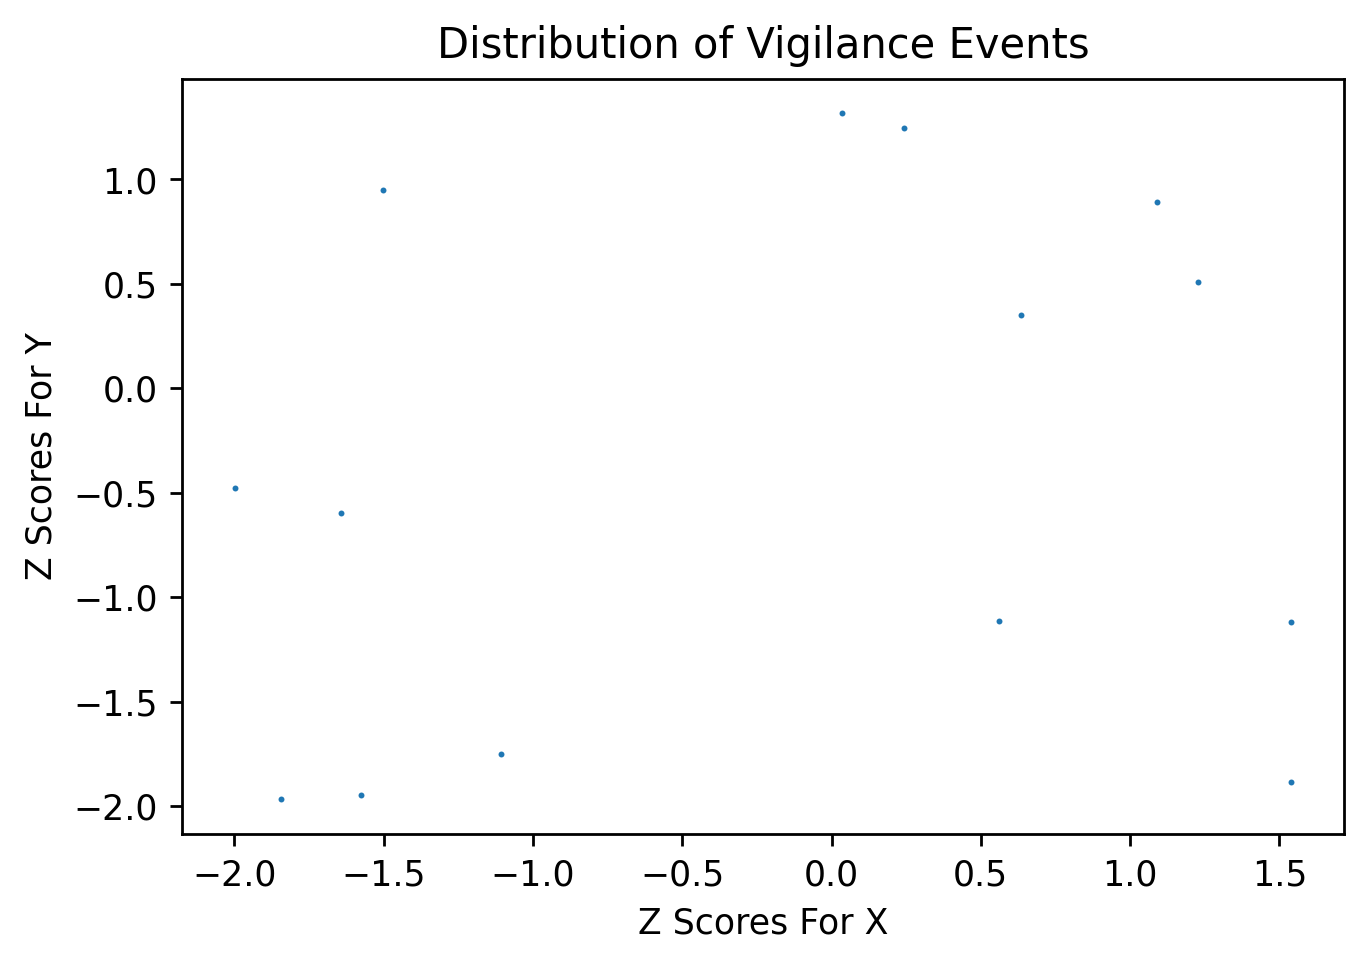

In [10]:
fig,ax= plt.subplots(dpi=250)
ax.set_title('Distribution of Vigilance Events')
ax.set_xlabel('Z Scores For X')
ax.set_ylabel('Z Scores For Y')
vig_data = corrected_data_discrete[corrected_data_discrete['Behavior']=='Vigilance']
ax.scatter(vig_data['X_zscore'],vig_data['Y_zscore'],s=0.5)

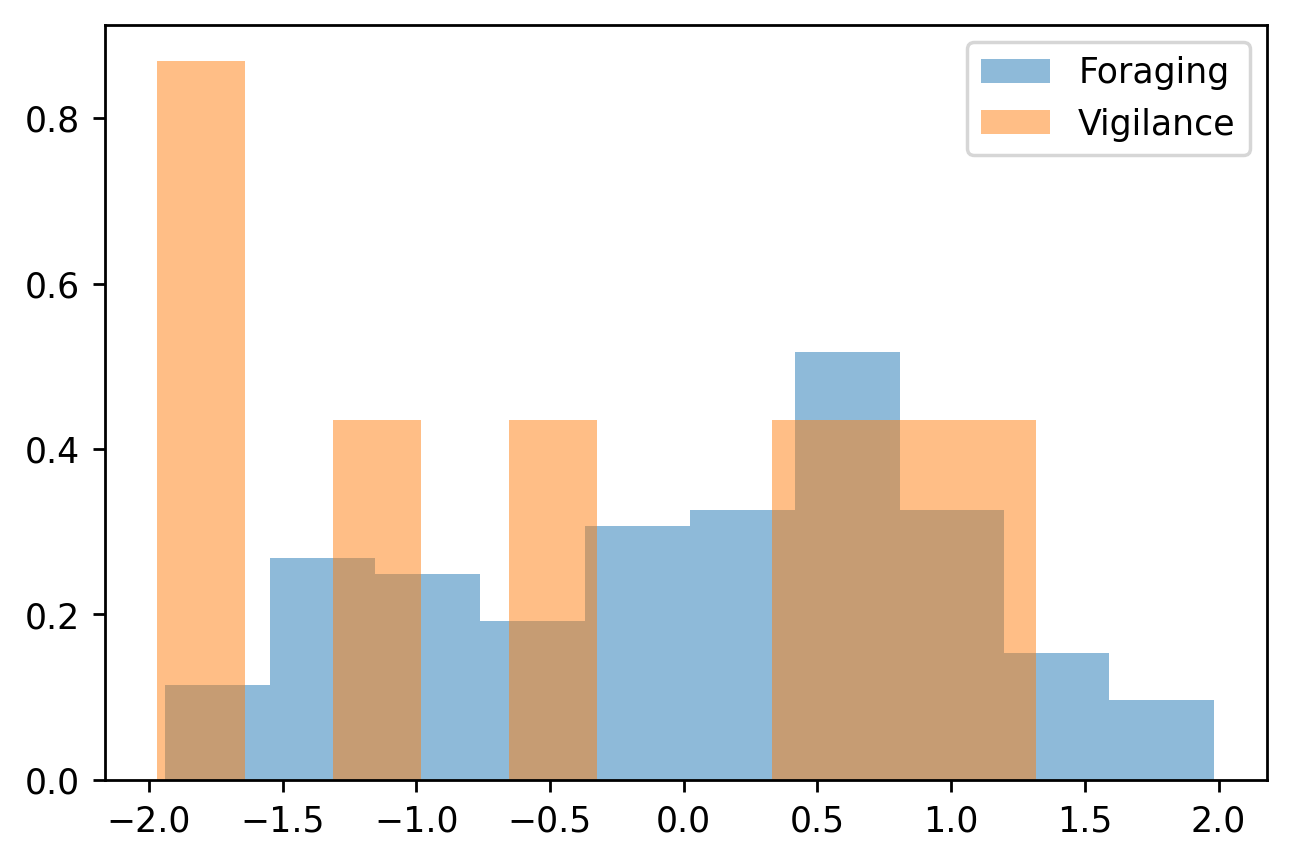

In [27]:
fig,ax= plt.subplots(dpi=250)
forage_data = corrected_data_discrete[corrected_data_discrete['Behavior']=='Foraging']
vig_data = corrected_data_discrete[corrected_data_discrete['Behavior']=='Vigilance']
ax.hist(forage_data['Y_zscore'],density=True,alpha=0.5,label="Foraging")
ax.hist(vig_data['Y_zscore'],density=True,alpha=0.5,label="Vigilance")
ax.legend()
plt.show()

In [107]:
group_data

def space_discrete(data,step):
    times = sorted(data['Timestamp'].unique())
    print(times[0])
    print('\n')
    discrete_space_times,centroid_pos = [times[0]],[]
    #Spatial Discretization
    space_step = step
    prev_pos = data.loc[data['Timestamp'] == times[0]].dropna()
    for time in times[1:]:
        prev_centroid = np.sum(prev_pos[['X','Y']],axis=0)/prev_pos.shape[0]
        new_pos = data.loc[data['Timestamp'] == time].dropna()
        new_centroid = np.sum(new_pos[['X','Y']],axis=0)/new_pos.shape[0]
    
        if np.sqrt(np.sum((new_centroid - prev_centroid)**2)) >= space_step:
            prev_pos = new_pos.dropna()
            discrete_space_times.append(time)
            centroid_pos.append(new_centroid)
        else:
            pass
    discrete_space_times = [pd.to_datetime(i) for i in discrete_space_times]
    
    return discrete_space_times,centroid_pos

def time_discrete(data,step):

    steptime = step

    times = sorted(data['Timestamp'].unique())[::steptime]
    discrete_space_times,centroid_pos = [times[0]],[]
    prev_pos = data.loc[data['Timestamp'] == times[0]].dropna()
    for time in times[1:]:
        
        prev_centroid = np.sum(prev_pos[['X','Y']],axis=0)/prev_pos.shape[0]
        new_pos = data.loc[data['Timestamp'] == time].dropna()
        new_centroid = np.sum(new_pos[['X','Y']],axis=0)/new_pos.shape[0]
        prev_pos = new_pos.dropna()
        discrete_space_times.append(time)
        centroid_pos.append(new_centroid)
    discrete_space_times = [pd.to_datetime(i) for i in discrete_space_times]
    return discrete_space_times,centroid_pos

def space_time_discrete(data,timestep,spacestep):

    steptime = timestep
    space_step = spacestep
    times = sorted(data['Timestamp'].unique())[::steptime]
    discrete_space_times,centroid_pos = [],[]
    
    rev_pos = data.loc[data['Timestamp'] == times[0]].dropna()
    for time in times:
        
        prev_centroid = np.sum(prev_pos[['X','Y']],axis=0)/prev_pos.shape[0]
        new_pos = data.loc[data['Timestamp'] == time].dropna()
        new_centroid = np.sum(new_pos[['X','Y']],axis=0)/new_pos.shape[0]
        prev_pos = new_pos.dropna()
        discrete_space_times.append(time)
        centroid_pos.append(new_centroid)
    discrete_space_times = [pd.to_datetime(i) for i in discrete_space_times]
    return discrete_space_times,centroid_pos

In [117]:
data.head()

Timestamp        lat       lon  height-msl  Behavior Individual  \
0 2021-05-23 08:08:18 -26.939340  21.82571  918.000000  Foraging    VZUF051   
1 2021-05-23 08:08:19 -26.939343  21.82571  918.000000  Foraging    VZUF051   
2 2021-05-23 08:08:20 -26.939347  21.82571  918.000000  Foraging    VZUF051   
3 2021-05-23 08:08:21 -26.939347  21.82571  917.333333  Foraging    VZUF051   
4 2021-05-23 08:08:22 -26.939343  21.82571  917.333333  Foraging    VZUF051   

               X             Y  
0  581968.569460  7.020016e+06  
1  581968.567049  7.020015e+06  
2  581968.564638  7.020015e+06  
3  581968.564638  7.020015e+06  
4  581968.567049  7.020015e+06

In [331]:
np.sqrt(centroid_mov['Centroid_X'].diff()**2 + centroid_mov['Centroid_Y'].diff()**2)

0           NaN
1      1.087190
2      0.099164
3      0.693630
4      3.515250
         ...   
165    1.388301
166    3.935152
167    0.297493
168    1.334626
169    0.462420
Length: 170, dtype: float64

For all data

Duration of data 52128
Duration of Simultaneous data 50855
Duration of data 54271
Seconds removed:  3
Duration of Simultaneous data 53206
Duration of data 63003
Duration of Simultaneous data 62076
Duration of data 63116
Duration of Simultaneous data 61937
Duration of data 63302
Duration of Simultaneous data 62056
Duration of data 63251
Duration of Simultaneous data 62286
Duration of data 52604
Duration of Simultaneous data 51345


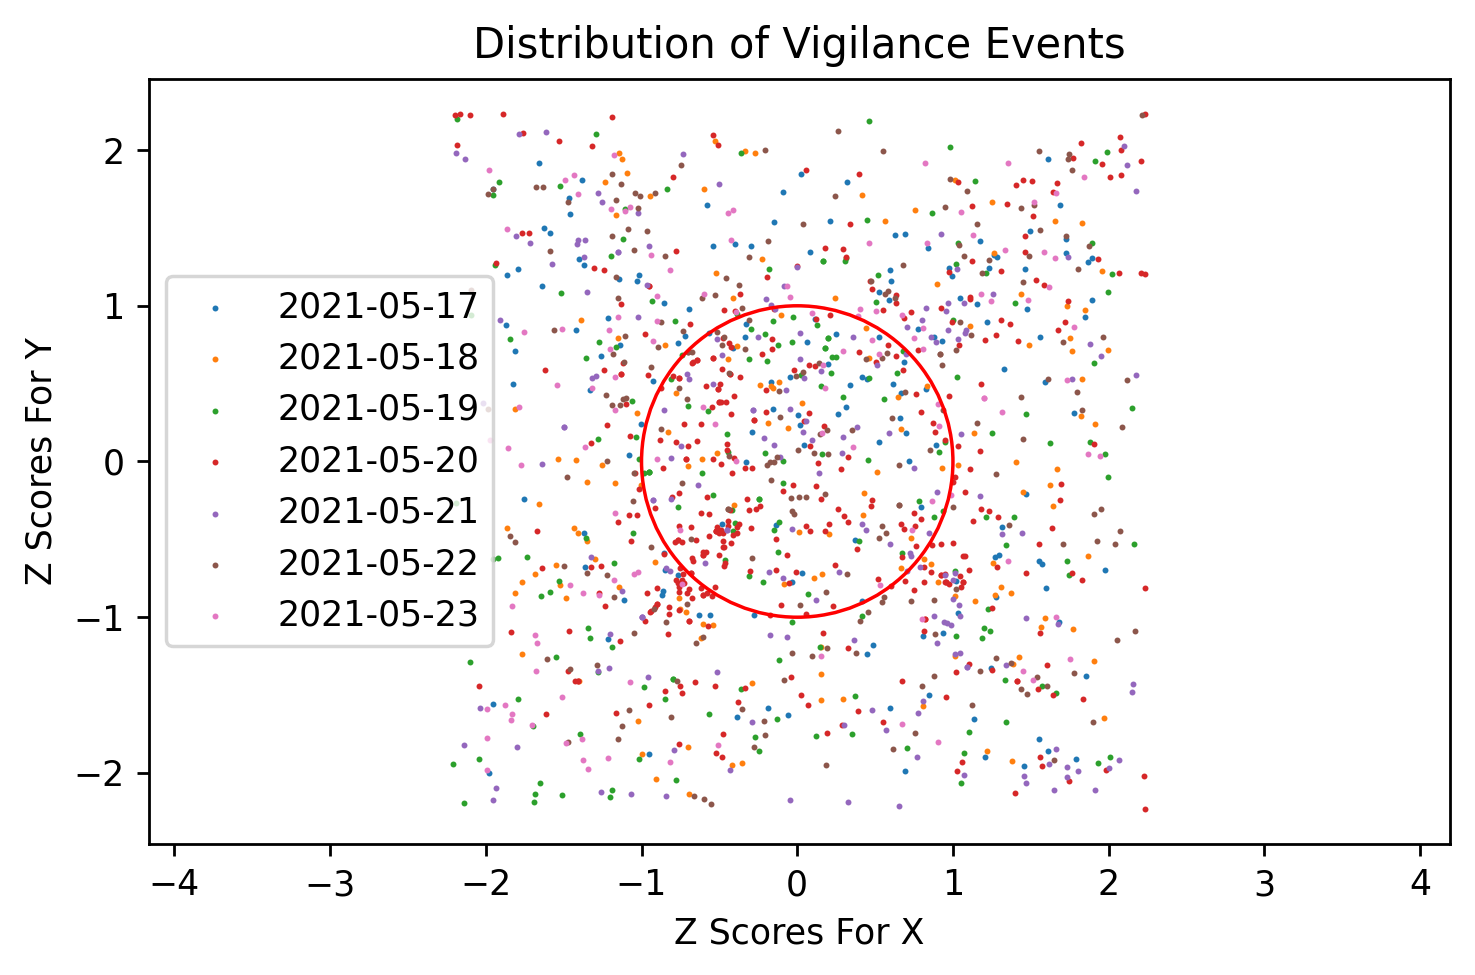

In [365]:
k = 'ZU_2021_1' #ZGroups
J = ['2021-05-17','2021-05-18','2021-05-19','2021-05-20','2021-05-21','2021-05-22','2021-05-23'] #Day
fig,ax= plt.subplots(dpi=250)
ax.set_title('Distribution of Vigilance Events')
ax.set_xlabel('Z Scores For X')
ax.set_ylabel('Z Scores For Y')
vig_events,vig_events_lims = [],[]

complete_corrected_data = pd.DataFrame()
complete_data = pd.DataFrame()
for j in J:
    data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
    data = sync_gps_simultaneous(data,k,j)
    complete_data = pd.concat([complete_data,data],axis=0)
    discrete_space_times,centroid_pos = time_discrete(data,60)
    #Centroid Movements, and corresponding heading directions
    centroid_mov =pd.DataFrame()
    centroid_mov['Timestamp'] = discrete_space_times[:-1]
    centroid_mov['Centroid_X'] = [i[0] for i in centroid_pos]
    centroid_mov['Centroid_Y'] = [i[1] for i in centroid_pos]
    dirs = [(centroid_mov.iloc[i+1,1:3] - centroid_mov.iloc[i,1:3]) / np.sqrt(np.sum((centroid_mov.iloc[i+1,1:3] - centroid_mov.iloc[i,1:3])**2))  for i in range(centroid_mov.shape[0]-1) ]
    centroid_mov = centroid_mov.iloc[0:-1,:]
    centroid_mov['Dir_X'] = [i[0] for i in dirs]
    centroid_mov['Dir_Y'] = [i[1] for i in dirs]
    centroid_mov['Distances'] = np.sqrt(centroid_mov['Centroid_X'].diff()**2 + centroid_mov['Centroid_Y'].diff()**2)
    
    data_discrete =  data.set_index('Timestamp').loc[centroid_mov['Timestamp']].reset_index()
    data_discrete = data_discrete.replace([np.inf, -np.inf], np.nan)
    data_discrete = data_discrete.dropna(axis=0).reset_index(drop=True)

    data_discrete = data_discrete.drop(['lat','lon','height-msl'],axis=1)
    corrected_data_discrete = pd.DataFrame()
    for time in data_discrete['Timestamp'].unique():
    
        group_data = data_discrete.loc[data_discrete['Timestamp']==time]
        centroid_data = centroid_mov.loc[centroid_mov['Timestamp']==time]
        new_df =group_data.loc[:,['Timestamp','Behavior','Individual']]
        new_df['Rel_X'] = group_data['X'] - centroid_data['Centroid_X'].values
        new_df['Rel_Y'] = group_data['Y'] - centroid_data['Centroid_Y'].values
        new_df['Distances'] = float(centroid_data.loc[:,'Distances'])
        
        direction_angle = np.arctan(( centroid_data['Dir_Y']/ centroid_data['Dir_X']).values)
        Rel_X = new_df['Rel_X']*np.cos(direction_angle) - new_df['Rel_Y']*np.sin(direction_angle)
        Rel_Y = new_df['Rel_X']*np.sin(direction_angle) + new_df['Rel_Y']*np.cos(direction_angle)
        new_df['Rel_X'] = Rel_X
        new_df['Rel_Y'] = Rel_Y
        new_df['X_zscore'] = (new_df['Rel_X'] - np.mean(new_df['Rel_X'])) / np.std(new_df['Rel_X']) 
        new_df['Y_zscore'] = (new_df['Rel_Y'] - np.mean(new_df['Rel_Y'])) / np.std(new_df['Rel_Y']) 
         

        corrected_data_discrete = pd.concat([corrected_data_discrete,new_df],axis=0)
    complete_corrected_data = pd.concat([complete_corrected_data,corrected_data_discrete],axis=0)    

    vig_data = corrected_data_discrete[corrected_data_discrete['Behavior']=='Vigilance']
    forage_data = corrected_data_discrete[corrected_data_discrete['Behavior']=='Foraging']
    vig_events_lims.append(len(vig_data[np.sqrt(vig_data['X_zscore']**2 + vig_data['Y_zscore']**2)<=1]))
    vig_events.append(len(vig_data))
    ax.scatter(vig_data['X_zscore'],vig_data['Y_zscore'],s=0.5,label=j)

    

    
cir = plt.Circle((0, 0), 1, color='r',fill=False)
ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
plt.legend()
plt.tight_layout()
plt.show()


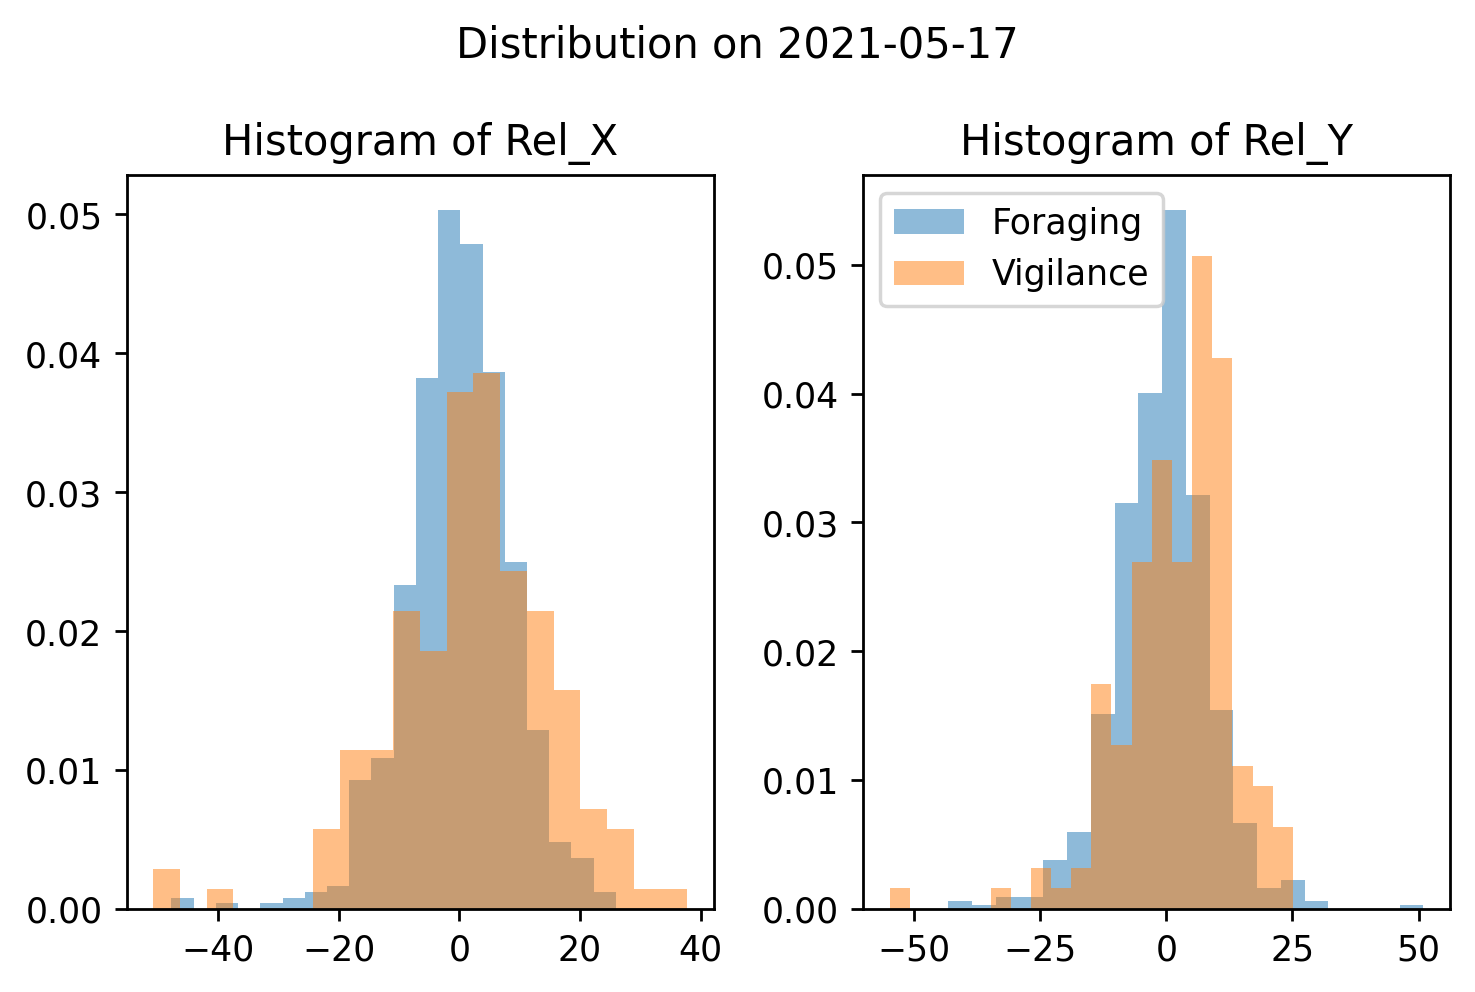

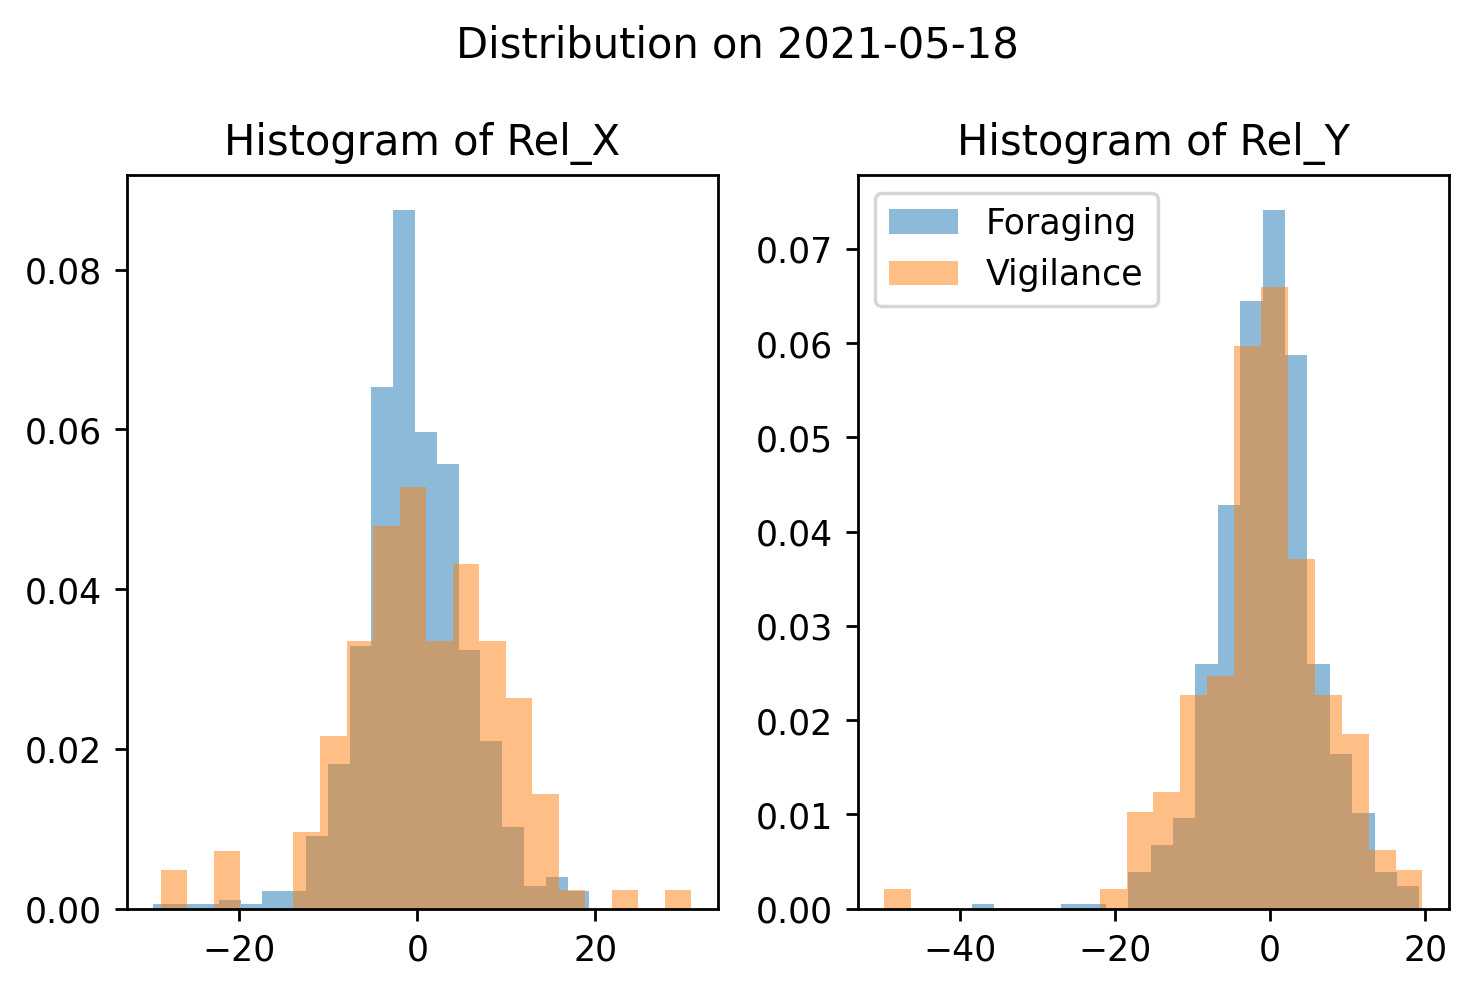

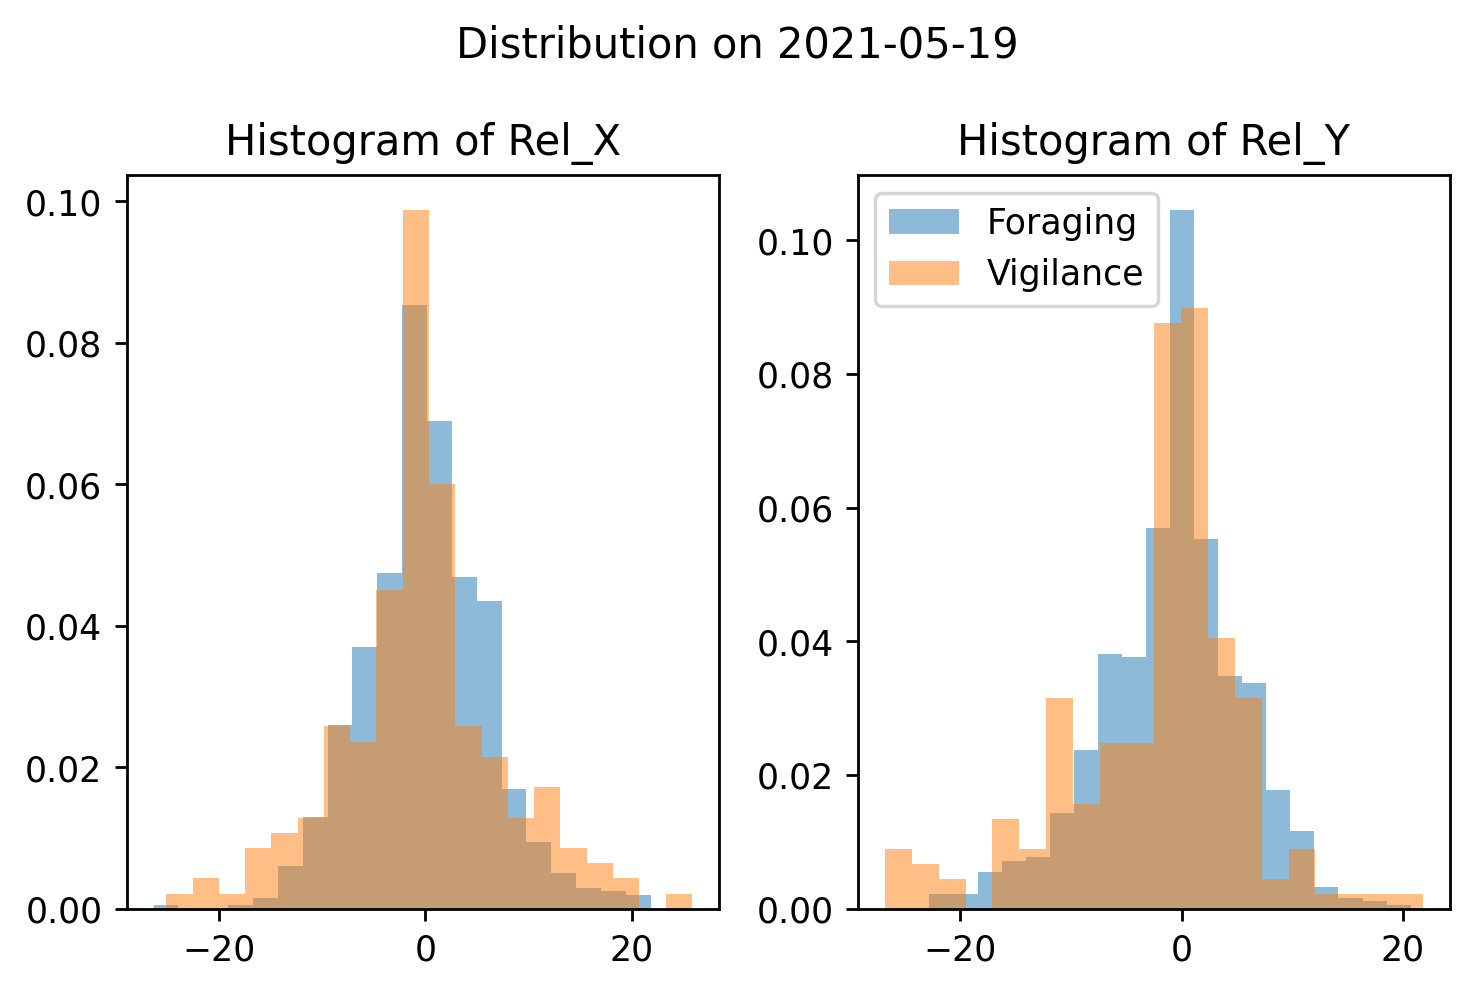

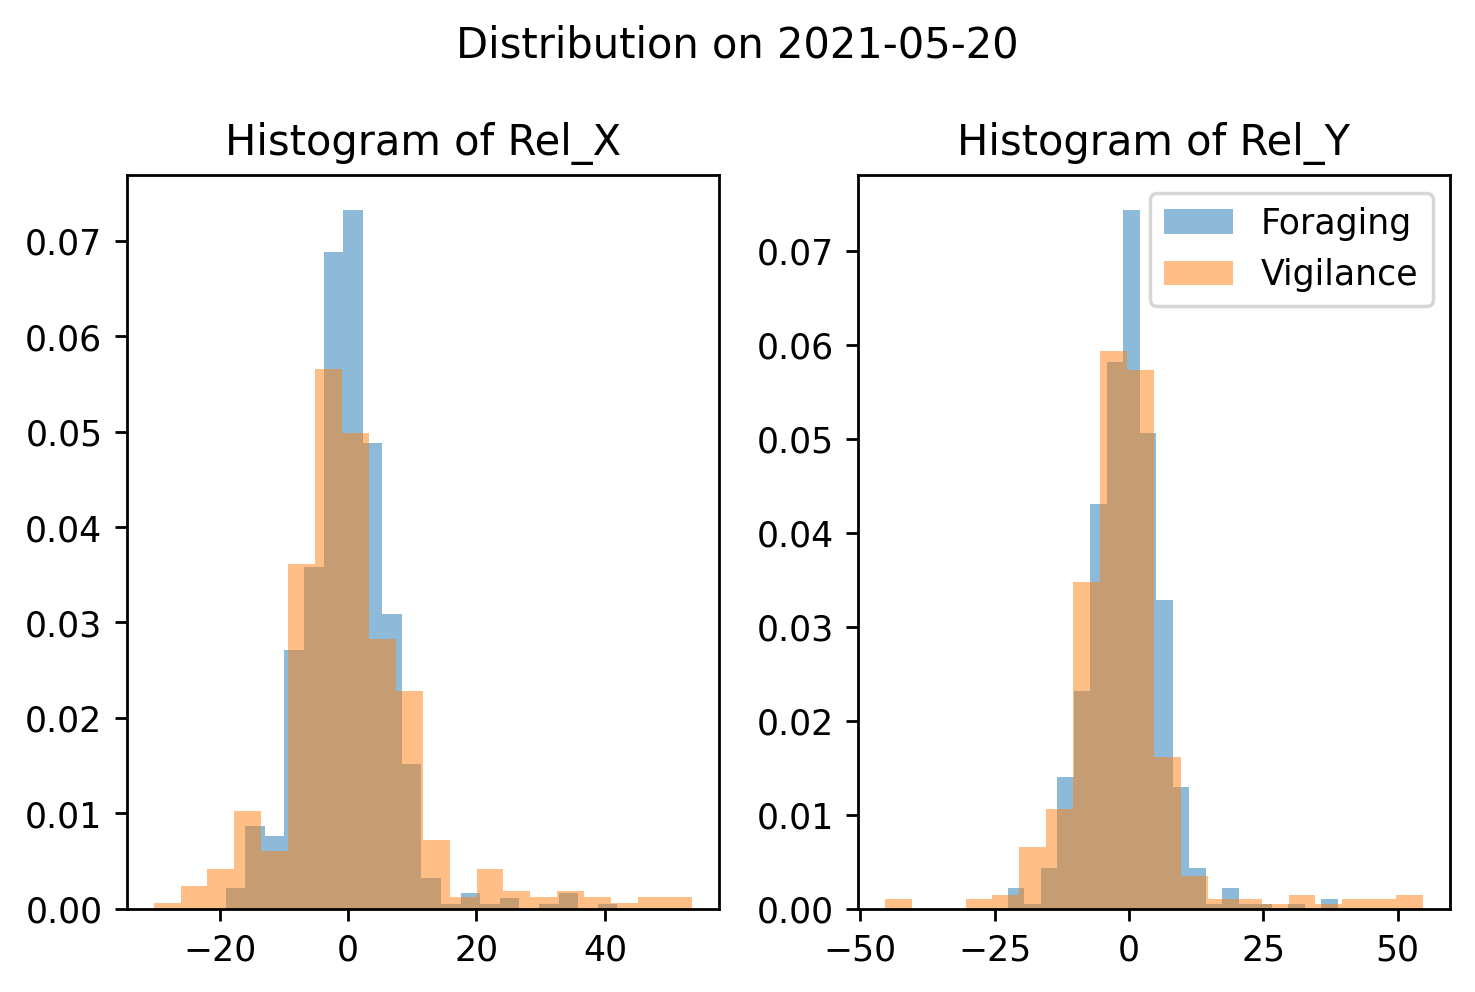

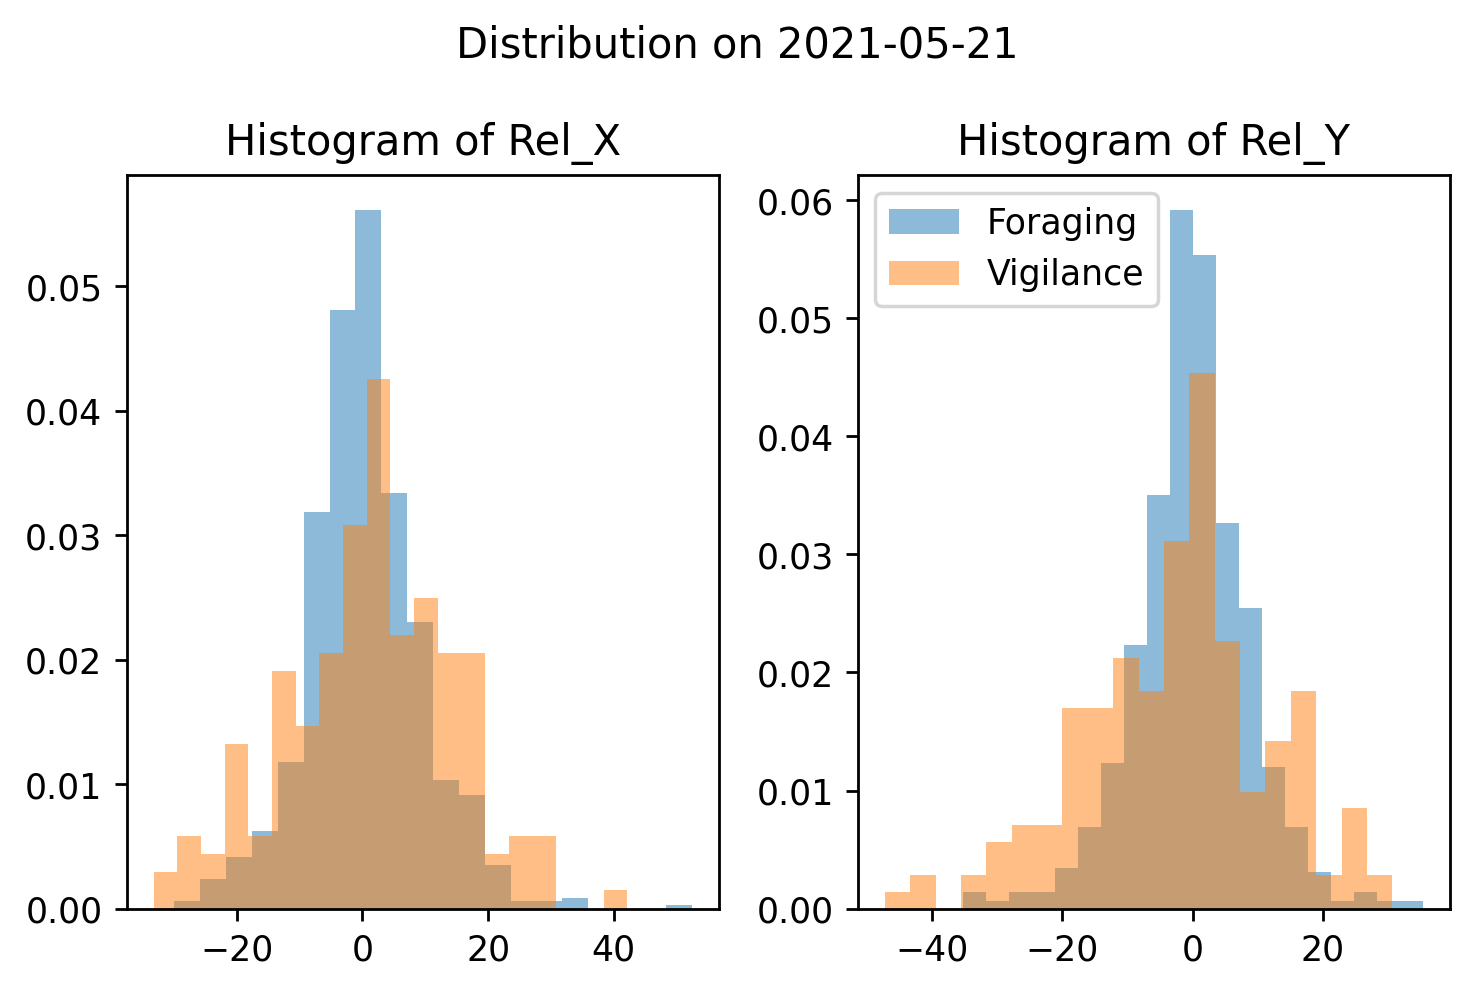

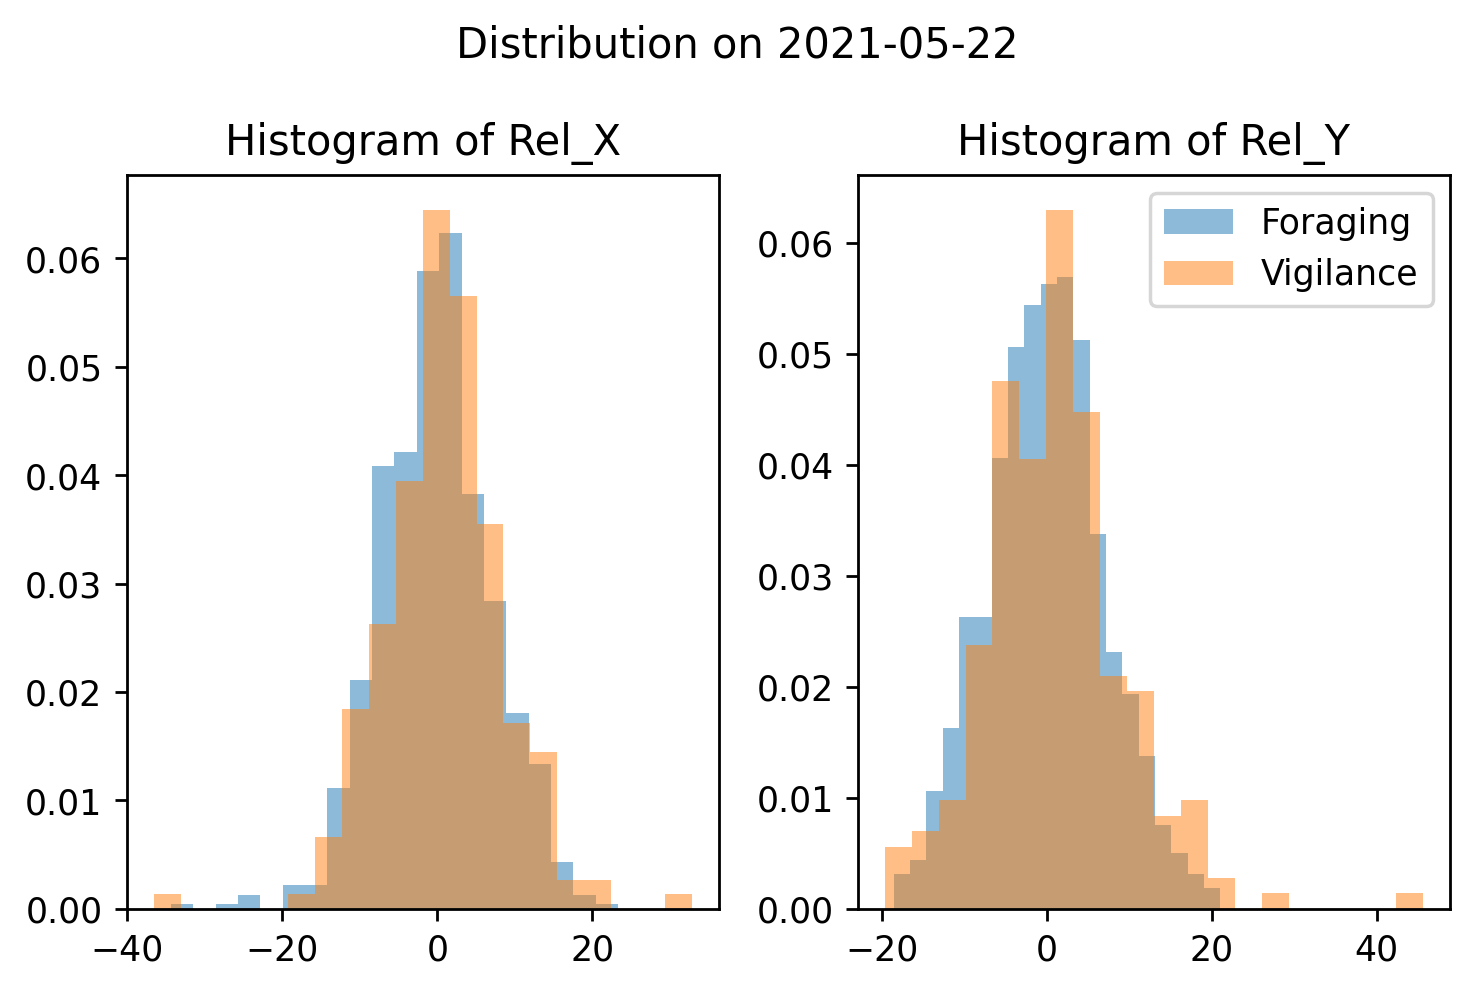

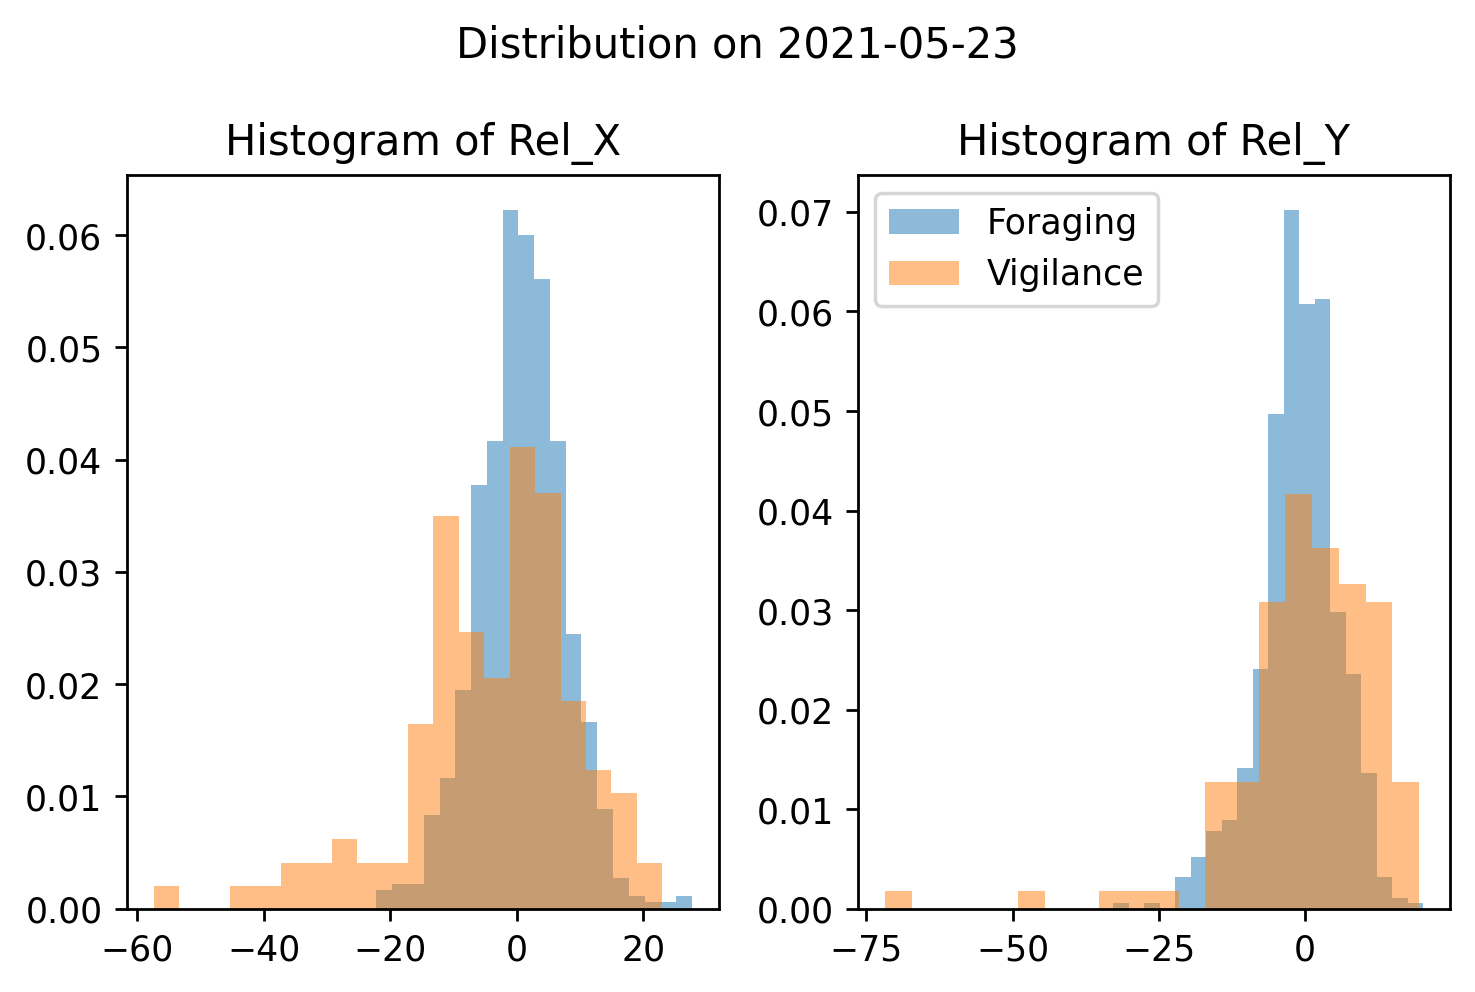

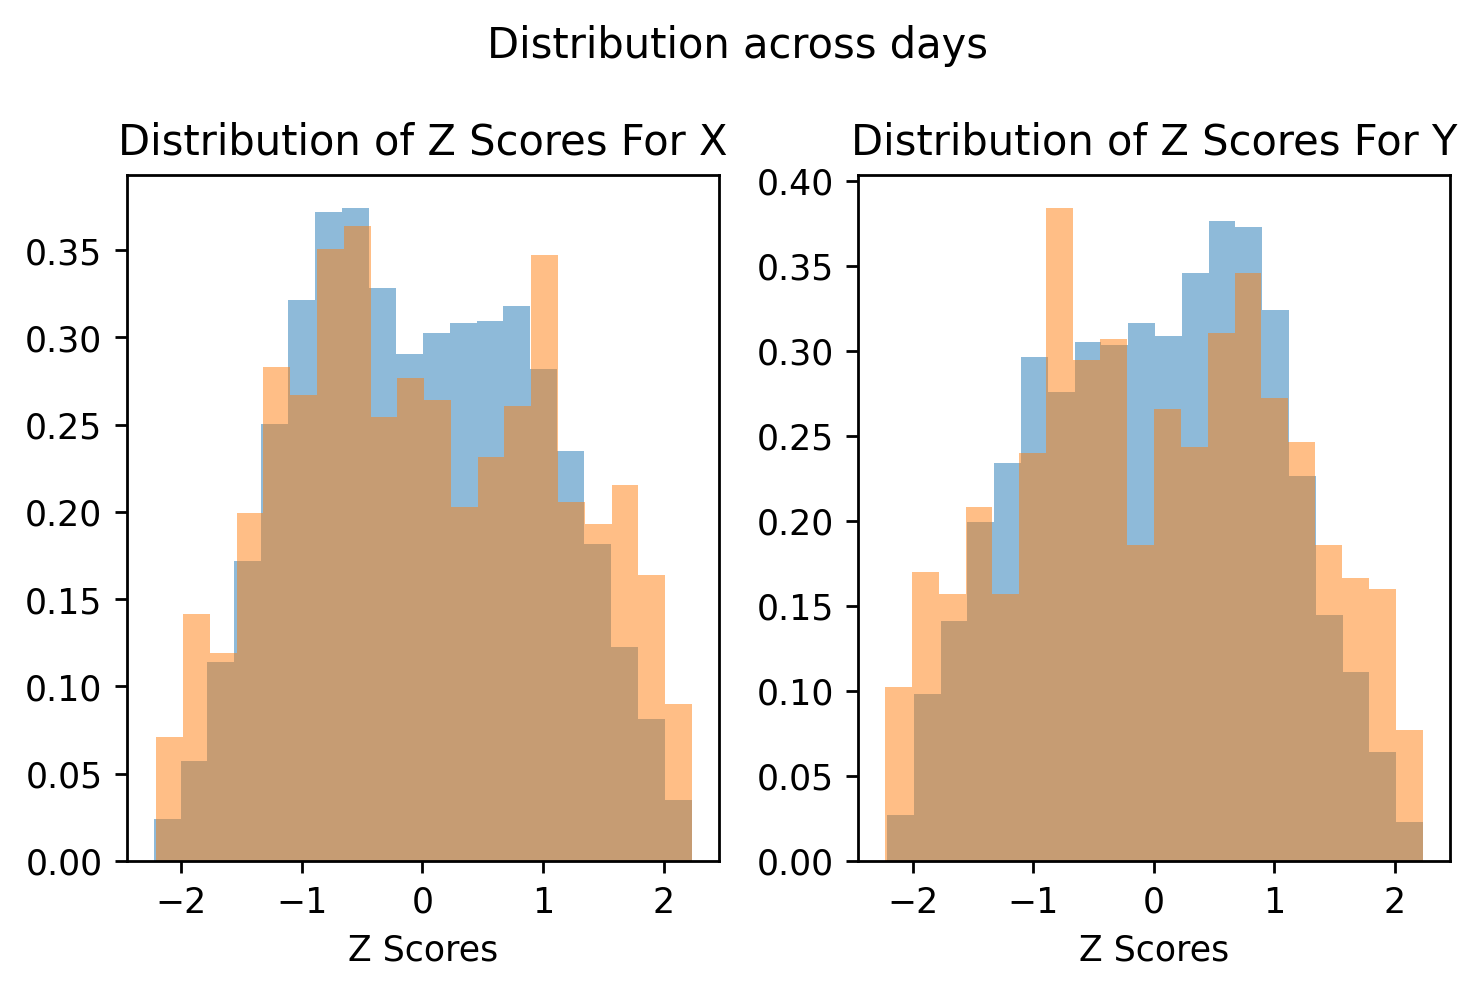

In [339]:
complete_corrected_data['day'] = complete_corrected_data['Timestamp'].dt.date
for i in complete_corrected_data['day'].unique():
    fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,dpi=250)
    day_data = complete_corrected_data[complete_corrected_data['day']==i]
    forage_data = day_data.loc[day_data['Behavior']=='Foraging']
    vig_data   = day_data.loc[day_data['Behavior']=='Vigilance']
    feature1,feature2 = 'Rel_X','Rel_Y'
    ax1.hist(forage_data[feature1],alpha=0.5,label="Foraging",density=True,bins=20)
    ax1.hist(vig_data[feature1],alpha=0.5,label="Vigilance",density=True,bins=20)
    ax1.set_title('Histogram of ' + feature1)
    ax2.hist(forage_data[feature2],alpha=0.5,label="Foraging",density=True,bins=20)
    ax2.hist(vig_data[feature2],alpha=0.5,label="Vigilance",density=True,bins=20)
    ax2.set_title('Histogram of ' + feature2)
    plt.legend()
    plt.suptitle('Distribution on ' + str(i))
    plt.tight_layout()
    plt.show()

fig1,(ax1,ax2)= plt.subplots(nrows=1,ncols=2,dpi=250)
ax1.set_title('Distribution of Z Scores For X')
ax1.set_xlabel('Z Scores')
ax1.set_ylabel('')

forage_data = complete_corrected_data.loc[complete_corrected_data['Behavior']=='Foraging',['X_zscore','Y_zscore']]
vig_data   = complete_corrected_data.loc[complete_corrected_data['Behavior']=='Vigilance',['X_zscore','Y_zscore']]
ax1.hist(forage_data['X_zscore'],alpha=0.5,label="Foraging",density=True,bins=20)
ax1.hist(vig_data['X_zscore'],alpha=0.5,label="Vigilance",density=True,bins=20)

ax2.set_title('Distribution of Z Scores For Y')
ax2.set_xlabel('Z Scores')
ax2.set_ylabel('')

ax2.hist(forage_data['Y_zscore'],alpha=0.5,label="Foraging",density=True,bins=20)
ax2.hist(vig_data['Y_zscore'],alpha=0.5,label="Vigilance",density=True,bins=20)
plt.suptitle('Distribution across days')
plt.tight_layout()
plt.show()    



In [366]:

complete_corrected_data['Theta'] = np.arctan(complete_corrected_data['Rel_Y']/complete_corrected_data['Rel_X'])
complete_corrected_data['R'] = np.sqrt(complete_corrected_data['Rel_Y']**2 + complete_corrected_data['Rel_X']**2)
vig_data = complete_corrected_data.loc[complete_corrected_data['Behavior']=='Vigilance']
forage_data = complete_corrected_data.loc[complete_corrected_data['Behavior']=='Foraging']
complete_corrected_data

Timestamp   Behavior Individual      Rel_X      Rel_Y  \
0   2021-05-17 08:09:57   Foraging    VZUF051   3.555980 -10.371652   
1   2021-05-17 08:09:57  Vigilance    VZUF052 -10.738006  -2.241229   
2   2021-05-17 08:09:57  Vigilance    VZUF054   0.311668  -4.372298   
3   2021-05-17 08:09:57   Foraging    VZUM056   2.919045  25.376499   
4   2021-05-17 08:09:57  Vigilance    VZUM059  10.279905  -4.503580   
..                  ...        ...        ...        ...        ...   
845 2021-05-23 10:57:18   Foraging    VZUF051   5.336298  -6.032935   
846 2021-05-23 10:57:18   Foraging    VZUF052  -0.777003   8.379570   
847 2021-05-23 10:57:18  Vigilance    VZUF054 -15.345529   5.849868   
848 2021-05-23 10:57:18   Foraging    VZUM053  10.560998 -11.994672   
849 2021-05-23 10:57:18   Foraging    VZUM057  -0.408469   1.574606   

     Distances  X_zscore  Y_zscore     Theta          R  
0          NaN  0.334615 -0.885338 -1.240500  10.964313  
1          NaN -1.753784 -0.239716  0.205765  10.969406  
2          NaN -0.139390 -0.408940 -1.499634   4.383392  
3          NaN  0.241557  1.953359  1.456270  25.543836  
4          NaN  1.317003 -0.419365 -0.412910  11.223132  
..         ...       ...       ...       ...        ...  
845    0.46242  0.629822 -0.738628 -0.846596   8.054339  
846    0.46242 -0.074967  1.166358 -1.478335   8.415517  
847    0.46242 -1.754541  0.831992 -0.364204  16.422735  
848    0.46242  1.232166 -1.526627 -0.848874  15.981453  
849    0.46242 -0.032480  0.266905 -1.316981   1.626724  

[6657 rows x 10 columns]

<AxesSubplot:>

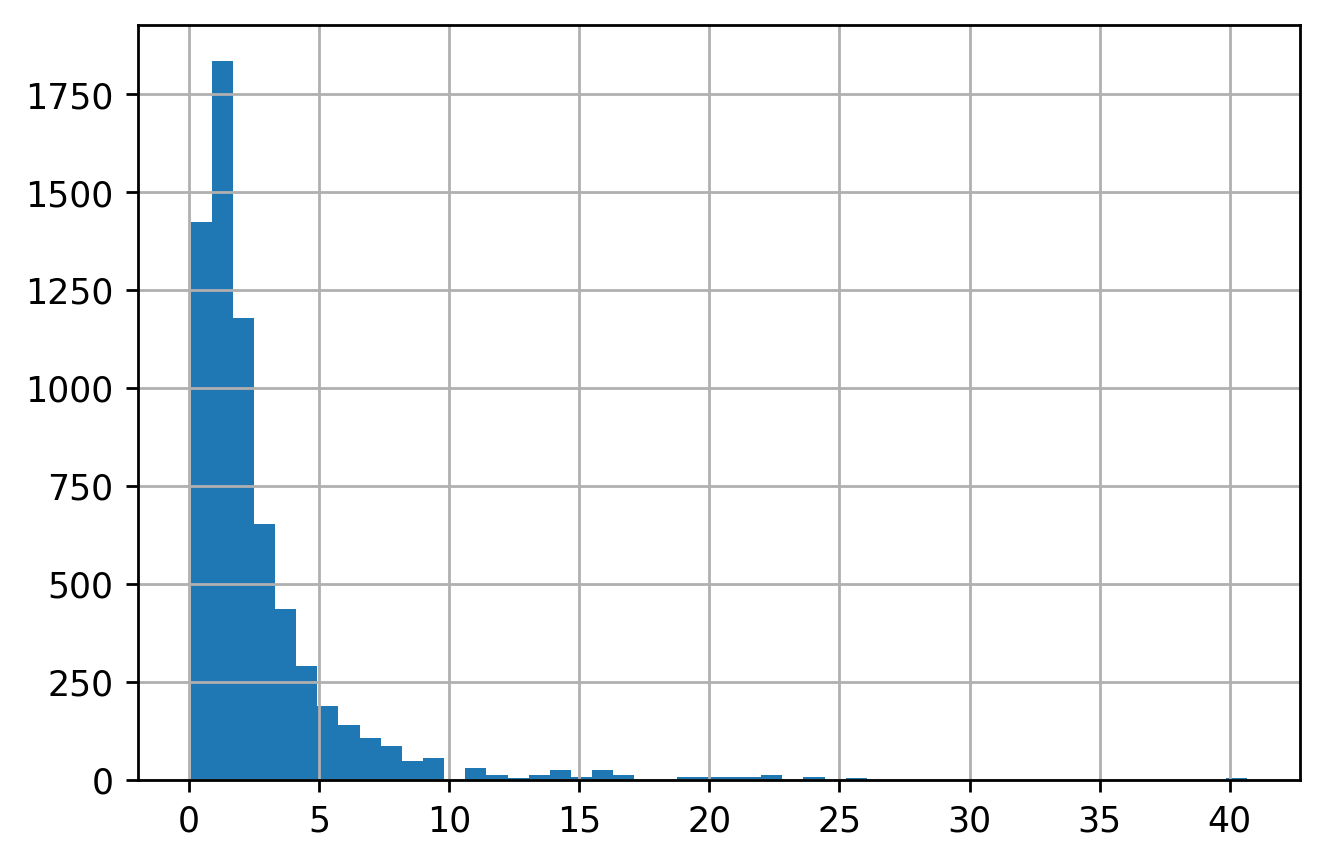

In [371]:
plt.figure(dpi=250)
complete_corrected_data['Distances'].hist(bins=50)

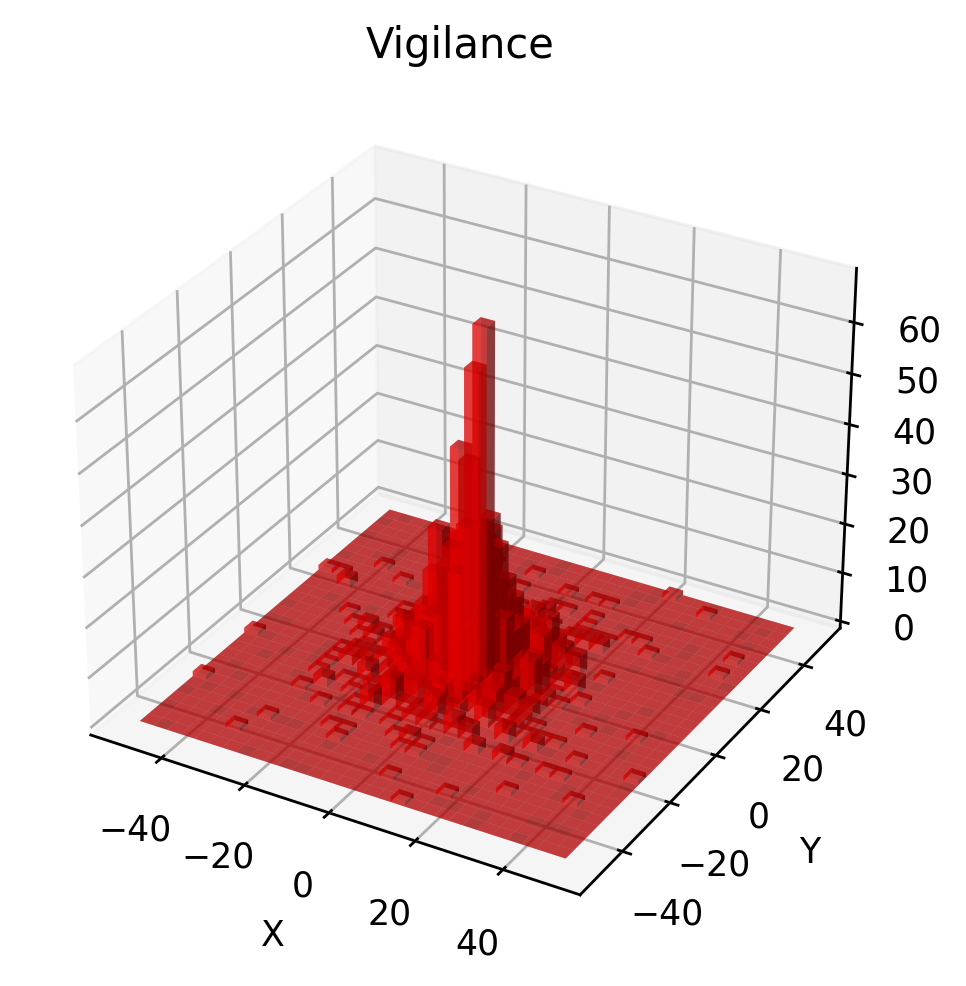

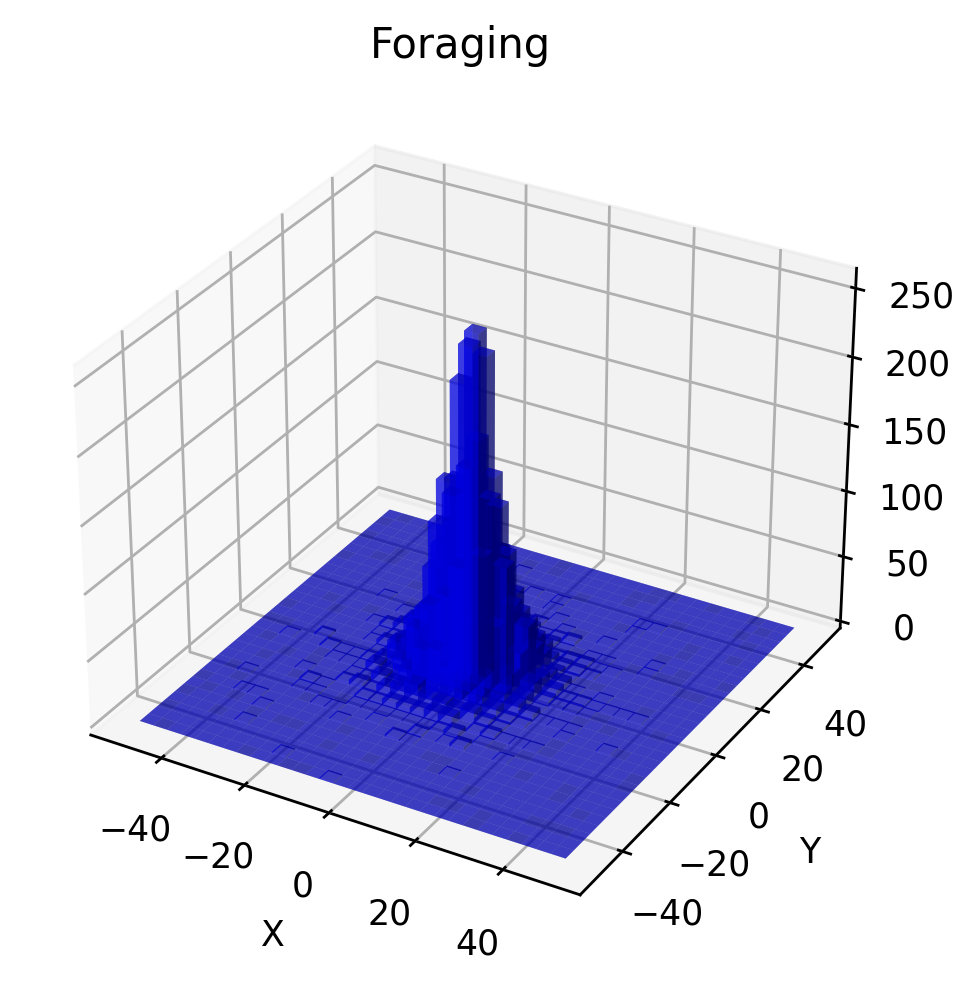

In [213]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib.cm as cm


for i in ['Vigilance','Foraging']:
    
    fig = plt.figure(dpi=250) #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection='3d')
    
    x = complete_corrected_data.loc[complete_corrected_data['Behavior']==i,'Rel_X']
    y = complete_corrected_data.loc[complete_corrected_data['Behavior']==i,'Rel_Y']

    XY = np.stack((x,y),axis=-1)

    xAmplitudes = np.array(XY)[:,0]
    yAmplitudes = np.array(XY)[:,1]

    
    hist, xedges, yedges = np.histogram2d(x, y, bins=(30,30), range = [[-50,+50],[-50,+50]]) 
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])

    xpos = xpos.flatten()*1./2
    ypos = ypos.flatten()*1./2
    zpos = np.zeros_like (xpos)

    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = hist.flatten()

    cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 
    if i == 'Foraging':
        colors = 'b'
    else:
        colors = 'r'
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=colors, zsort='average',label=str(i),alpha=0.5)   
    plt.title(i)
    plt.tight_layout()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


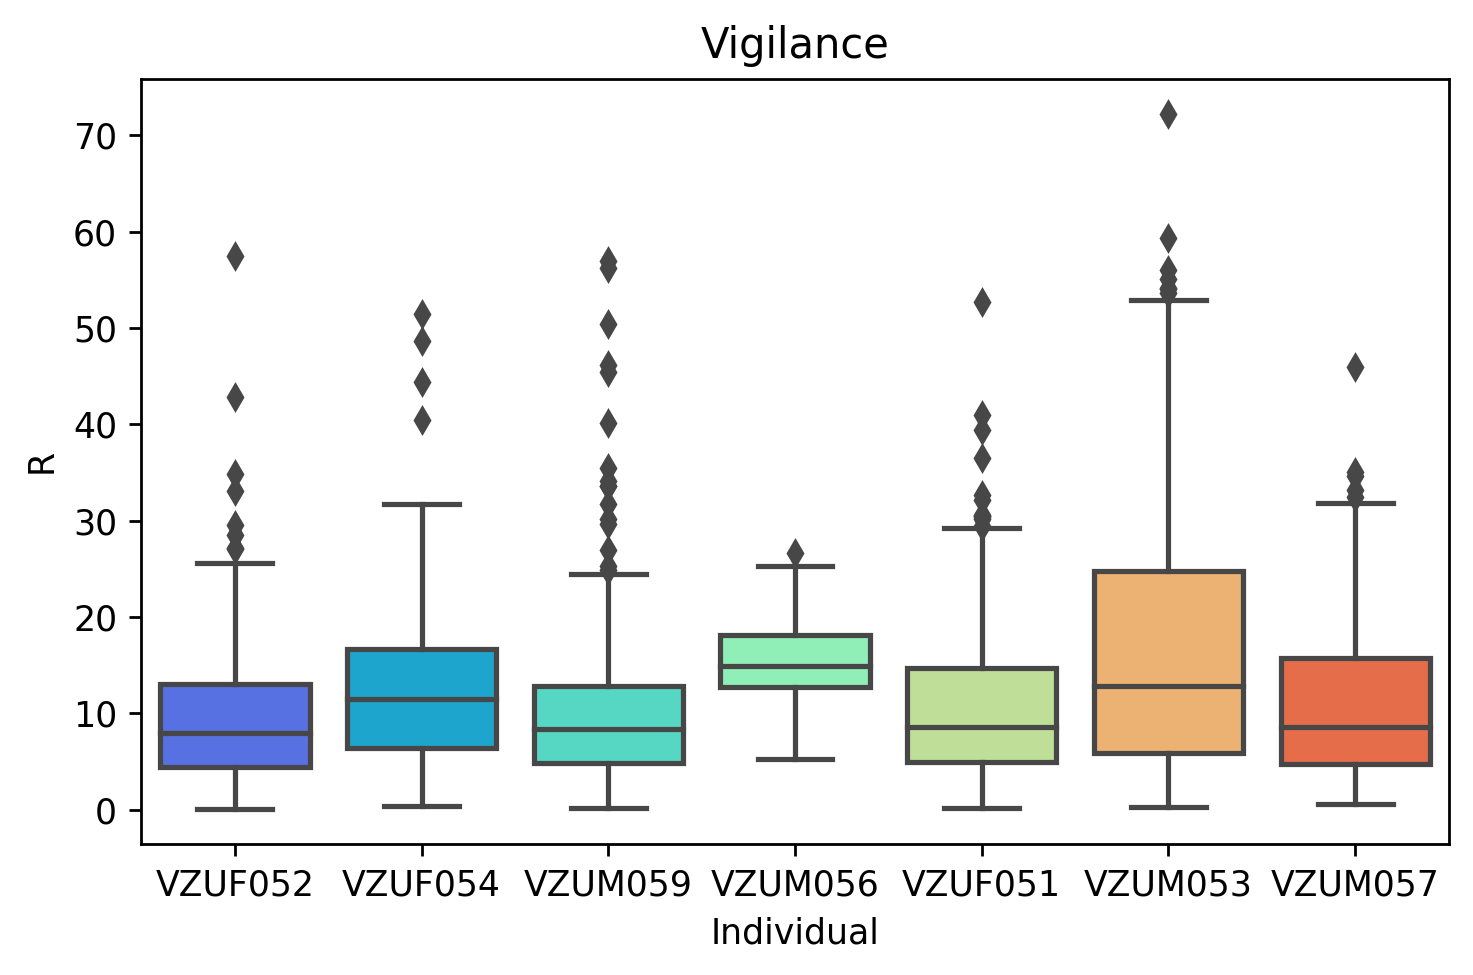

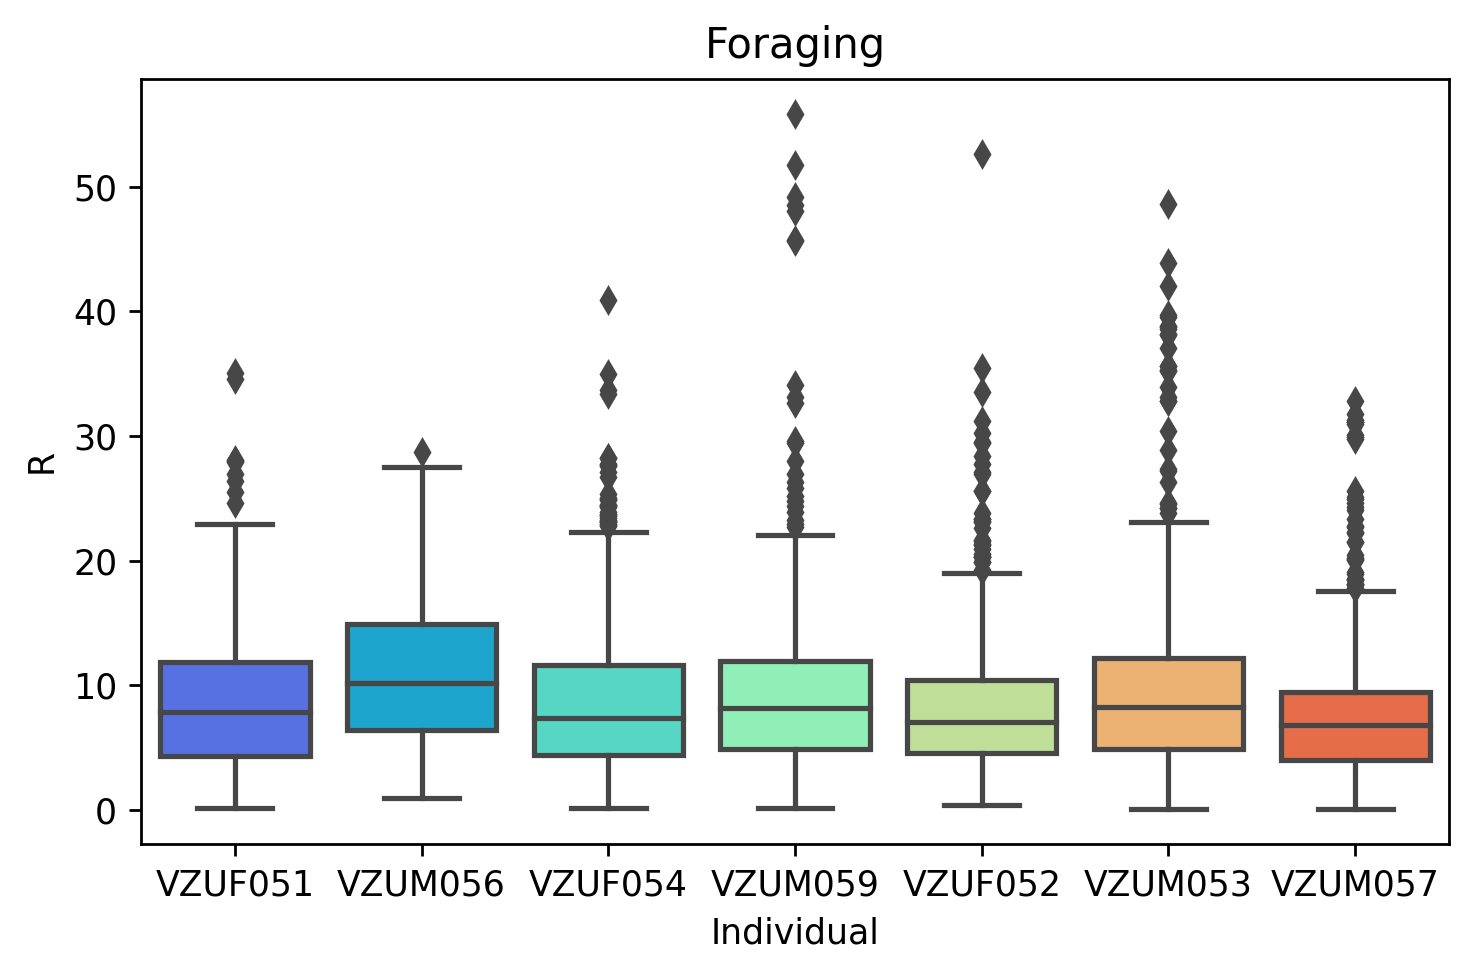

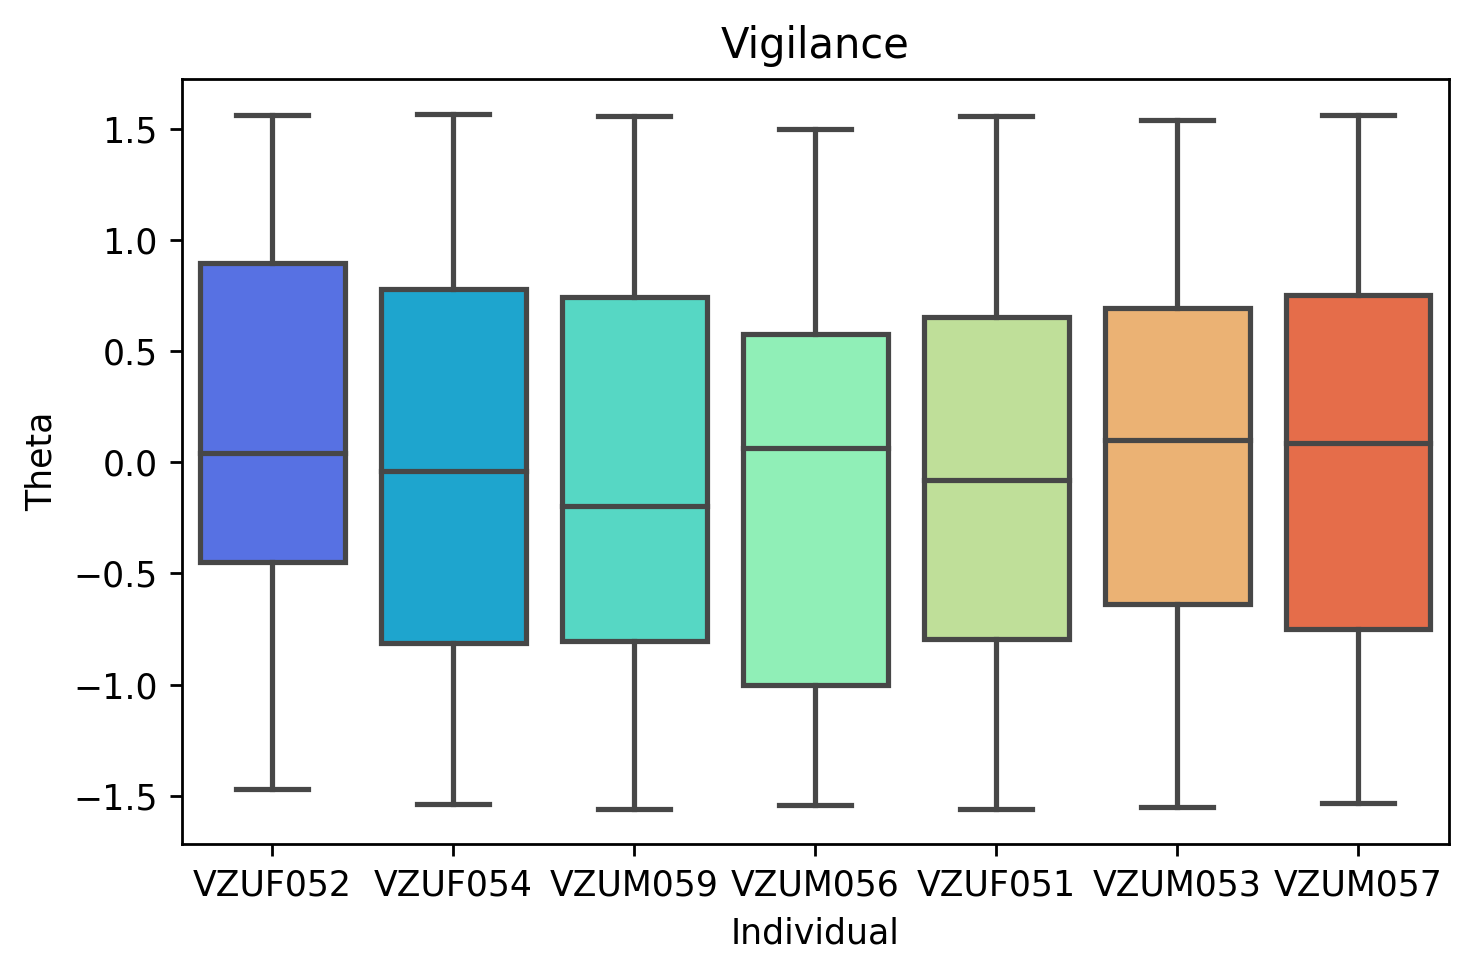

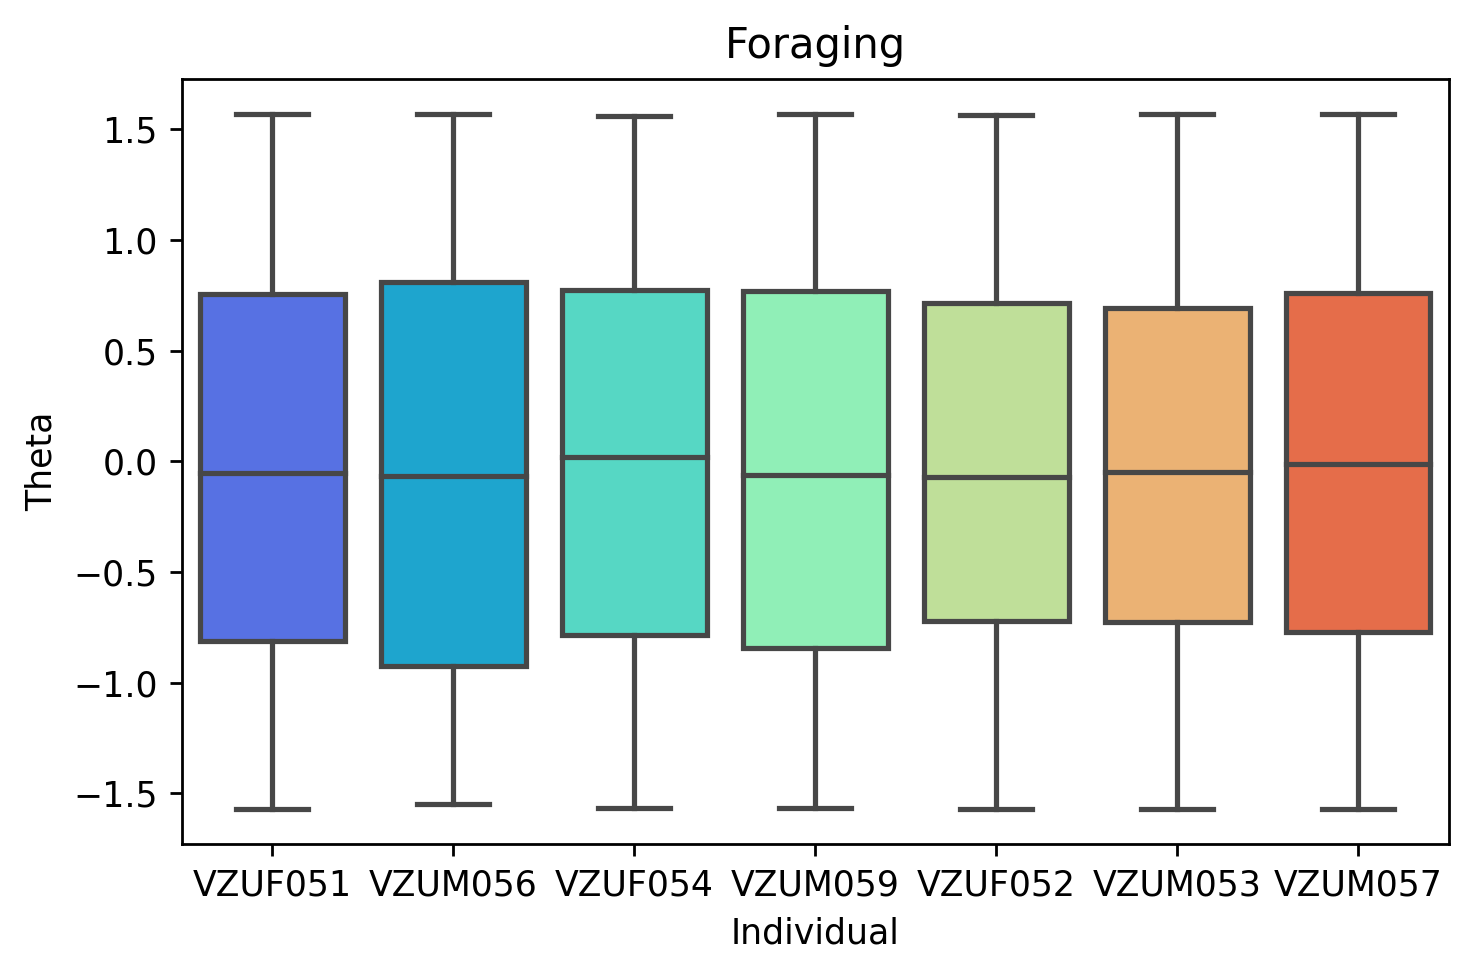

In [218]:
import seaborn as sns

for i in ['R','Theta']:
    for j in [vig_data,forage_data]:
        fig,ax = plt.subplots(dpi=250)
        sns.boxplot(x='Individual',y=i,data=j[['Individual',i]], palette='rainbow',showfliers=True)
        beh = j.iloc[0,1]
        plt.title(beh)
        plt.tight_layout()
        plt.show()

Bayesian Framework


In [372]:
vig_prior= {}
for i in complete_data['Individual'].unique():
    subset = complete_data.loc[complete_data['Individual']==i,'Behavior']
    vig_prior[i] = np.sum(subset=='Vigilance') / subset.shape[0]
vig_prior

{'VZUF051': 0.24627847400124628,
 'VZUF052': 0.14870161346167163,
 'VZUF054': 0.2722287613376722,
 'VZUM056': 0.11332405635762742,
 'VZUM059': 0.23985788113695092,
 'VZUM053': 0.17509388952466917,
 'VZUM057': 0.19683743975845316}

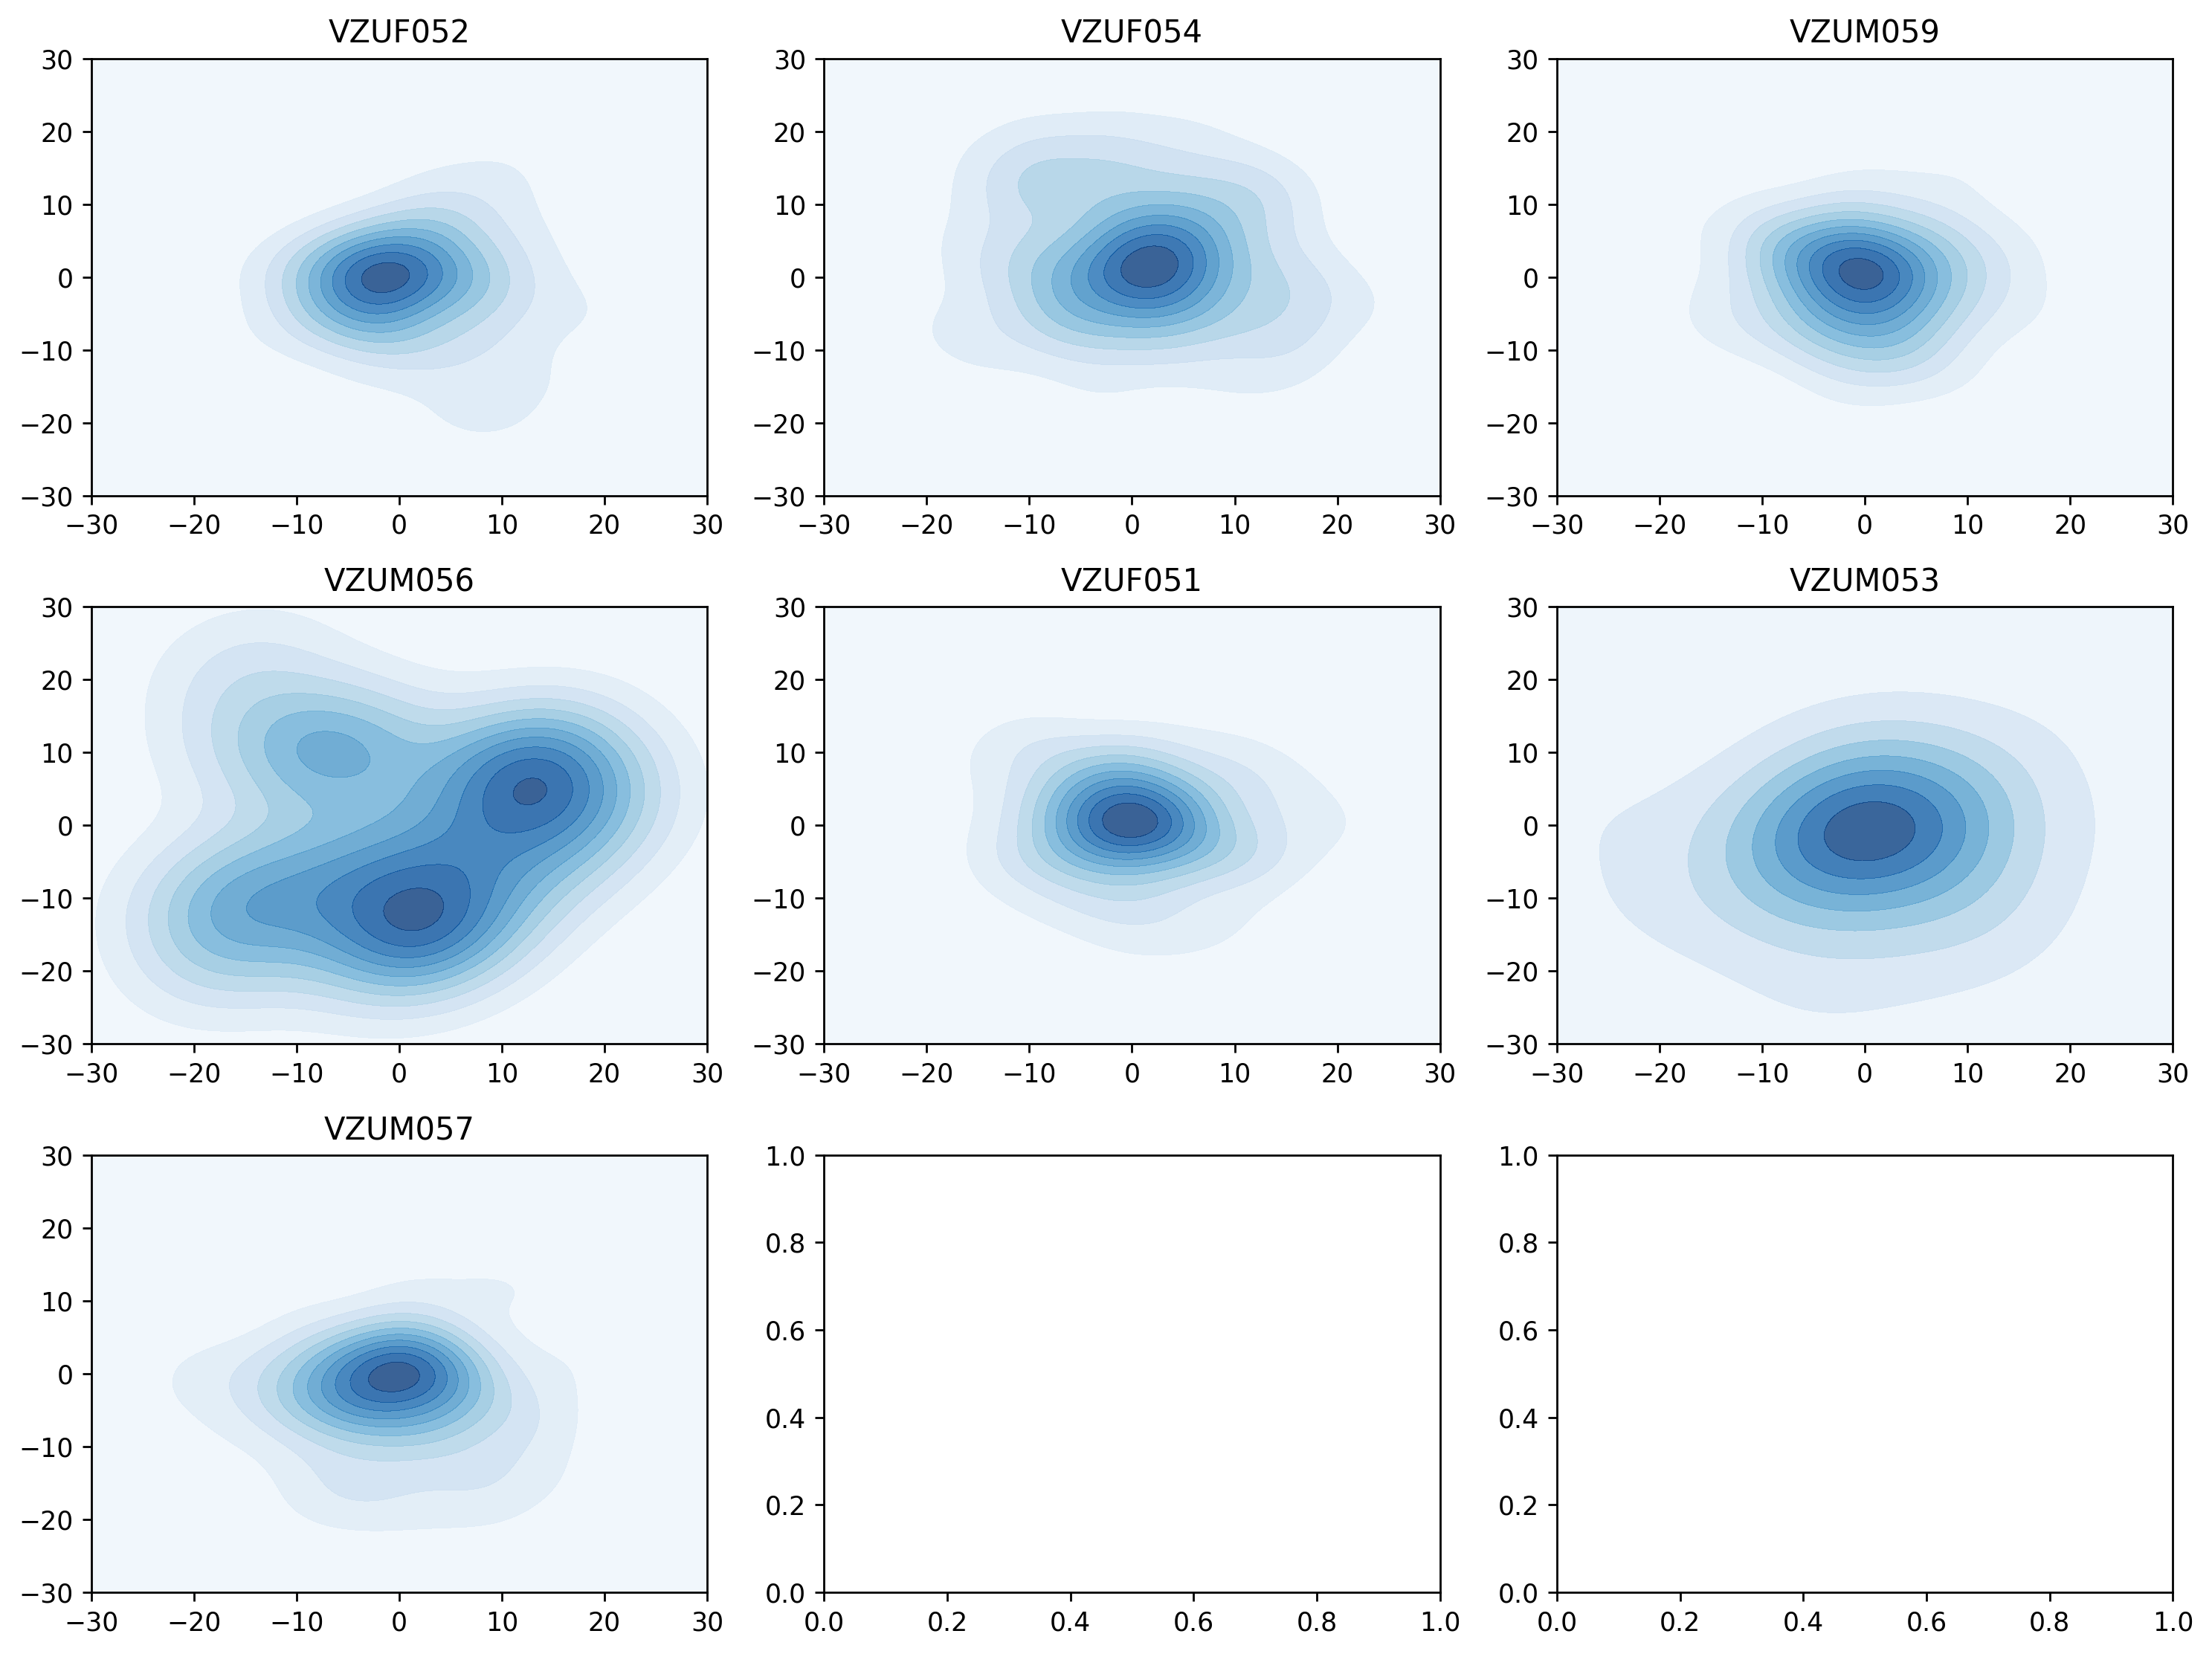

In [320]:
from scipy.stats import gaussian_kde
fig,axes = plt.subplots(nrows=3,ncols=3,dpi=250,figsize=(12,9))
axes = axes.flatten()
i=0
for ind in vig_data['Individual'].unique():
    x = vig_data.loc[vig_data['Individual']==ind,'Rel_X'].to_numpy()
    y = vig_data.loc[vig_data['Individual']==ind,'Rel_Y'].to_numpy()

    X, Y = np.meshgrid(np.linspace(-30, 30, 100), np.linspace(-30, 30, 100))

    kde = gaussian_kde(np.vstack([x, y]))

    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    axes[i].contourf(X, Y, Z,10, alpha=.8,cmap=cm.Blues)
    axes[i].set_title(ind)
    i = i + 1
plt.tight_layout()
plt.show()


In [479]:
priors = complete_data.loc[complete_data['Behavior']=='Vigilance'].shape[0]/complete_data.shape[0]
subset = complete_corrected_data[complete_corrected_data['Distances']<10]
subset

Timestamp   Behavior Individual      Rel_X      Rel_Y  \
5   2021-05-17 08:10:57   Foraging    VZUF051  -7.718283   7.120236   
6   2021-05-17 08:10:57  Vigilance    VZUF052   7.091530   8.274183   
7   2021-05-17 08:10:57   Foraging    VZUF054  -3.563933   4.028599   
8   2021-05-17 08:10:57   Foraging    VZUM056  11.007938 -21.020245   
9   2021-05-17 08:10:57   Foraging    VZUM059  -7.112999   1.376178   
..                  ...        ...        ...        ...        ...   
845 2021-05-23 10:57:18   Foraging    VZUF051   5.336298  -6.032935   
846 2021-05-23 10:57:18   Foraging    VZUF052  -0.777003   8.379570   
847 2021-05-23 10:57:18  Vigilance    VZUF054 -15.345529   5.849868   
848 2021-05-23 10:57:18   Foraging    VZUM053  10.560998 -11.994672   
849 2021-05-23 10:57:18   Foraging    VZUM057  -0.408469   1.574606   

     Distances  X_zscore  Y_zscore     Theta          R  
5     0.073845 -0.998294  0.665705 -0.745116  10.500936  
6     0.073845  0.932021  0.772927  0.862214  10.897335  
7     0.073845 -0.456814  0.378437 -0.846522   5.378776  
8     0.073845  1.442487 -1.949048 -1.088383  23.728156  
9     0.073845 -0.919401  0.131979 -0.191112   7.244903  
..         ...       ...       ...       ...        ...  
845   0.462420  0.629822 -0.738628 -0.846596   8.054339  
846   0.462420 -0.074967  1.166358 -1.478335   8.415517  
847   0.462420 -1.754541  0.831992 -0.364204  16.422735  
848   0.462420  1.232166 -1.526627 -0.848874  15.981453  
849   0.462420 -0.032480  0.266905 -1.316981   1.626724  

[6441 rows x 10 columns]

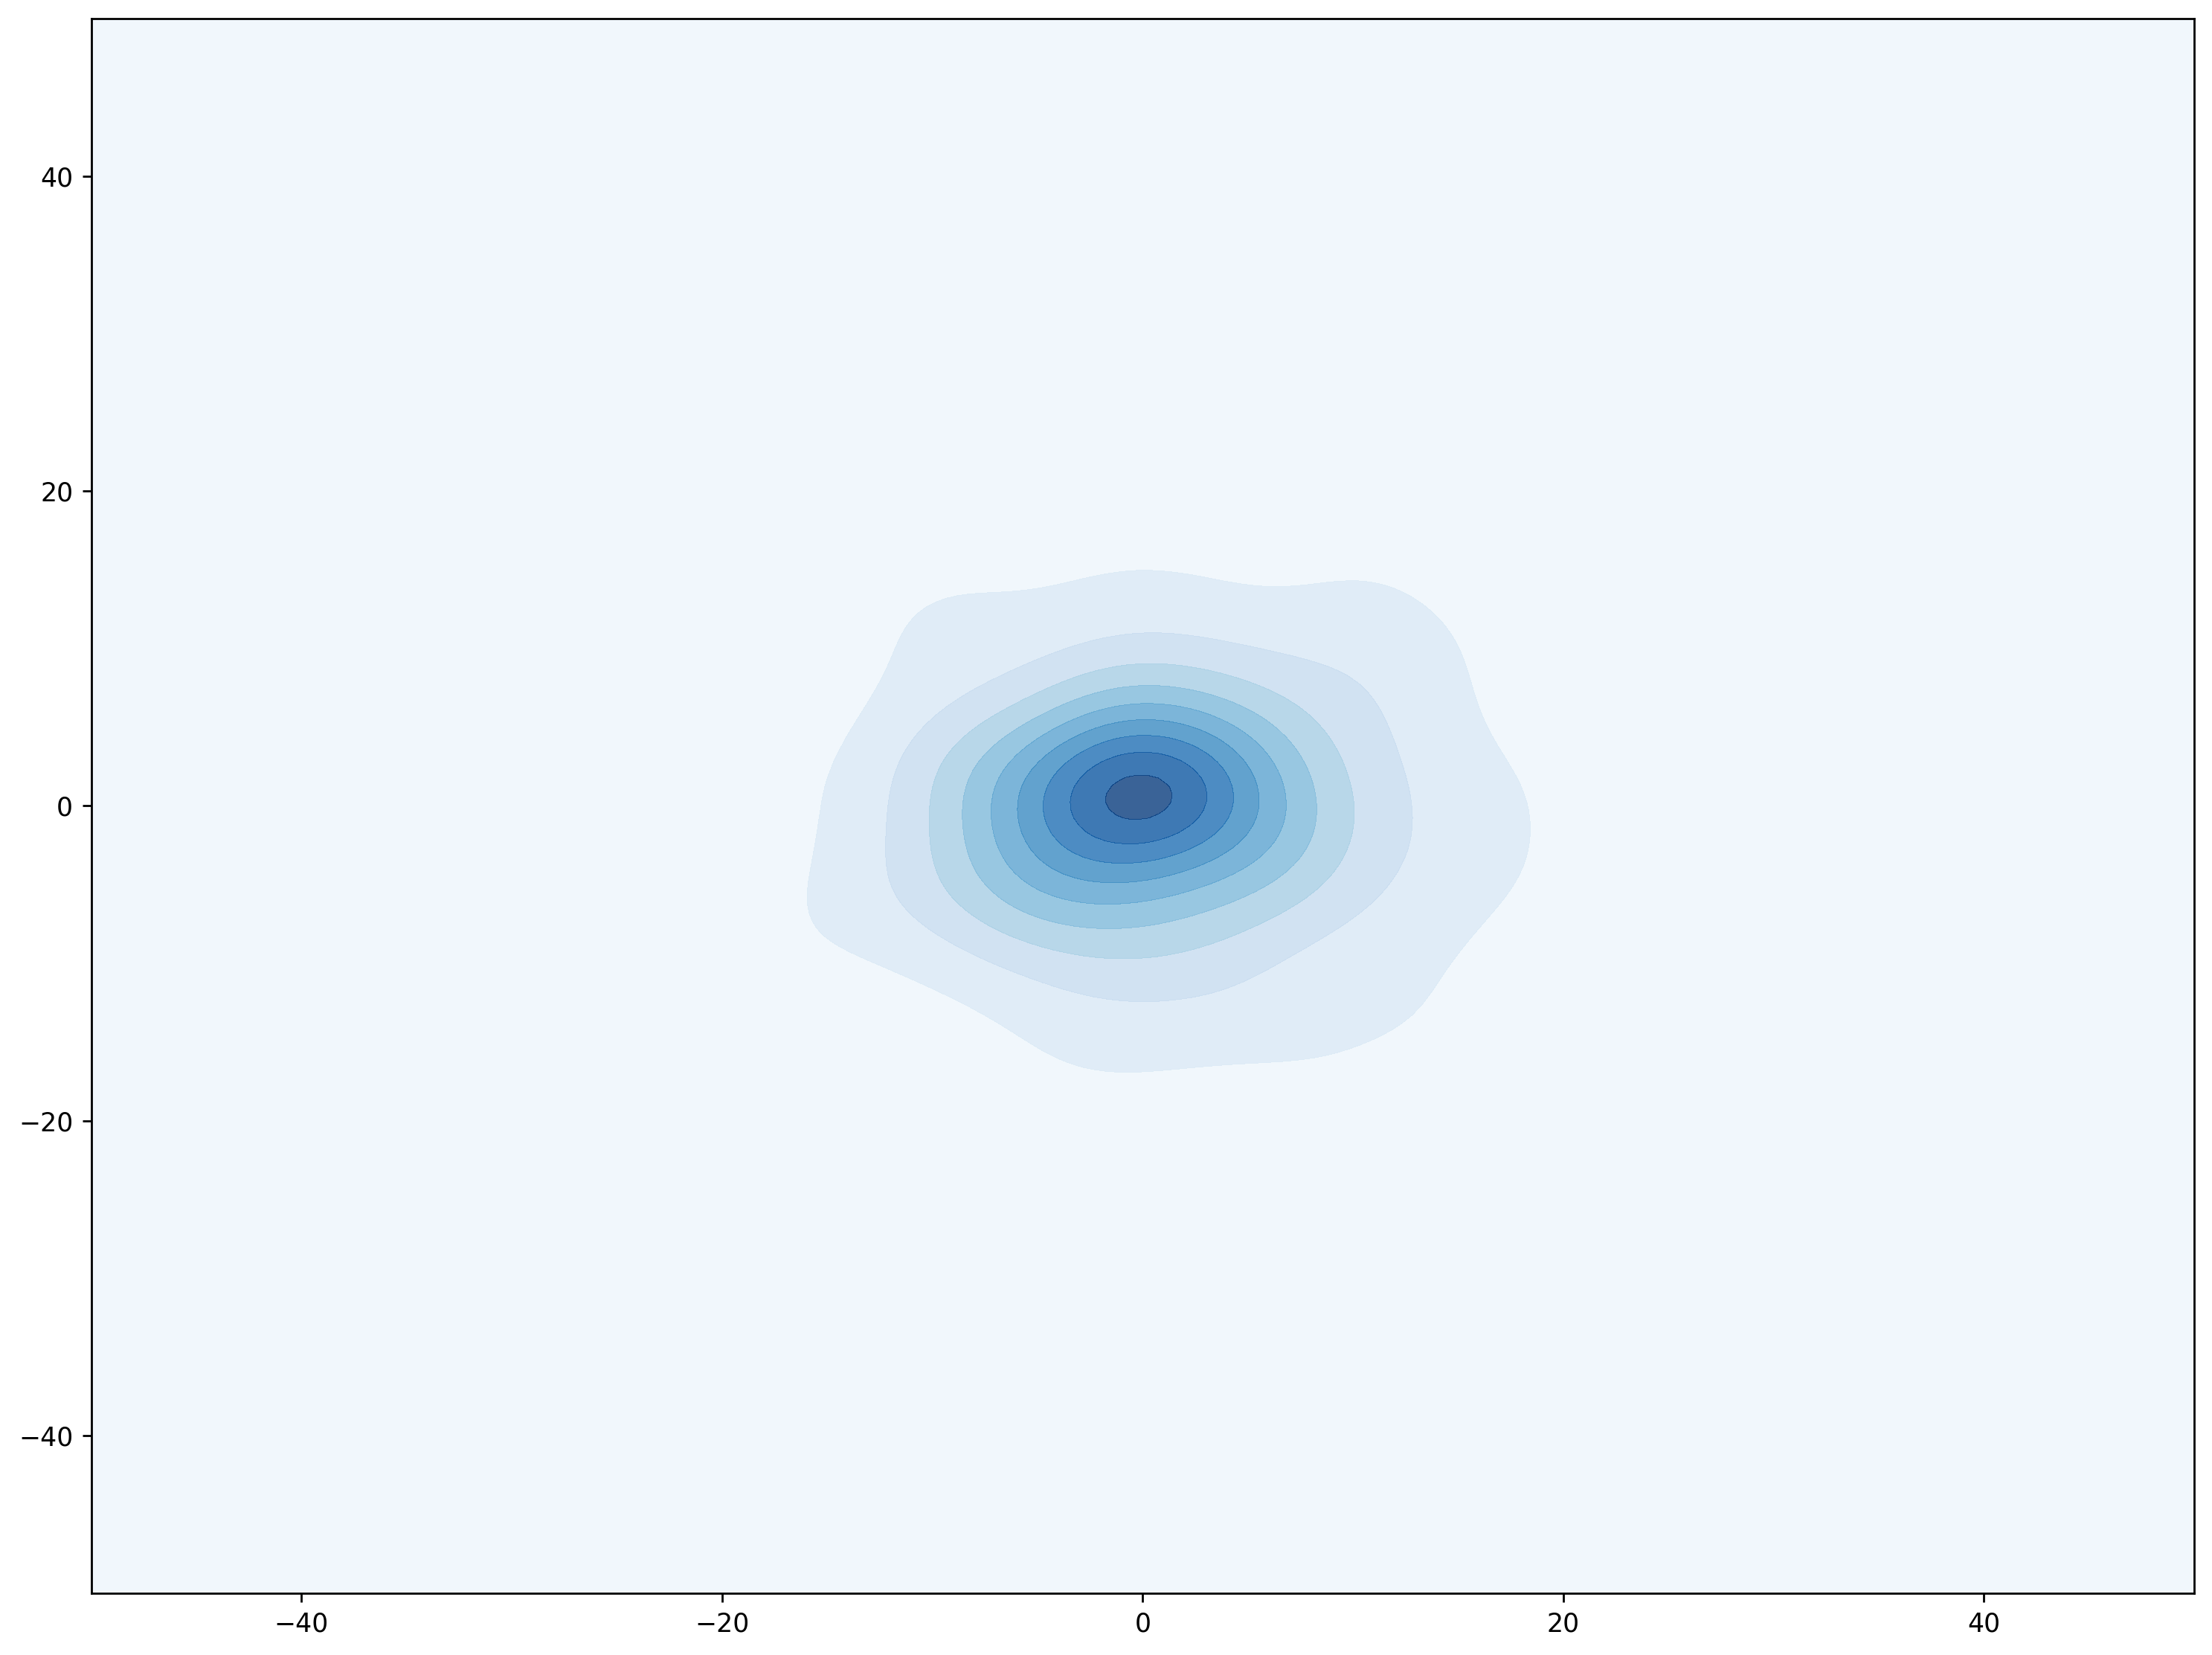

In [528]:
from scipy.stats import gaussian_kde
fig,axes = plt.subplots(dpi=250,figsize=(12,9))


x = subset.loc[subset['Behavior']=='Vigilance','Rel_X']
y = subset.loc[subset['Behavior']=='Vigilance','Rel_Y']

X, Y = np.meshgrid(np.linspace(-50, 50, 200), np.linspace(-50, 50, 200))

kde = gaussian_kde(np.vstack([x, y]))

P_vig_pos = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
axes.contourf(X, Y, P_vig_pos,10, alpha=.8,cmap=cm.Blues)


plt.tight_layout()
plt.show()

P(X) Group

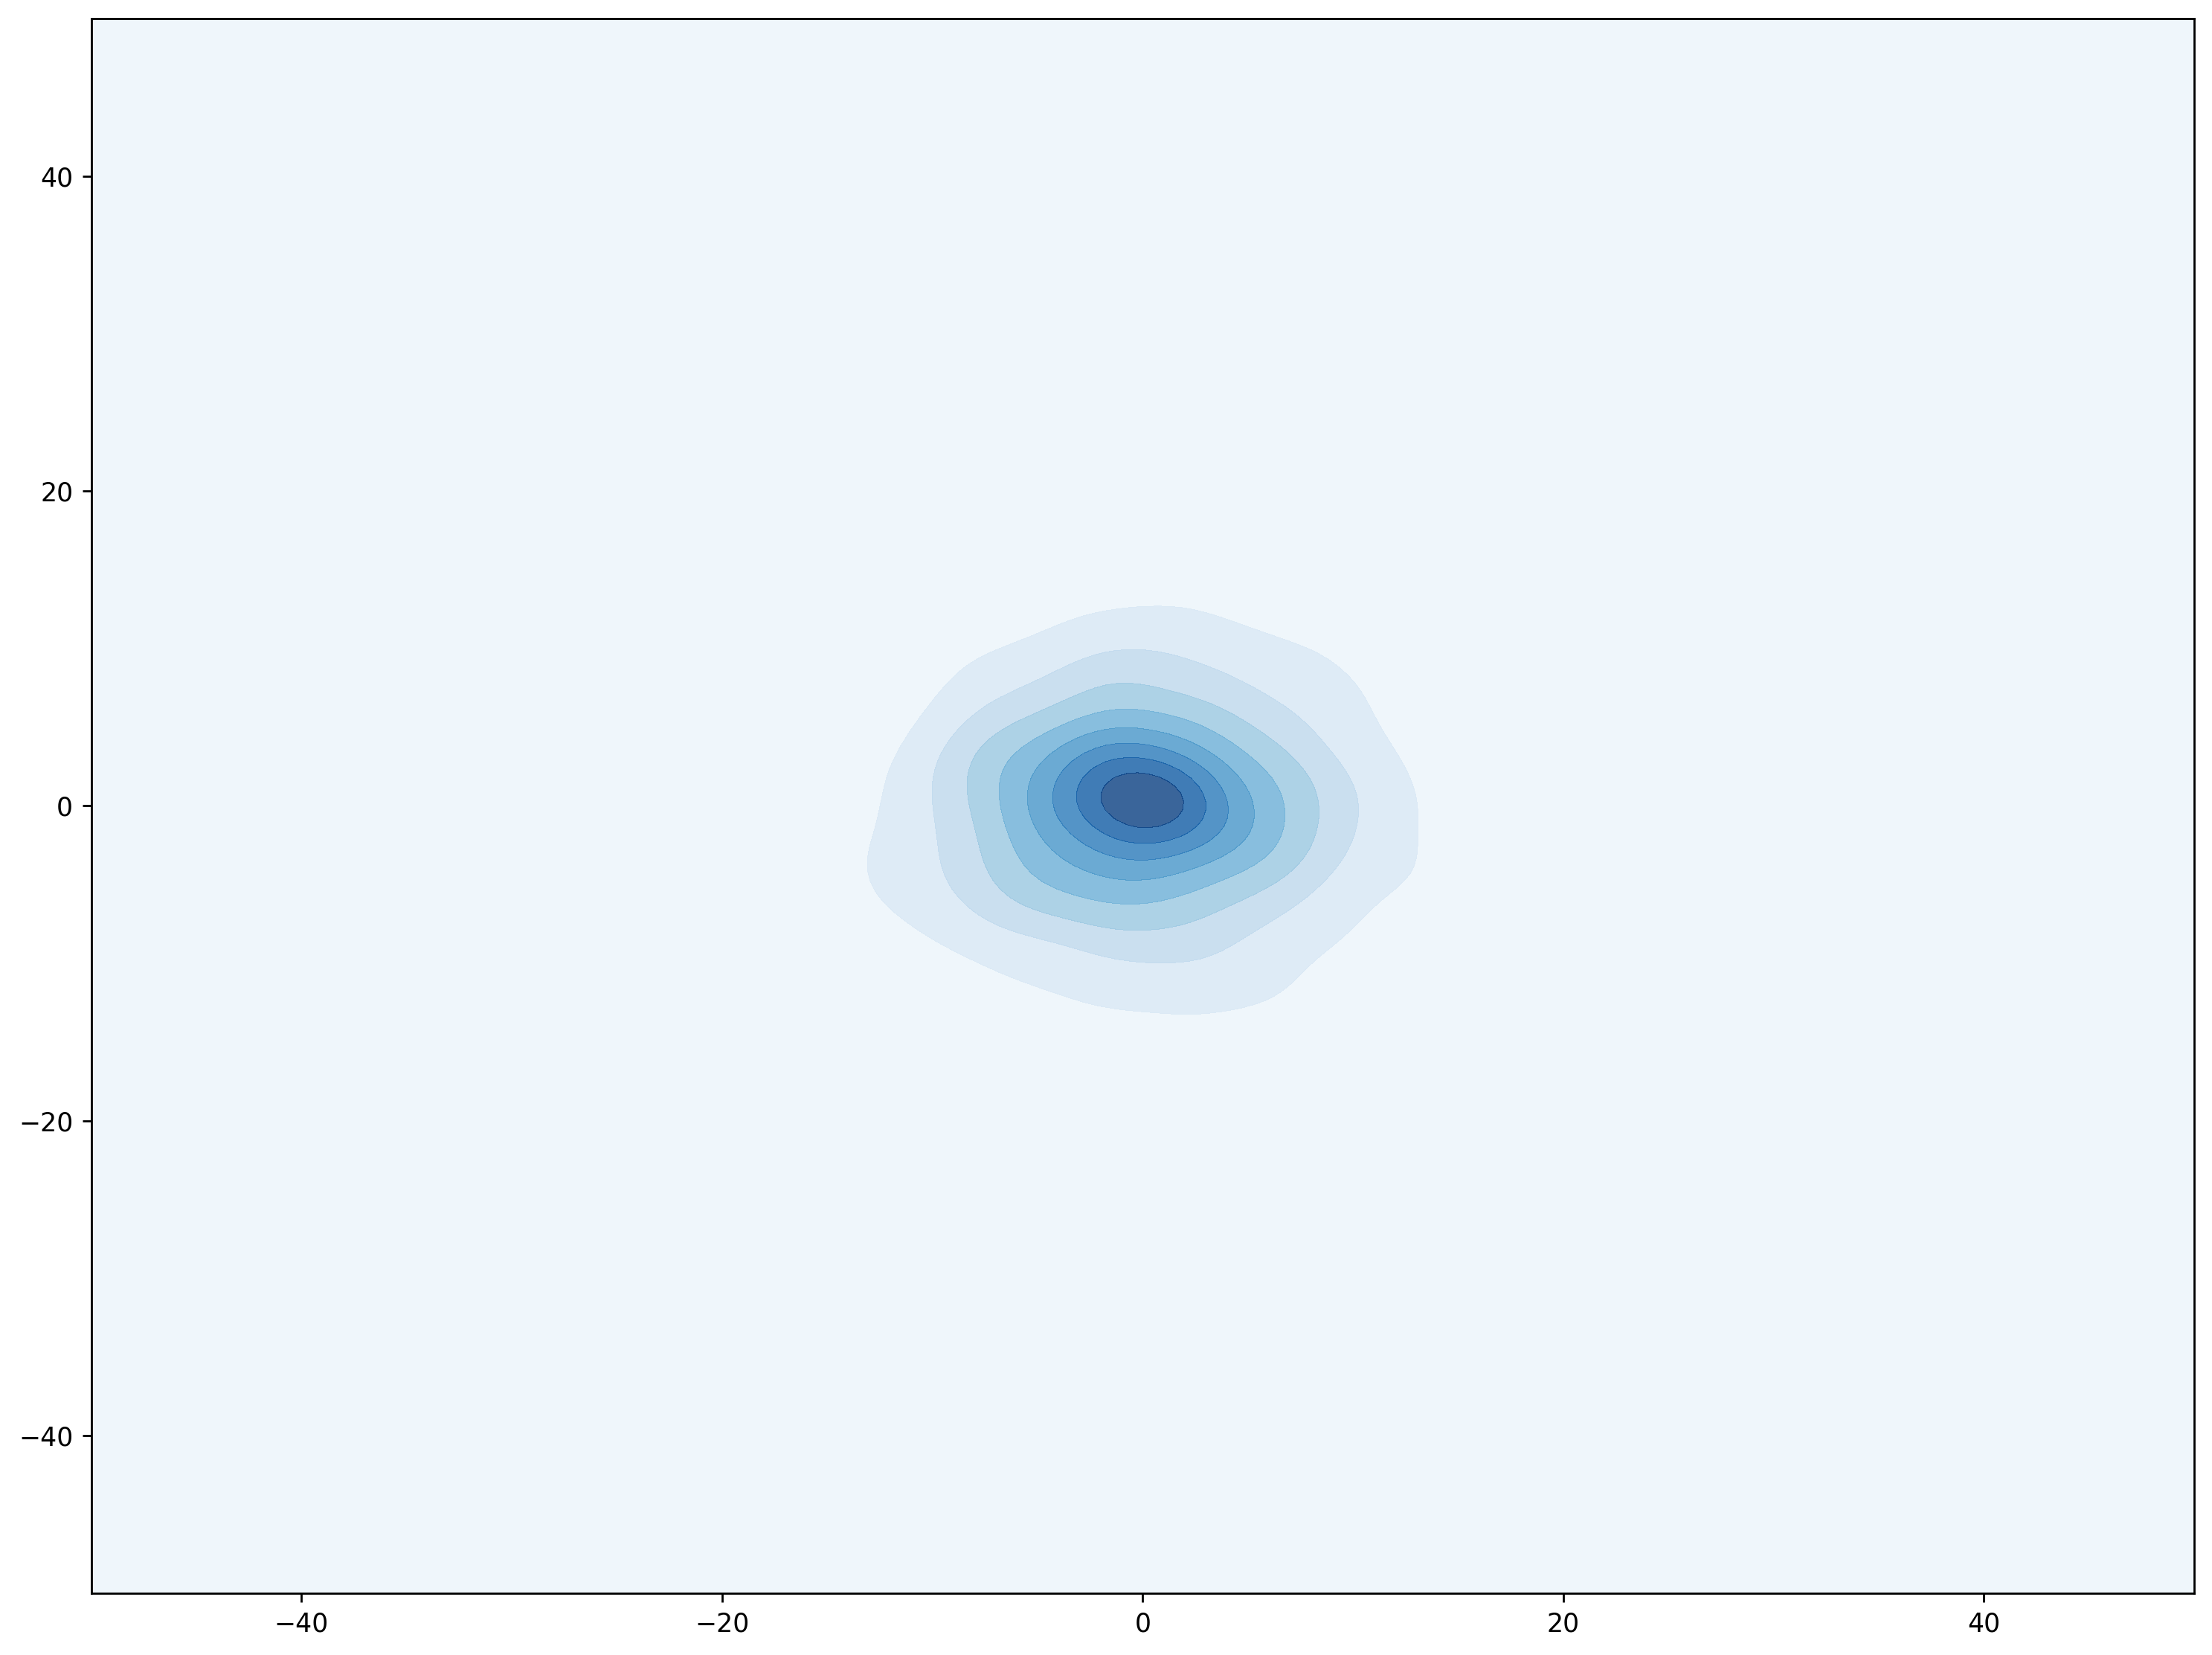

In [529]:
from scipy.stats import gaussian_kde
fig,axes = plt.subplots(dpi=250,figsize=(12,9))


x = subset['Rel_X']
y = subset['Rel_Y']

X, Y = np.meshgrid(np.linspace(-50, 50, 200), np.linspace(-50, 50, 200))

kde = gaussian_kde(np.vstack([x, y]))

P_group_pos = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
axes.contourf(X, Y, P_group_pos,10, alpha=.8,cmap=cm.Blues)


plt.tight_layout()
plt.show()

In [511]:
c=0.001
P_vig_X = np.divide(P_vig_pos+c,P_group_pos+c) * priors
P_vig_X.shape

(100, 100)

In [526]:
P_vig_X.min()

0.12881164208208082

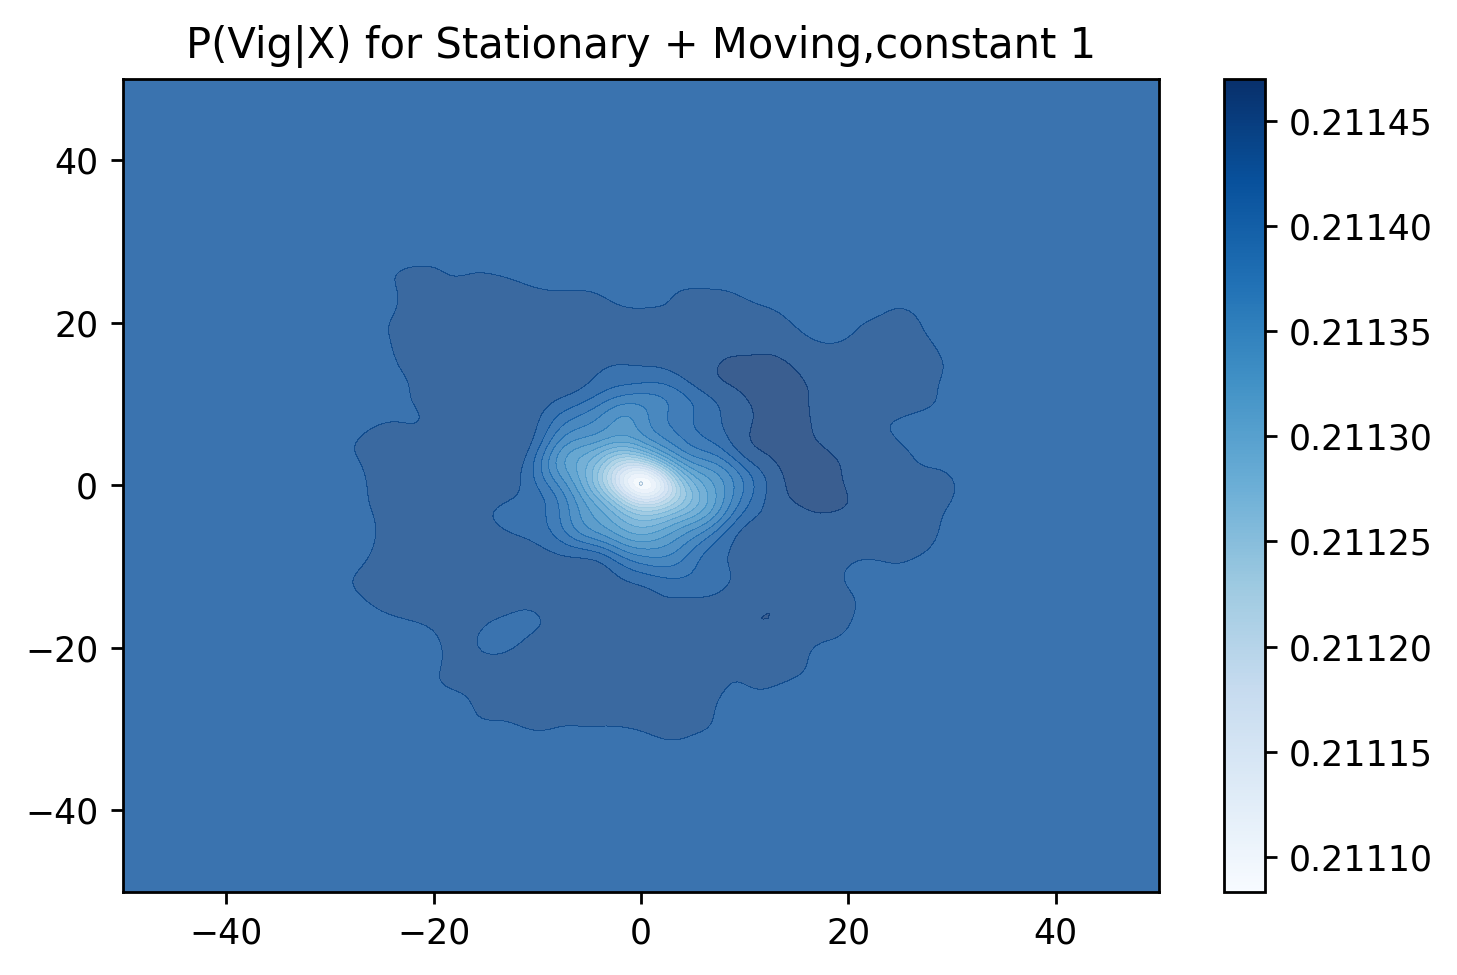

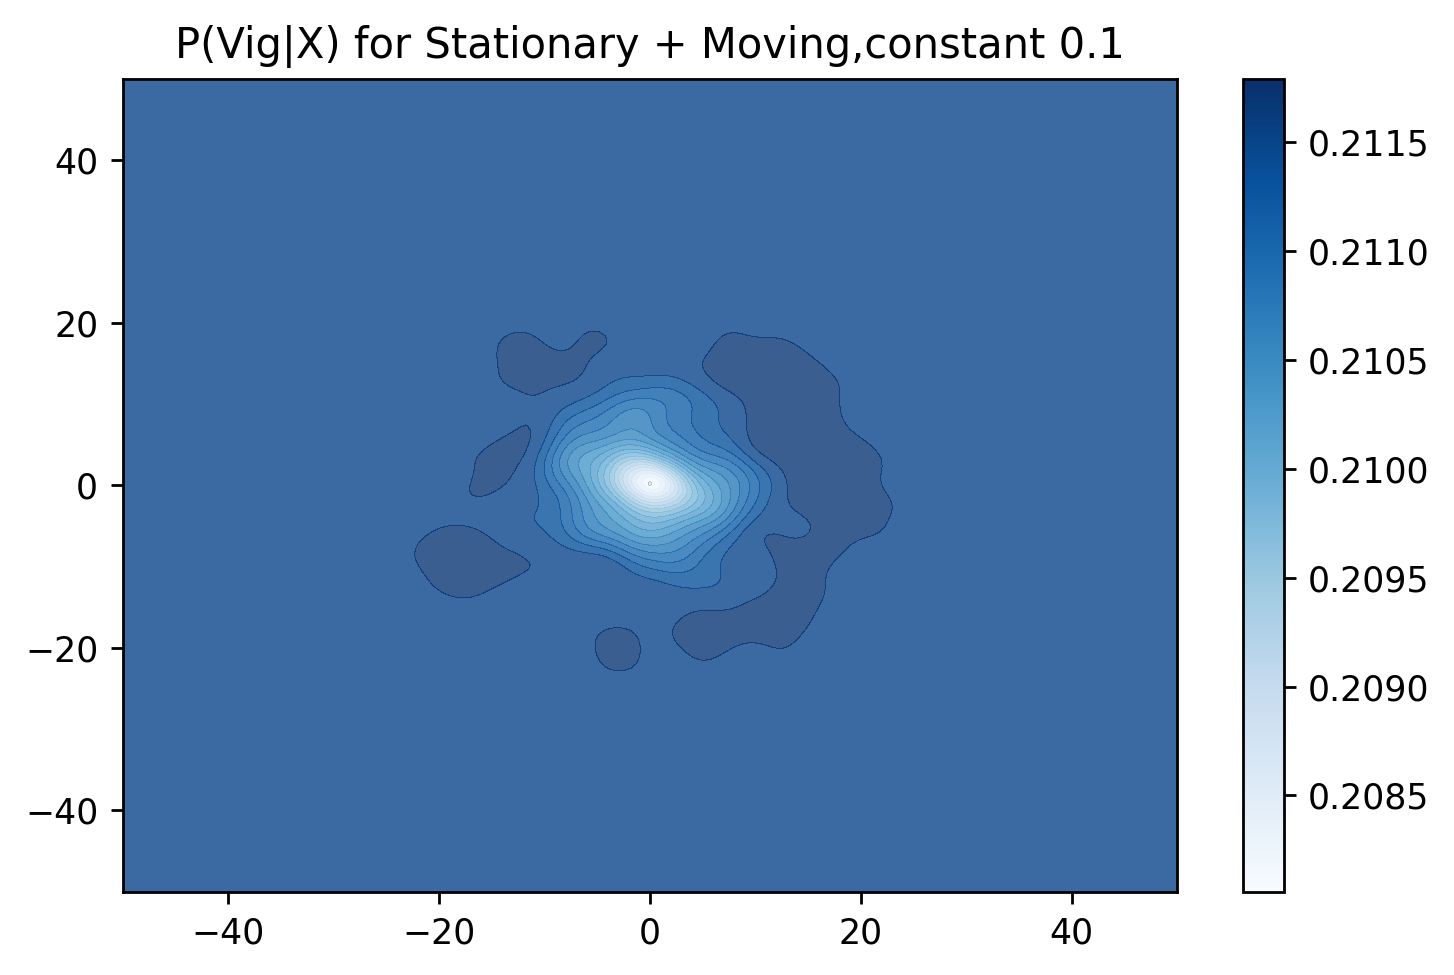

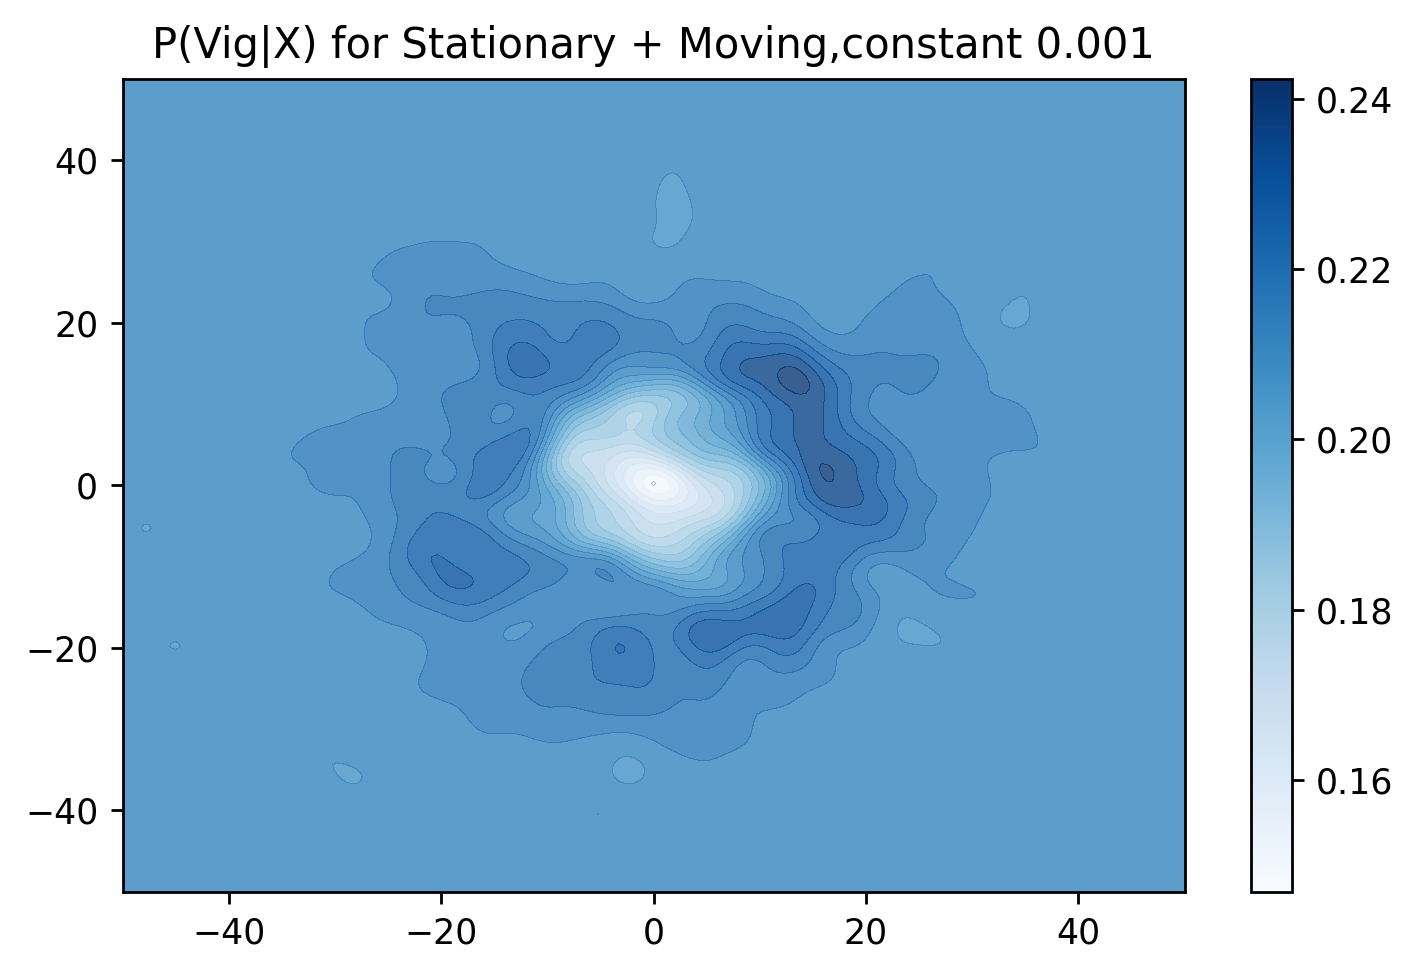

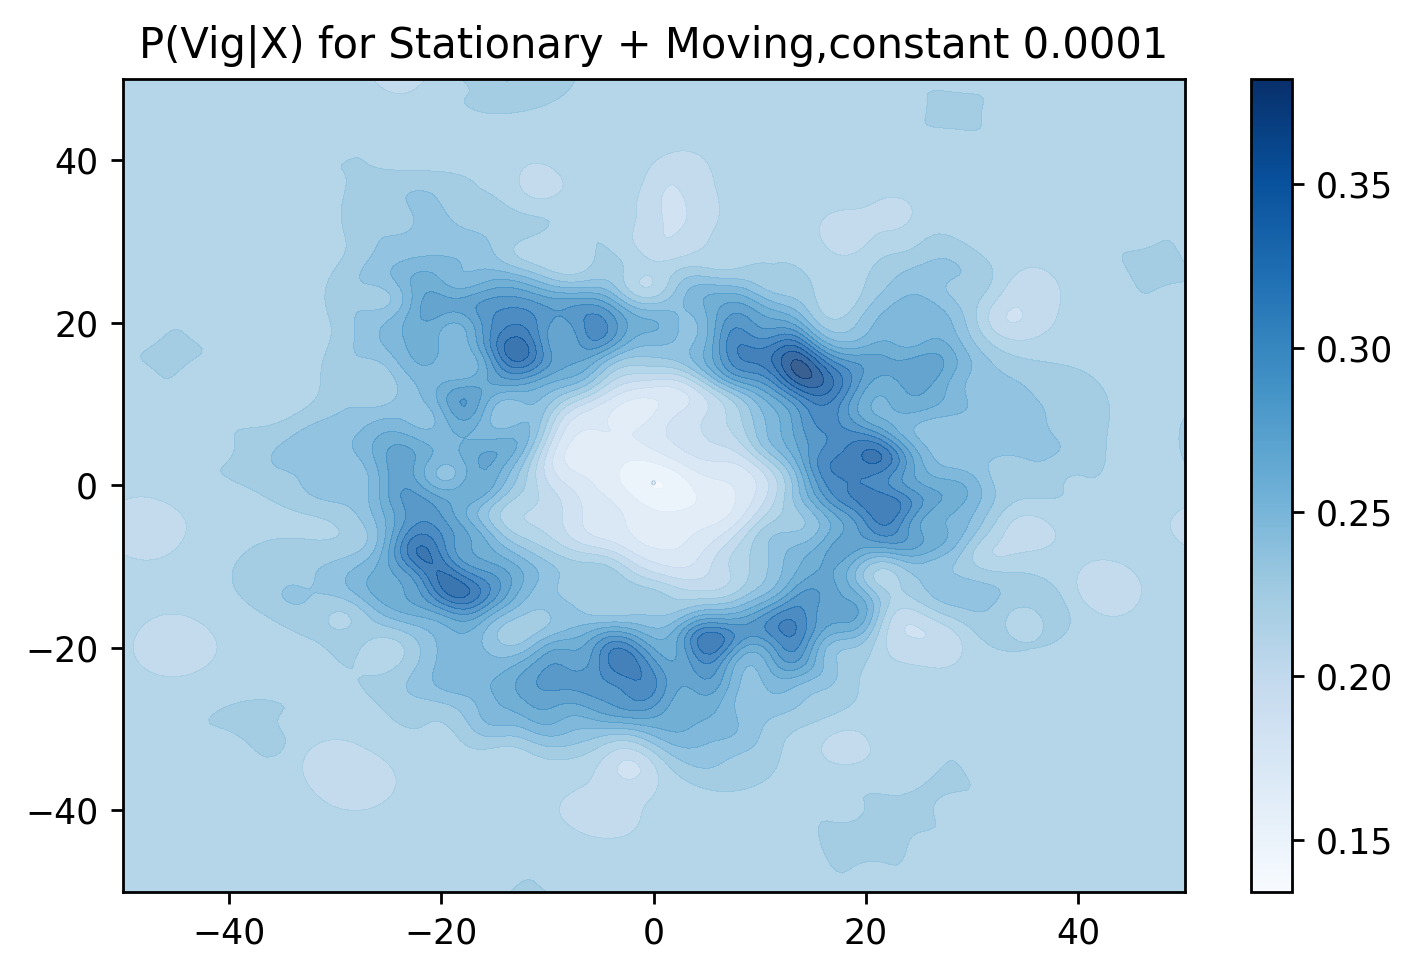

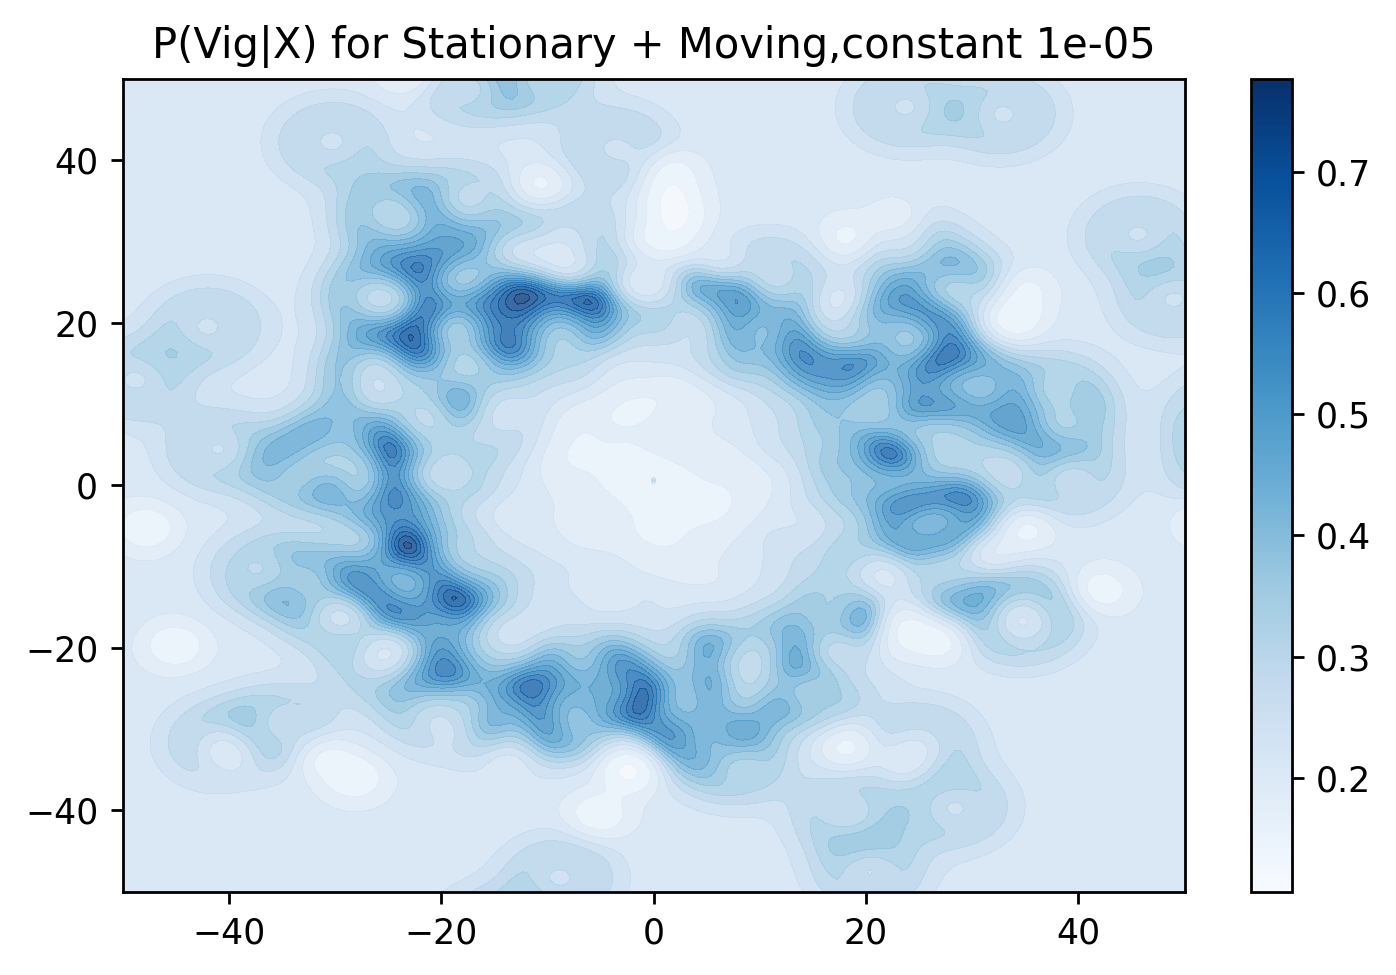

In [531]:
for c in [1,0.1,0.001,0.0001,0.00001]:

    P_vig_X = np.divide(P_vig_pos+c,P_group_pos+c) * priors
    fig,axes = plt.subplots(dpi=250)
    X, Y = np.meshgrid(np.linspace(-50, 50, 200), np.linspace(-50, 50, 200))




    axes.contourf(X, Y, P_vig_X,20, alpha=.8,cmap=cm.Blues)

    colors = np.linspace(np.min(P_vig_X),np.max(P_vig_X),20)
    mappable = plt.scatter(np.zeros(20), colors, s=0.0001, c=colors, cmap='Blues')
    plt.title('P(Vig|X) for Stationary + Moving,constant '+str(c))
    plt.colorbar(mappable)


    plt.tight_layout()
    plt.show()

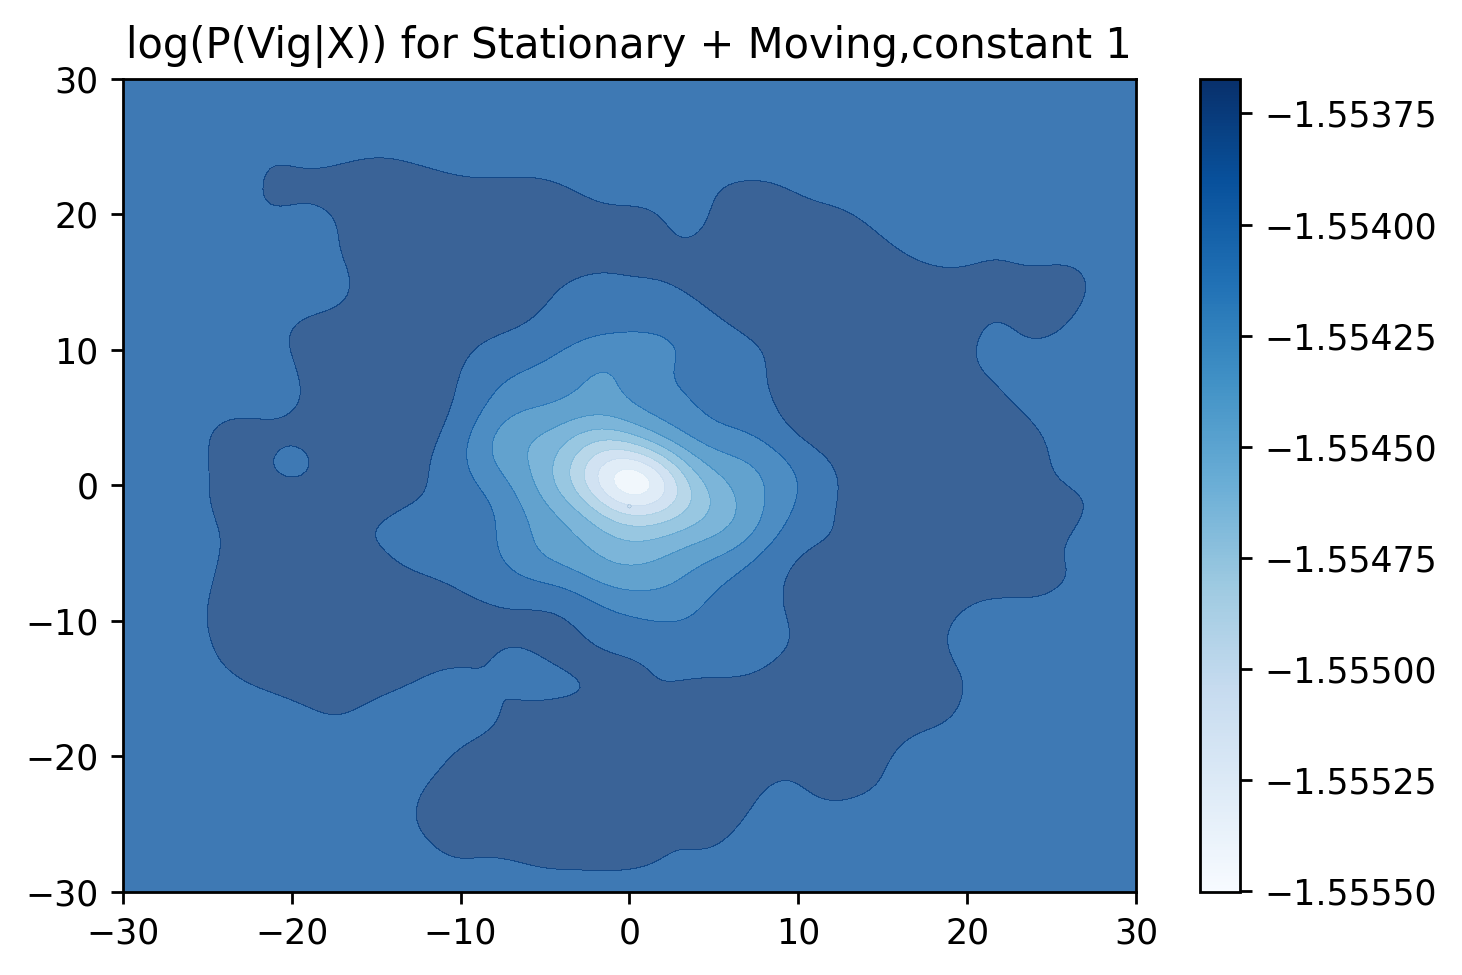

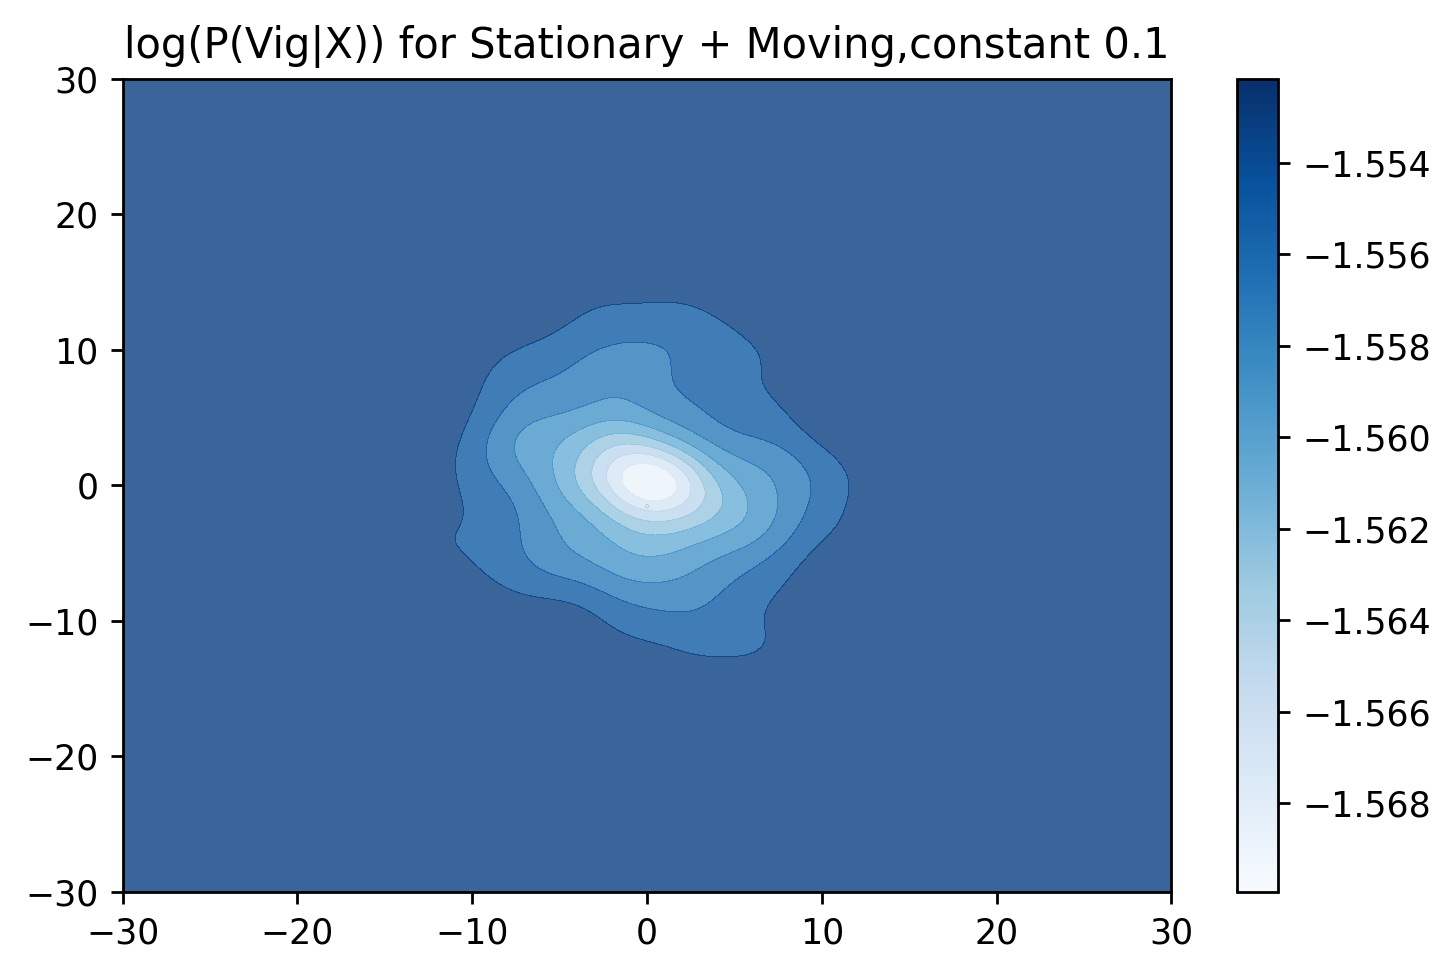

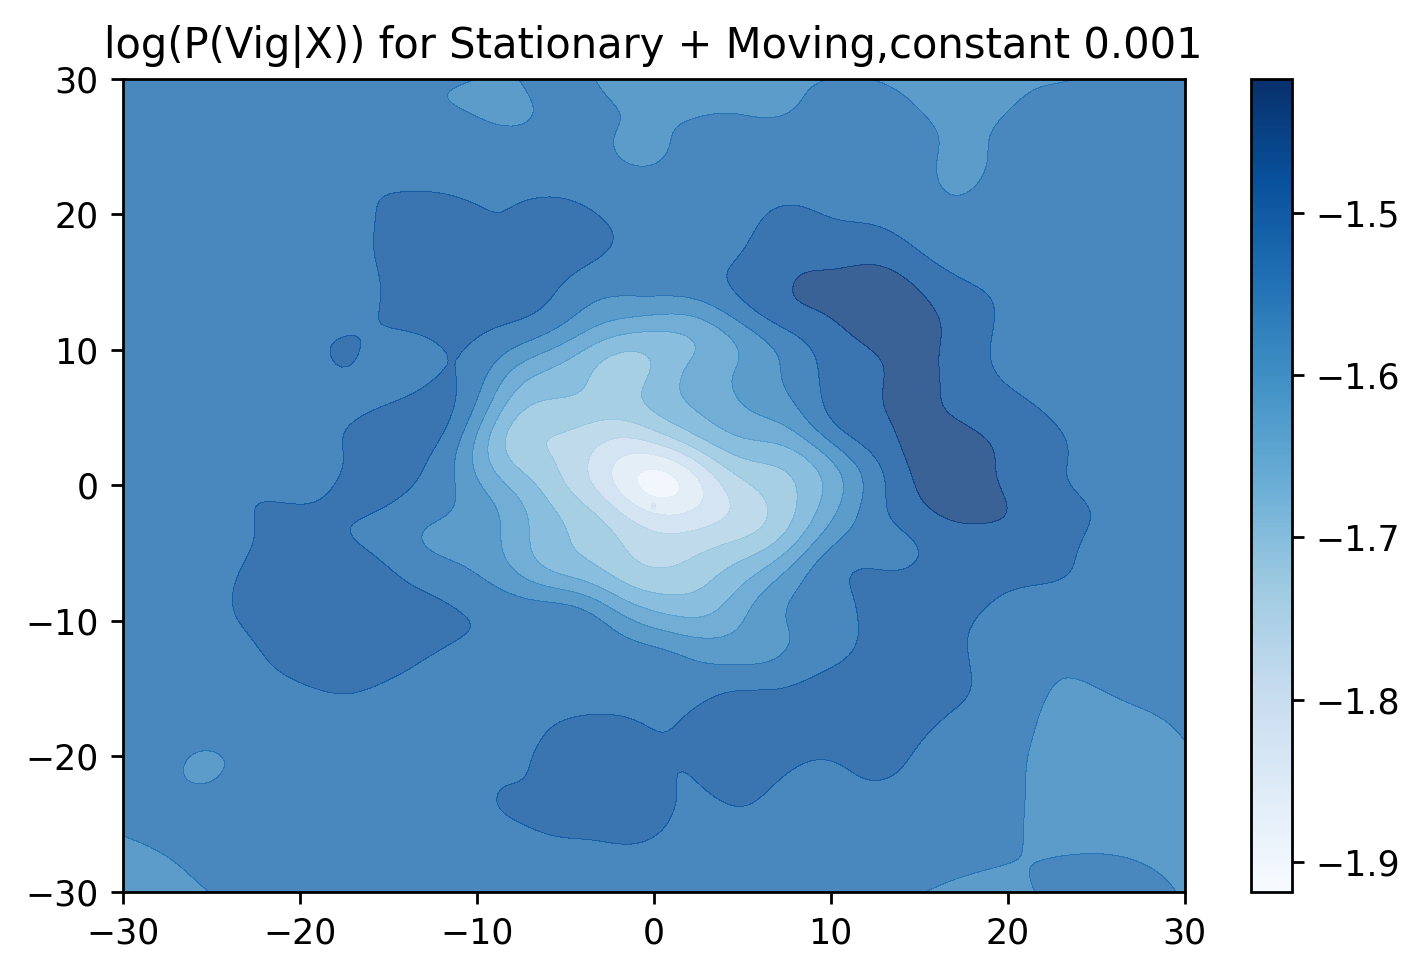

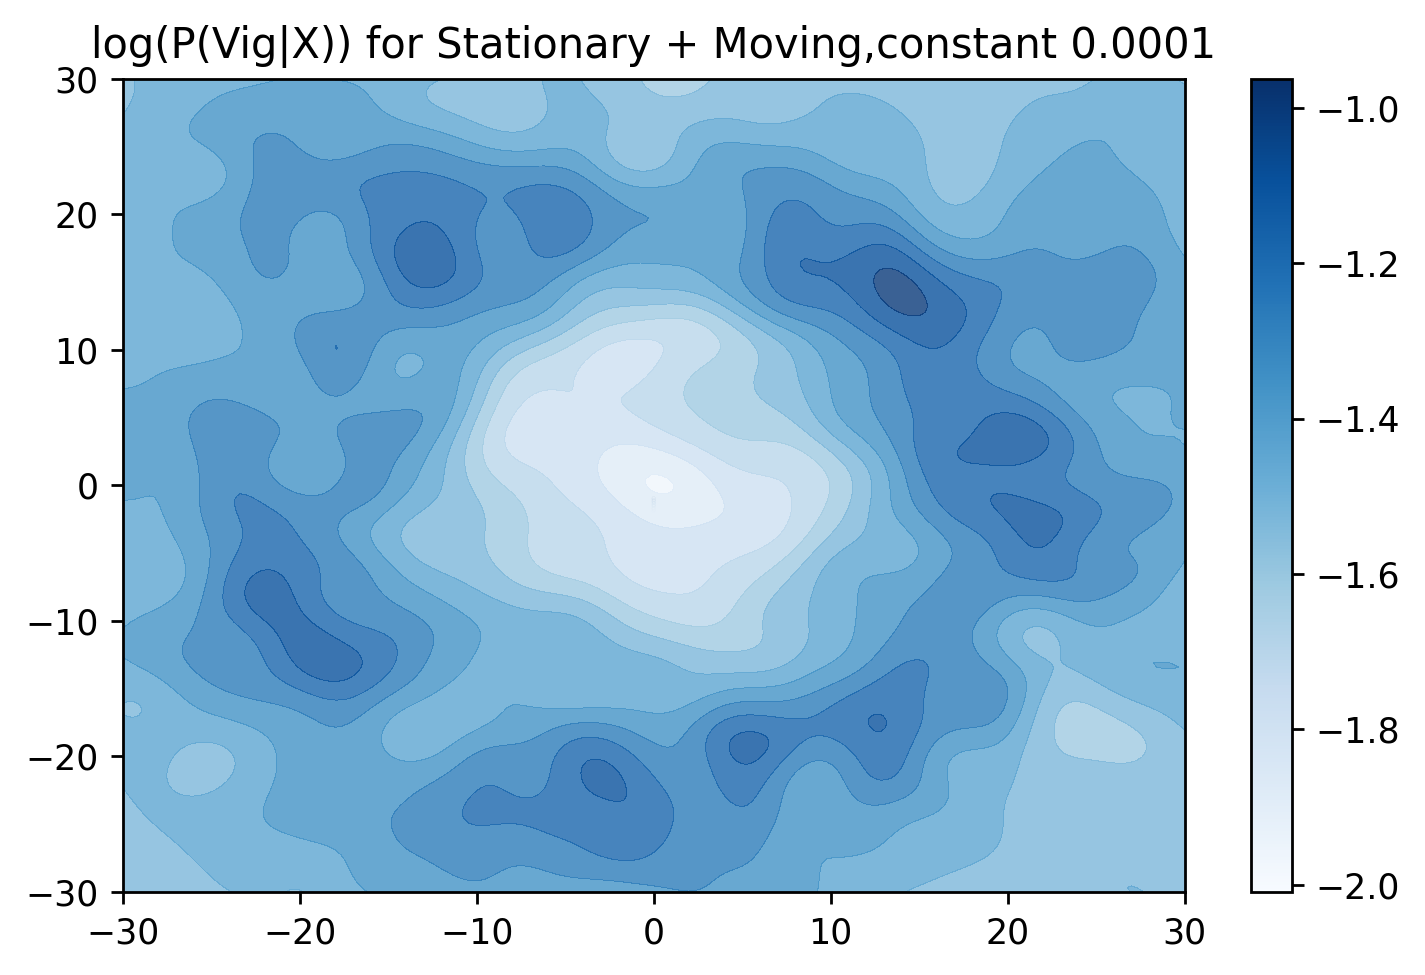

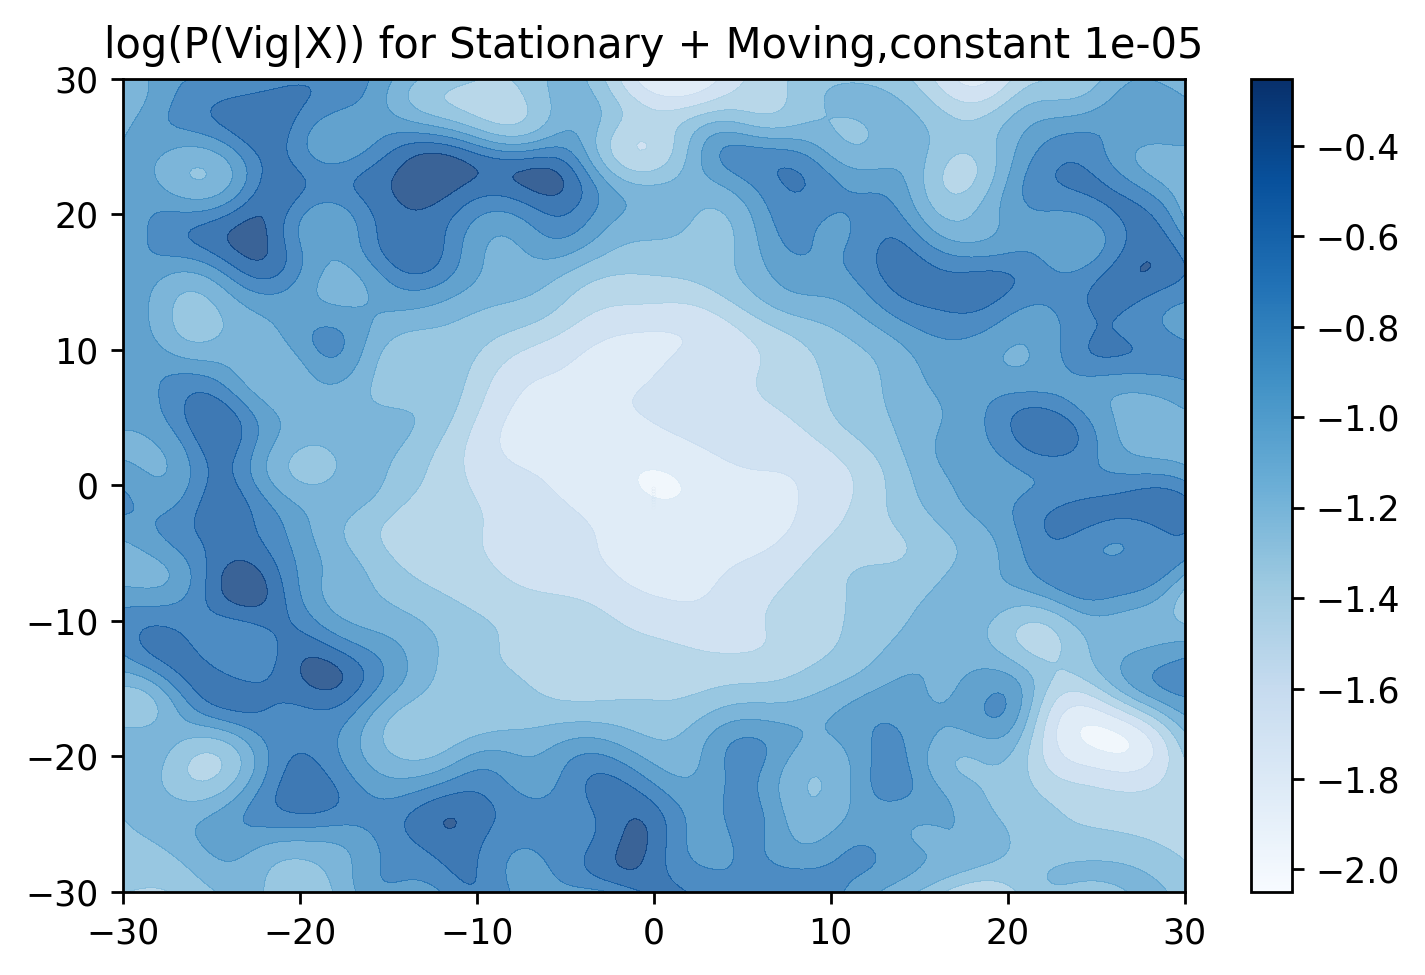

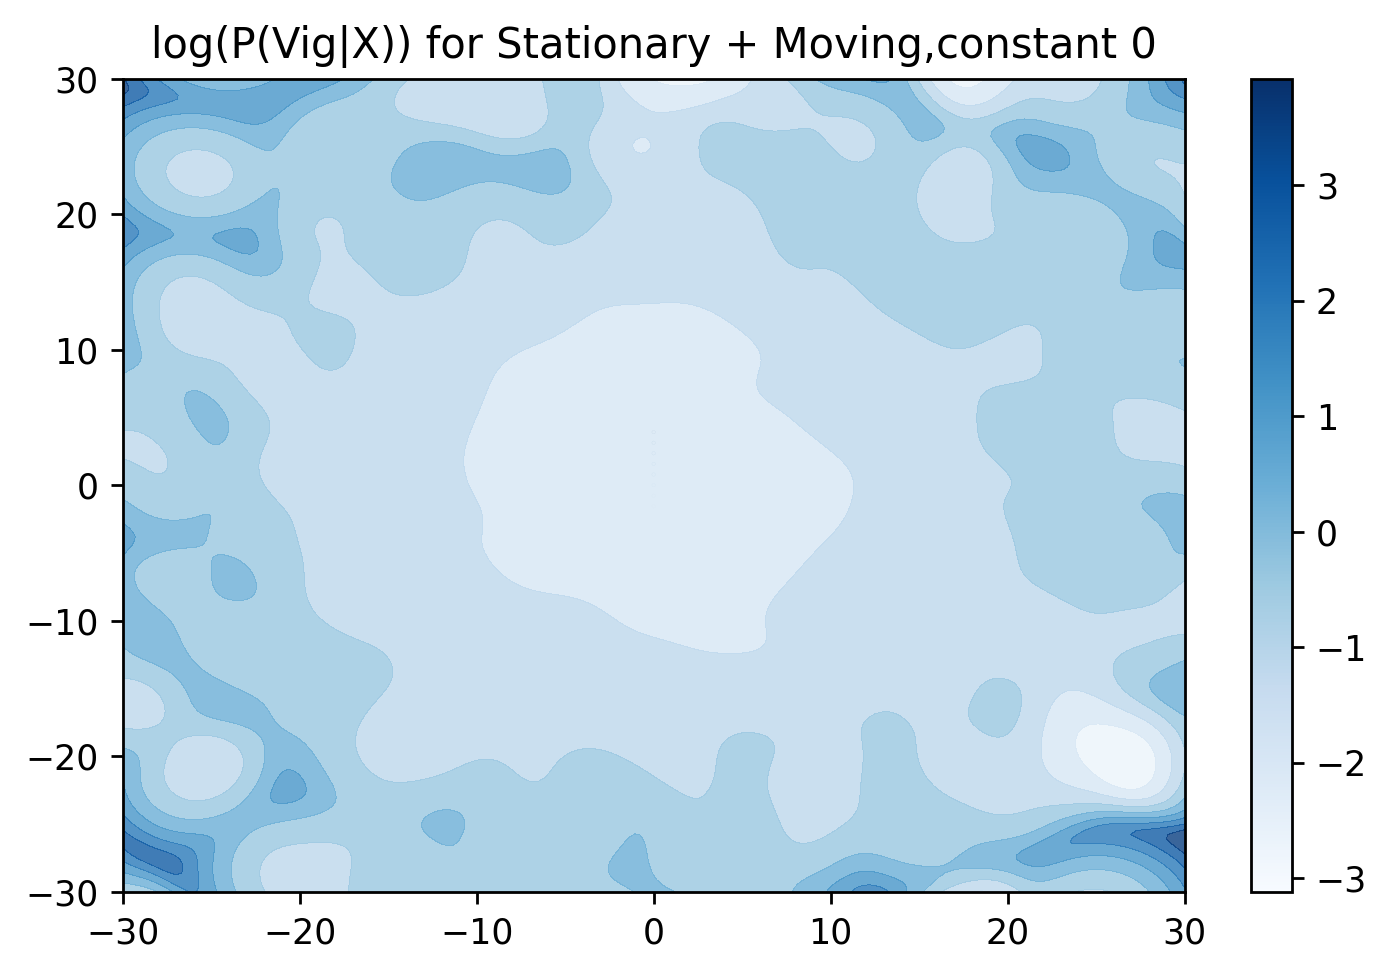

In [524]:
for c in [1,0.1,0.001,0.0001,0.00001,0]:

    log_P_vig_X = np.log(P_vig_pos+c) - np.log(P_group_pos+c) +  np.log(priors)
    fig,axes = plt.subplots(dpi=250)
    X, Y = np.meshgrid(np.linspace(-30, 30, 200), np.linspace(-30, 30, 200))




    axes.contourf(X, Y, log_P_vig_X,10, alpha=.8,cmap=cm.Blues)

    colors = np.linspace(np.min(log_P_vig_X),np.max(log_P_vig_X),10)
    mappable = plt.scatter(np.zeros(10), colors, s=0.0001, c=colors, cmap='Blues')
    plt.title('log(P(Vig|X)) for Stationary + Moving,constant '+str(c))
    plt.colorbar(mappable)


    plt.tight_layout()
    plt.show()

# Time Discrete

In [432]:

steptime = 120

times = sorted(data['Timestamp'].unique())[::steptime]
#value = value.set_index('Timestamp').loc[sorted(value['Timestamp'].unique())[::steptime],:].reset_index()
discrete_space_times,centroid_pos = [times[0]],[]

prev_pos = data.loc[data['Timestamp'] == times[0]].dropna()
for time in times[1:]:
    
    prev_centroid = np.sum(prev_pos[['X','Y']],axis=0)/prev_pos.shape[0]
    new_pos = data.loc[data['Timestamp'] == time].dropna()
    new_centroid = np.sum(new_pos[['X','Y']],axis=0)/new_pos.shape[0]
    prev_pos = new_pos.dropna()
    discrete_space_times.append(time)
    centroid_pos.append(new_centroid)
discrete_space_times = [pd.to_datetime(i) for i in discrete_space_times]

In [260]:
len(group_direction),len(discrete_space_times)

(172, 173)

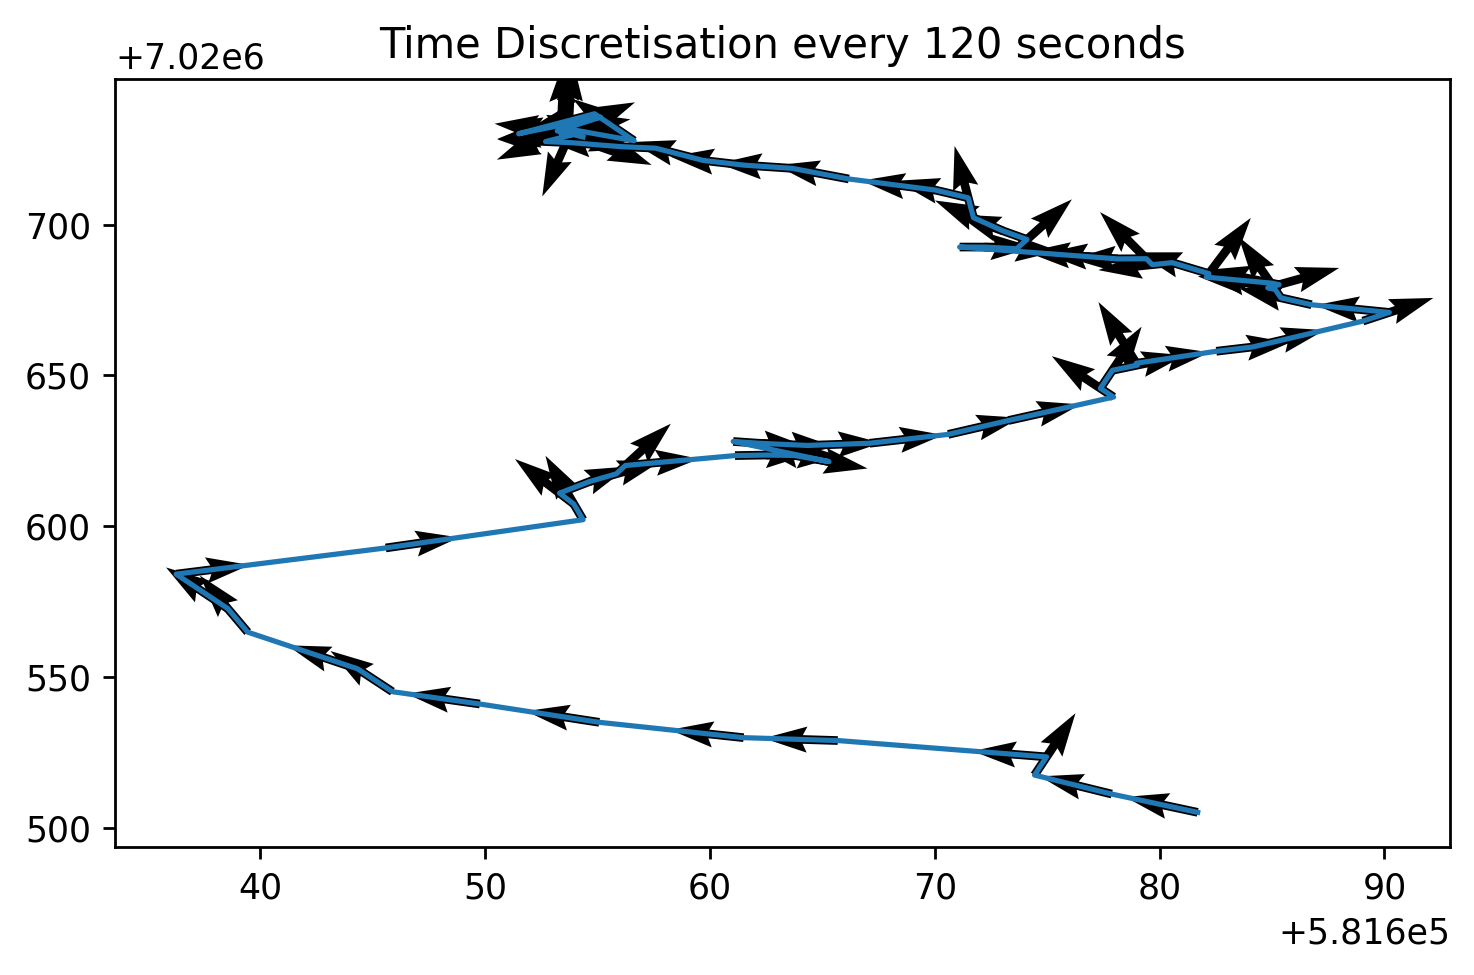

In [433]:
centroid_mov =pd.DataFrame()
centroid_mov['Timestamp'] = discrete_space_times[:-1]
centroid_mov['Centroid_X'] = [i[0] for i in centroid_pos]
centroid_mov['Centroid_Y'] = [i[1] for i in centroid_pos]
dirs = [(centroid_mov.iloc[i+1,1:3] - centroid_mov.iloc[i,1:3]) / np.sqrt(np.sum((centroid_mov.iloc[i+1,1:3] - centroid_mov.iloc[i,1:3])**2))  for i in range(centroid_mov.shape[0]-1) ]
centroid_mov = centroid_mov.iloc[0:-1,:]
centroid_mov['Dir_X'] = [i[0] for i in dirs]
centroid_mov['Dir_Y'] = [i[1] for i in dirs]

fig,ax= plt.subplots(dpi=250)
#ax.set_aspect('equal')
plt.title('Time Discretisation every ' + str(steptime) + ' seconds')
ax.plot(centroid_mov.iloc[:,1],centroid_mov.iloc[:,2])
ax.quiver(centroid_mov.iloc[:,1],centroid_mov.iloc[:,2],centroid_mov.iloc[:,3],centroid_mov.iloc[:,4],angles='xy')
plt.tight_layout()
plt.show()



In [434]:
data_discrete =  data.set_index('Timestamp').loc[centroid_mov['Timestamp']].reset_index()
data_discrete = data_discrete.replace([np.inf, -np.inf], np.nan)
data_discrete = data_discrete.dropna(axis=0).reset_index(drop=True)

data_discrete = data_discrete.drop(['lat','lon','height-msl'],axis=1)
corrected_data_discrete = pd.DataFrame()
for time in data_discrete['Timestamp'].unique():
    
    group_data = data_discrete.loc[data_discrete['Timestamp']==time]
    centroid_data = centroid_mov.loc[centroid_mov['Timestamp']==time]
    new_df =group_data.loc[:,['Timestamp','Behavior','Individual']]
    new_df['Rel_X'] = group_data['X'] - centroid_data['Centroid_X'].values
    new_df['Rel_Y'] = group_data['Y'] - centroid_data['Centroid_Y'].values
    
    direction_angle = np.arctan(( centroid_data['Dir_Y']/ centroid_data['Dir_X']).values)
    Rel_X = new_df['Rel_X']*np.cos(direction_angle) - new_df['Rel_Y']*np.sin(direction_angle)
    Rel_Y = new_df['Rel_X']*np.sin(direction_angle) + new_df['Rel_Y']*np.cos(direction_angle)
    new_df['Rel_X'] = Rel_X
    new_df['Rel_Y'] = Rel_Y
    new_df['X_zscore'] = (new_df['Rel_X'] - np.mean(new_df['Rel_X'])) / np.std(new_df['Rel_X']) 
    new_df['Y_zscore'] = (new_df['Rel_Y'] - np.mean(new_df['Rel_Y'])) / np.std(new_df['Rel_Y']) 
    
    corrected_data_discrete = pd.concat([corrected_data_discrete,new_df],axis=0)

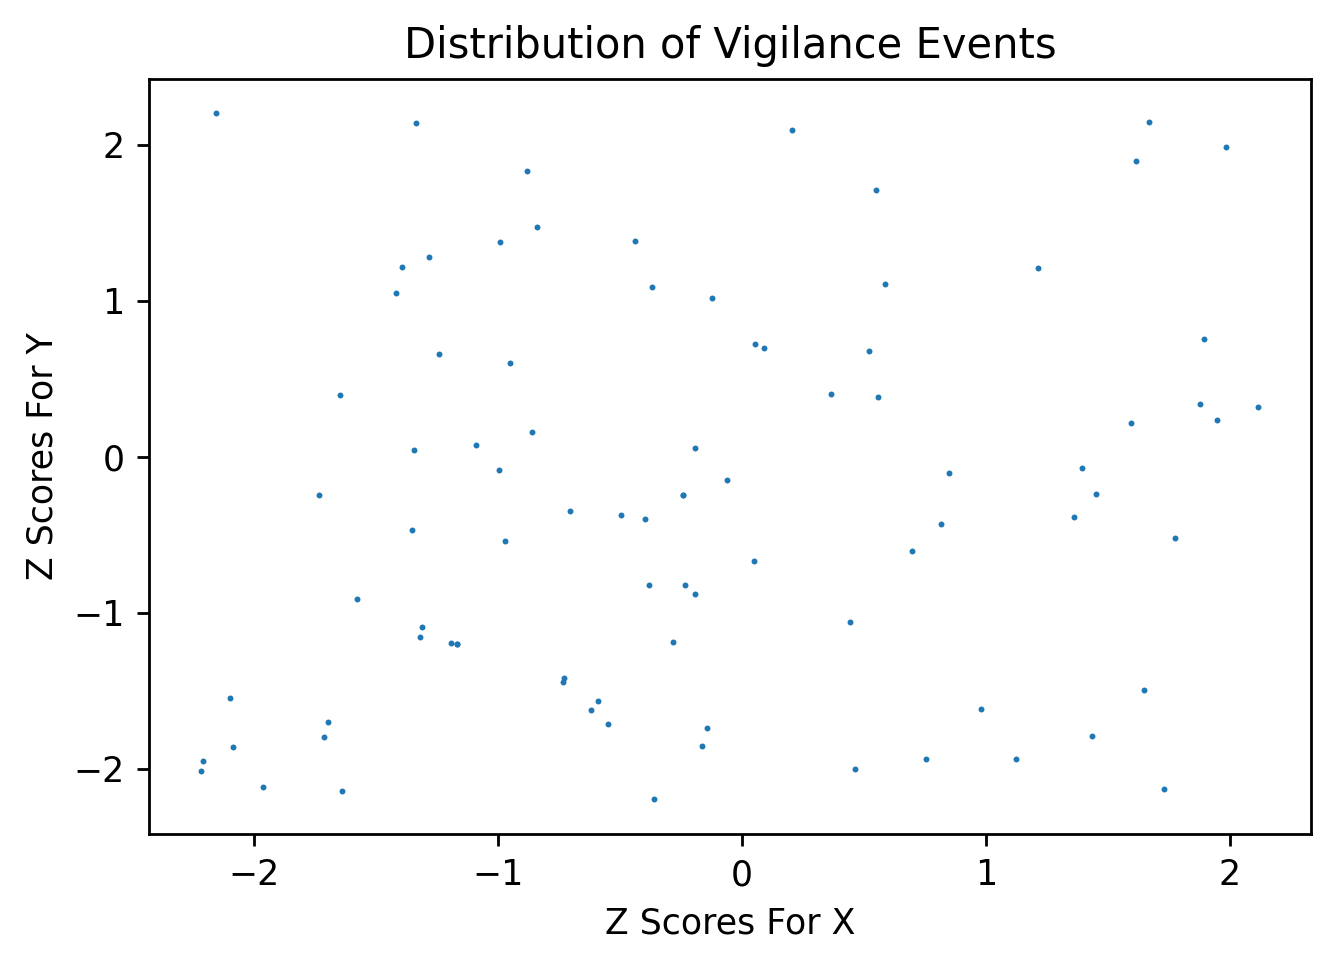

In [435]:
fig,ax= plt.subplots(dpi=250)
ax.set_title('Distribution of Vigilance Events')
ax.set_xlabel('Z Scores For X')
ax.set_ylabel('Z Scores For Y')
vig_data = corrected_data_discrete[corrected_data_discrete['Behavior']=='Vigilance']
ax.scatter(vig_data['X_zscore'],vig_data['Y_zscore'],s=0.5)

Duration of data 52128
Duration of Simultaneous data 50855
2021-05-17T08:09:57.000000000


Duration of data 54271
Seconds removed:  3
Duration of Simultaneous data 53206
2021-05-18T08:06:30.000000000


Duration of data 63003
Duration of Simultaneous data 62076
2021-05-19T08:07:02.000000000


Duration of data 63116
Duration of Simultaneous data 61937
2021-05-20T08:07:23.000000000


Duration of data 63302
Duration of Simultaneous data 62056
2021-05-21T08:07:01.000000000


Duration of data 63251
Duration of Simultaneous data 62286
2021-05-22T08:06:27.000000000


Duration of data 52604
Duration of Simultaneous data 51345
2021-05-23T08:08:18.000000000




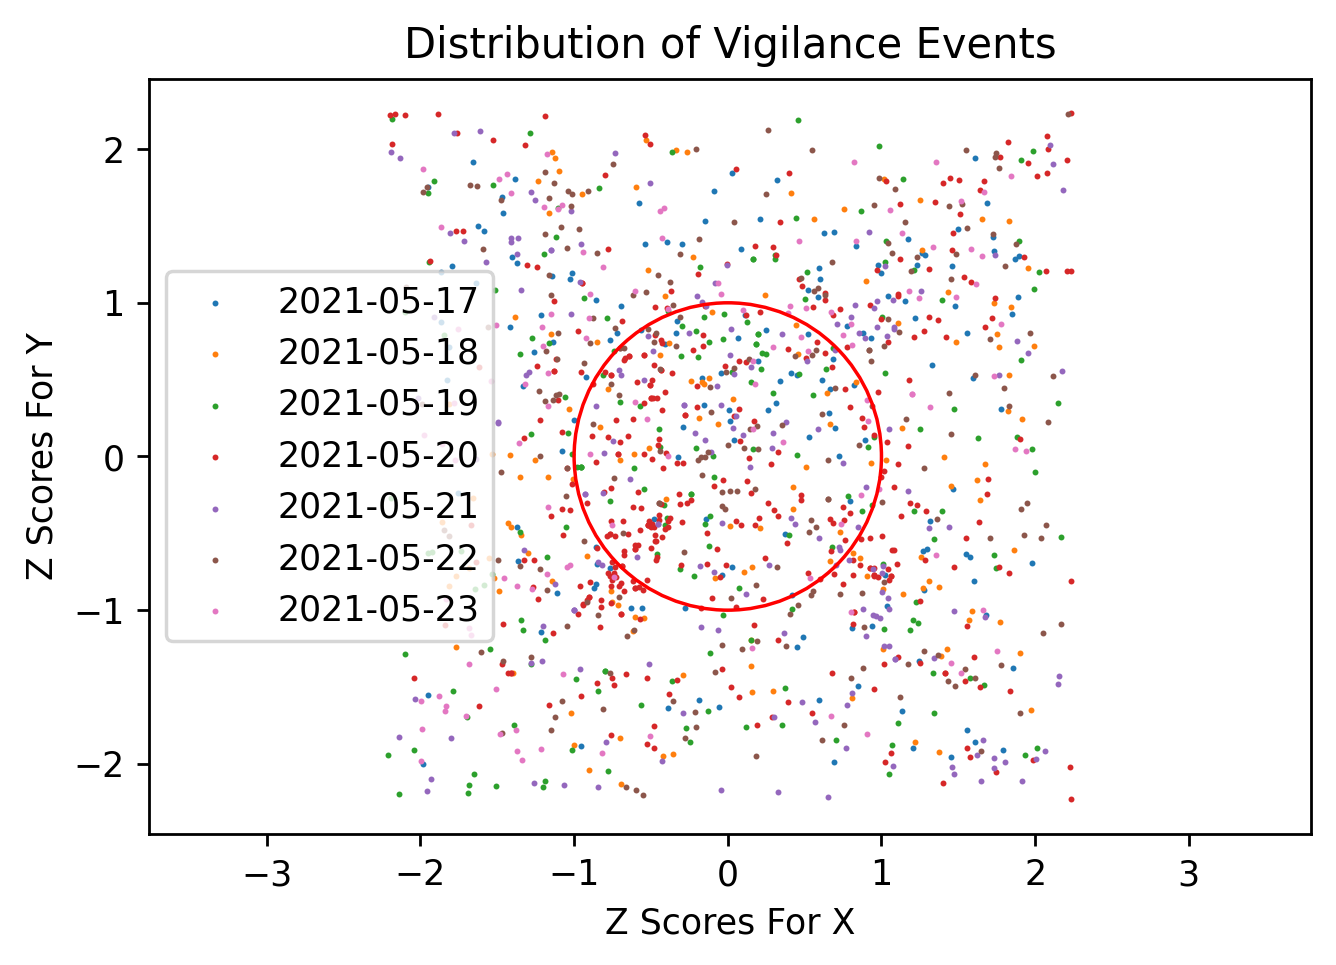

In [471]:
k = 'ZU_2021_1' #ZGroups
J = ['2021-05-17','2021-05-18','2021-05-19','2021-05-20','2021-05-21','2021-05-22','2021-05-23'] #Day
fig,ax= plt.subplots(dpi=250)
ax.set_title('Distribution of Vigilance Events')
ax.set_xlabel('Z Scores For X')
ax.set_ylabel('Z Scores For Y')
vig_events,vig_events_lims = [],[]
for j in J:
    data = pd.read_csv(ProcessedPath + str(k) + '/GPS_Days/'+ j,index_col=0)
    data = sync_gps_simultaneous(data,k,j)
    
    steptime = 60
    times = sorted(data['Timestamp'].unique())[::steptime]
    print(times[0])
    print('\n')

    

    discrete_space_times,centroid_pos = [times[0]],[]

    prev_pos = data.loc[data['Timestamp'] == times[0]].dropna(axis=0)
    for time in times[1:]:

        prev_centroid = np.sum(prev_pos[['X','Y']],axis=0)/prev_pos.shape[0]
        new_pos = data.loc[data['Timestamp'] == time].dropna(axis=0)
        new_centroid = np.sum(new_pos[['X','Y']],axis=0)/new_pos.shape[0]
        prev_pos = new_pos.dropna()
        discrete_space_times.append(time)
        centroid_pos.append(new_centroid)
        
    discrete_space_times = [pd.to_datetime(i) for i in discrete_space_times]
    centroid_mov =pd.DataFrame()
    centroid_mov['Timestamp'] = discrete_space_times[:-1]
    centroid_mov['Centroid_X'] = [i[0] for i in centroid_pos]
    centroid_mov['Centroid_Y'] = [i[1] for i in centroid_pos]
    dirs = [(centroid_mov.iloc[i+1,1:3] - centroid_mov.iloc[i,1:3]) / np.sqrt(np.sum((centroid_mov.iloc[i+1,1:3] - centroid_mov.iloc[i,1:3])**2))  for i in range(centroid_mov.shape[0]-1) ]
    centroid_mov = centroid_mov.iloc[0:-1,:]
    centroid_mov['Dir_X'] = [i[0] for i in dirs]
    centroid_mov['Dir_Y'] = [i[1] for i in dirs]

    
    data_discrete =  data.set_index('Timestamp').loc[centroid_mov['Timestamp']].reset_index()
    data_discrete = data_discrete.replace([np.inf, -np.inf], np.nan)
    data_discrete = data_discrete.dropna(axis=0).reset_index(drop=True)

    data_discrete = data_discrete.drop(['lat','lon','height-msl'],axis=1)
    corrected_data_discrete = pd.DataFrame()
    for time in data_discrete['Timestamp'].unique():
    
        group_data = data_discrete.loc[data_discrete['Timestamp']==time]
        centroid_data = centroid_mov.loc[centroid_mov['Timestamp']==time]
        new_df =group_data.loc[:,['Timestamp','Behavior','Individual']]
        new_df['Rel_X'] = group_data['X'] - centroid_data['Centroid_X'].values
        new_df['Rel_Y'] = group_data['Y'] - centroid_data['Centroid_Y'].values

        direction_angle = np.arctan(( centroid_data['Dir_Y']/ centroid_data['Dir_X']).values)
        Rel_X = new_df['Rel_X']*np.cos(direction_angle) - new_df['Rel_Y']*np.sin(direction_angle)
        Rel_Y = new_df['Rel_X']*np.sin(direction_angle) + new_df['Rel_Y']*np.cos(direction_angle)
        new_df['Rel_X'] = Rel_X
        new_df['Rel_Y'] = Rel_Y
        new_df['X_zscore'] = (new_df['Rel_X'] - np.mean(new_df['Rel_X'])) / np.std(new_df['Rel_X']) 
        new_df['Y_zscore'] = (new_df['Rel_Y'] - np.mean(new_df['Rel_Y'])) / np.std(new_df['Rel_Y']) 

        corrected_data_discrete = pd.concat([corrected_data_discrete,new_df],axis=0)

    vig_data = corrected_data_discrete[corrected_data_discrete['Behavior']=='Vigilance']
    vig_events_lims.append(len(vig_data[np.sqrt(vig_data['X_zscore']**2 + vig_data['Y_zscore']**2)<=1]))
    vig_events.append(len(vig_data))
    ax.scatter(vig_data['X_zscore'],vig_data['Y_zscore'],s=0.5,label=j)

cir = plt.Circle((0, 0), 1, color='r',fill=False)
ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir)
plt.legend()
plt.show()


In [472]:
sum(vig_events_lims)/ sum( vig_events)

0.2944960686204432

In [27]:
from sklearn.decomposition import PCA
stepspace = 10
def discretize_space(value,stepspace):
    times = sorted(value['Timestamp'].unique())
    prev_pos = value.loc[0,:]

    
steptime = 30
def discretize_time(value,steptime): 
    times = sorted(value['Timestamp'].unique())[::steptime]
    value = value.set_index('Timestamp').loc[sorted(value['Timestamp'].unique())[::steptime],:].reset_index()
    return value
    

def Elongation(value):
    
    pca = PCA(n_components=2)
    pca.fit(value.loc[:,['X','Y']])
    PC1 = np.max(pca.explained_variance_)
    PC2 = np.min(pca.explained_variance_)
    
    return 1 - (PC2/PC1)

def Spread(value):
    square_sum = 0
    N = value.shape[0]
    for i in value['Individual'].unique():
        element = value.loc[value['Individual']==i,['X','Y']]
        diff =  value.loc[:,['X','Y']] - element.values
        square_sum = square_sum +  np.sum(np.sum(np.square(diff)))
    return (1/(N*(N-1)))*np.sqrt(square_sum)

def Group_speed(time,value):
    N = value.shape[0]
    next_value = dfnew.loc[dfnew['Timestamp']==str(pd.to_datetime(time)+pd.Timedelta(seconds=1))]                                  
    diff =  (next_value.loc[:,['X','Y']].values/N - value.loc[:,['X','Y']].values/N)
    diff_square_sum = np.sum(np.square(diff)[:])
    return np.sqrt(diff_square_sum),np.sum(value.loc[:,['X','Y']].values/N,axis=0)


def extract_move(dfnew):
    
    times = sorted(dfnew['Timestamp'].unique())[30:-30]

    elongation,spread,group_speed = [],[],[]            
    x_centroid,y_centroid = [],[]
    
    for i in times:
        try:
            value = dfnew.loc[dfnew['Timestamp']==i]
            elongation.append(Elongation(value))
            spread.append(Spread(value))
            speed,centroid_pos = Group_speed(i,value)        
            group_speed.append(speed)
            x_centroid.append(centroid_pos[0])
            y_centroid.append(centroid_pos[1])
        except:
            print(i)
    
    movement_metrics = pd.DataFrame()
    movement_metrics['Timestamp'] = times
    movement_metrics['elongation'] = elongation
    movement_metrics['Group_speed'] = group_speed
    movement_metrics['X_Centroid'] = x_centroid
    movement_metrics['Y_Centroid'] = y_centroid
    movement_metrics['Spread'] = spread
    
    return movement_metrics

IndentationError: expected an indented block (<ipython-input-27-8abbb9242f5c>, line 9)

In [ ]:
metrics = extract_move(dfnew)